# Student Dropout Detection - Supervised Learning

Student dropout is a critical issue for educational institutions, affecting financial sustainability, institutional reputation, and student outcomes. Early identification of at-risk students is essential to enable timely and targeted interventions.

This project applies supervised machine learning techniques—specifically XGBoost and Neural Networks—to predict student dropout. A distinctive feature of the project is its multi-stage design: the same modeling pipeline is applied, optimized, and evaluated three times, each on a dataset representing a different stage of the student lifecycle.

- Stage 1: Enrollment data (e.g., applicant and course information)

- Stage 2: Adds student engagement metrics (e.g., attendance, authorized/unauthorized absences)

- Stage 3: Incorporates academic performance (e.g., modules attempted, passed, failed)

The main objective is to determine at which stage it is possible to effectively identify students at risk of dropping out. Model performance is evaluated stage by stage and a final comparison is made to draw conclusions about the predictive value of added information and the timing of effective intervention.

## Project Structure

The project is organized into four main phases, repeated for each of the three dataset stages:

1. **Data EDA, Feature Engineering and Preprocessing**  
   - Exploratory Data Analysis to understand distributions and relationships  
   - Handling missing data and outliers  
   - Feature creation, categorical groups aggregation
   - Encoding categorical variables and scaling features where necessary  

2. **XGBoost Modeling**  
   - Model training and hyperparameter optimization  
   - Evaluation using recall, F1-score and confusion matrix  
   - Extraction of **feature importance** to interpret the model (SHAP plot)

3. **Neural Network Modeling**  
   - Model architecture definition and tuning  
   - Evaluation using the same metrics for comparison  

4. **Final Comparison and Conclusions**  
   - Performance comparison across stages and models  
   - Summary of when dropout prediction becomes reliable  
   - Considerations on model interpretability and practical use

# Libraries Load

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score,
                              classification_report, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay,recall_score)
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import shap
import random
from sklearn.metrics import roc_curve, auc

# Stage 1  - Data

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# File URL
file_url = "/path_to_the_dataset/dataset_name"
df = pd.read_csv(file_url)

In [ ]:
df.head()

CentreName  LearnerCode BookingType              LeadSource DiscountType  \
0  ISC_Aberdeen      2284932       Agent  Standard Agent Booking          NaN   
1  ISC_Aberdeen      2399500       Agent  Standard Agent Booking          NaN   
2  ISC_Aberdeen      2424946       Agent  Standard Agent Booking          NaN   
3  ISC_Aberdeen      2426583       Agent  Standard Agent Booking          NaN   
4  ISC_Aberdeen      2434674       Agent  Standard Agent Booking          NaN   

  DateofBirth Gender Nationality                          HomeState  \
0  13/01/1998   Male     Chinese  Jianye District; Jiangsu Province   
1   12/2/1998   Male     Chinese                                NaN   
2    7/4/2000   Male     Chinese                                NaN   
3  18/05/1999   Male     Chinese                                NaN   
4  19/04/1996   Male     Chinese                                NaN   

                 HomeCity             CourseLevel  \
0                 Nanjing             Pre-Masters   
1                   Xi'an              Foundation   
2                 Chengdu  International Year Two   
3  LIUYANG CITY ;CHANGSHA  International Year Two   
4                  Xiamen             Pre-Masters   

                                          CourseName  IsFirstIntake  \
0                       Business and Law Pre-Masters           True   
1   Life Sciences Undergraduate Foundation Programme          False   
2  Business Management and Finance International ...          False   
3  Business Management and Finance International ...           True   
4                       Business and Law Pre-Masters           True   

  CompletedCourse                              ProgressionDegree  \
0             Yes  Msc Econ Accounting and Investment Management   
1             Yes                        BSc Biological Sciences   
2             Yes                                     MA Finance   
3             Yes                         MA Business Management   
4             Yes          MSc International Business Management   

    ProgressionUniversity  
0  University of Aberdeen  
1  University of Aberdeen  
2  University of Aberdeen  
3  University of Aberdeen  
4  University of Aberdeen

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUniversi

# Stage 1.1 - EDA and feature Engineering

**Stage 1: Pre-processing**
- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (>200 categories).
- Remove columns with > 50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.

In [ ]:
# Drop of the column LearnerCode since it's not useful.The Homestate  has been deleted since it has more the 50% of data missing
df_cleaned = df.drop(columns=['LearnerCode','HomeState'],axis=1)

In [ ]:
# Date of birth column utilised to built the age column and then drop of the first one
# I use as reference day the 01/01/2025
ref_date = pd.to_datetime("2025-01-01")
df_cleaned["DateofBirth"] = pd.to_datetime(df_cleaned["DateofBirth"], format="%d/%m/%Y")
df_cleaned["Age"] = (ref_date - df_cleaned["DateofBirth"]).dt.days // 365
df_cleaned.drop(columns=["DateofBirth"], inplace=True)

In [ ]:
# Here the features with high cardinality have been deleted (categorical features with more than 200 unique values)
for col in df_cleaned.columns:
    if df_cleaned[col].nunique() > 200:
        print(f"{col} has been deleted since it has {df_cleaned[col].nunique()} unique values")
        df_cleaned.drop(columns=[col], inplace=True)


HomeCity has been deleted since it has 5881 unique values
ProgressionDegree has been deleted since it has 2616 unique values


In [ ]:
df_cleaned['DiscountType'].unique()

array([nan, 'Other Scholarships / Bursaries', 'Bursary',
       'Special Arrangements', 'Scholarships Discount',
       'Hotel Quarantine Support', 'Enrolment Fee Waiver',
       'Discount - Promotional Offer', 'Additional benefits',
       'Early Bird Discount', 'Sales Accommodation Discount',
       'Staff discount'], dtype=object)

In [ ]:
#The DiscountType feature indicates whether a discount was applied (NaN if no discount) and the type of discount received
# Since the type of discount seems to be not relevant, I decided to create a binary feature called "HasDiscount" which indicates wheter a discount has been applied or not, regardless of the discount type
df_cleaned["HasDiscount"] = df_cleaned["DiscountType"].notna().astype(int)
df_cleaned.drop(columns=["DiscountType"], inplace=True)

In [ ]:
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel                                         CourseName  \
0             Pre-Masters                       Business and Law Pre-Masters   
1              Foundation   Life Sciences Undergraduate Foundation Programme   
2  International Year Two  Business Management and Finance International ...   
3  International Year Two  Business Management and Finance International ...   
4             Pre-Masters                       Business and Law Pre-Masters   

   IsFirstIntake CompletedCourse   ProgressionUniversity  Age  HasDiscount  
0           True             Yes  University of Aberdeen   26            0  
1          False             Yes  University of Aberdeen   26            0  
2          False             Yes  University of Aberdeen   24            0  
3           True             Yes  University of Aberdeen   25            0  
4           True             Yes  University of Aberdeen   28            0

In [ ]:
for col in df_cleaned.columns:
      print(f"{col} has {df_cleaned[col].nunique()} unique values")

CentreName has 19 unique values
BookingType has 2 unique values
LeadSource has 7 unique values
Gender has 2 unique values
Nationality has 151 unique values
CourseLevel has 4 unique values
CourseName has 172 unique values
IsFirstIntake has 2 unique values
CompletedCourse has 2 unique values
ProgressionUniversity has 40 unique values
Age has 38 unique values
HasDiscount has 2 unique values


In [ ]:
df_cleaned['CourseName'].unique()

array(['Business and Law Pre-Masters',
       'Life Sciences Undergraduate Foundation Programme',
       'Business Management and Finance International Year Two',
       'Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme',
       'Physical Sciences and Engineering Undergraduate Foundation Programme',
       'Life Sciences - pathway to Medicine Undergraduate Foundation Programme',
       'Science and Engineering Pre-Masters',
       'Humanities; Law and Social Science Undergraduate Foundation Programme',
       'Business and Law Pre-Masters (ICAS)',
       'Business Management and Finance International Year Two (ICAS)',
       'Computing Science International Year Two (ICAS)',
       'Science and Engineering Pre-Masters (ICAS)',
       'Engineering; Physical Sciences and Architecture International Foundation Year',
       'Health; Medical and Life Sciences International Foundation Year',
       'Business; Economics; Accounting and Finance International F

Once the dataset was cleaned it had 12 features. 3 of these features seem to be problematic since they are categorical and they have a lot of unique values, and the encoding applied to these should generate a too large dataset with a lot of columns who are carrying low information.

The CourseName feature has been treated to extract relevant information. In particular, a deeper analysis showed that some words are recurrent (like 'Business', 'Finance', 'Accounting' for the economics macro area of studying) and they can be use to subgroup some macro area of studying, leaving the course level info in its own specific feature.

In [ ]:
df_cleaned['StudyArea'] = None
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Mathematics', na=False), 'StudyArea'] = 'Mathematics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Arts|Art', na=False), 'StudyArea'] = 'Arts'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Engineering', na=False), 'StudyArea'] = 'Engineering'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Health', na=False), 'StudyArea'] = 'Health'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Science|Sciences', na=False), 'StudyArea'] = 'Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Computer|Comp', na=False), 'StudyArea'] = 'Computer Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Social', na=False), 'StudyArea'] = 'Social'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business|Finance|Accounting|Management|Economics', na=False), 'StudyArea'] = 'Economics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Relations', na=False), 'StudyArea'] = 'International Relations'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Media', na=False), 'StudyArea'] = 'Media'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business', na=False) &
               df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law and Business'
df_cleaned['StudyArea'] = df_cleaned['StudyArea'].fillna('Other')

In [ ]:
df_cleaned['StudyArea'].value_counts()


StudyArea
Economics                  11993
Science                     4341
Computer Science            2906
Law and Business            2794
Law                         1136
Media                        986
Social                       345
International Relations      232
Engineering                  214
Other                         90
Mathematics                   22
Name: count, dtype: int64

Even though there is likely some overlap between columns, this approach improves data quality by reducing the original feature to far fewer subgroups. Otherwise, using the raw CourseName column would have led to an excessive number of features during one-hot encoding.

In [ ]:
df_cleaned.drop(columns=["CourseName"], inplace=True)

The nationality feature has been treated to subgroup the most represented nationality to reduce the number of unique values.

In [ ]:
tot = 0
most_represented_nation = []
for nation in df_cleaned['Nationality'].unique():
    if (df_cleaned['Nationality'] == nation).sum() > 250:
        tot = tot + (df_cleaned['Nationality'] == nation).sum()
        print(f"{nation} has {df_cleaned['Nationality'].value_counts()[nation]} students")
        most_represented_nation.append(nation)

print(f'The most represented nationality are {len(most_represented_nation)} and they represent {np.around(100*tot/df_cleaned.shape[0],2)} % of total students')

Chinese has 9042 students
Taiwanese has 363 students
Kuwaiti has 893 students
Qatari has 283 students
Egyptian has 640 students
Emirati has 415 students
Hong Kong Chinese has 1278 students
Nigerian has 309 students
Indian has 2072 students
Bangladeshi has 2007 students
Saudi has 762 students
Omani has 411 students
Pakistani has 1973 students
Algerian has 311 students
Korean has 252 students
The most represented nationality are 15 and they represent 83.85 % of total students


The analysis shows that the 15 most represented nationalities account for 83% of the students in the dataset. Therefore, the nationality feature has been reduced to 16 groups: the top 15 nationalities and a 16th group labeled "Other" for all remaining cases.

In [ ]:
df_cleaned['Nationality'] = df_cleaned['Nationality'].apply(lambda x: x if x in most_represented_nation else 'Other')
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel  IsFirstIntake CompletedCourse  \
0             Pre-Masters           True             Yes   
1              Foundation          False             Yes   
2  International Year Two          False             Yes   
3  International Year Two           True             Yes   
4             Pre-Masters           True             Yes   

    ProgressionUniversity  Age  HasDiscount         StudyArea  
0  University of Aberdeen   26            0  Law and Business  
1  University of Aberdeen   26            0           Science  
2  University of Aberdeen   24            0         Economics  
3  University of Aberdeen   25            0         Economics  
4  University of Aberdeen   28            0  Law and Business

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   BookingType            25059 non-null  object
 2   LeadSource             25059 non-null  object
 3   Gender                 25059 non-null  object
 4   Nationality            25059 non-null  object
 5   CourseLevel            25059 non-null  object
 6   IsFirstIntake          25059 non-null  bool  
 7   CompletedCourse        25059 non-null  object
 8   ProgressionUniversity  25059 non-null  object
 9   Age                    25059 non-null  int64 
 10  HasDiscount            25059 non-null  int64 
 11  StudyArea              25059 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 2.1+ MB


The ProgressionUniversity feature is treated like the other with high cardinality. It is subgrouped to reduce the total number of unique values.

In [ ]:
tot_uni = 0
most_represented_prog_uni = []
for university in df_cleaned['ProgressionUniversity'].unique():
    if (df_cleaned['ProgressionUniversity'] == university).sum() > 100:
        print(university,(df_cleaned['ProgressionUniversity'] == university).sum())
        most_represented_prog_uni.append(university)
        tot_uni += 1

print('------------------------------------------------------------------------------')
print('The total number of unique Progression university is', df_cleaned['ProgressionUniversity'].nunique())
print('------------------------------------------------------------------------------')
print('If we consider just the progression university chosen by more than 100, they are',tot_uni)


University of Aberdeen 363
Cardiff University 687
University College Dublin 399
Durham University 2563
Coventry University London 931
Holland ISC - VU Amsterdam 106
University of Huddersfield 1781
Kingston University London 1892
Liverpool John Moores University 950
Lancaster University 1115
Leeds Beckett University 703
University of Leeds 1591
University of Lincoln 241
University of Strathclyde 677
Royal Holloway 1048
University of Sheffield International College 5877
University of Surrey 1051
University of Sussex 2103
Teesside University 632
------------------------------------------------------------------------------
The total number of unique Progression university is 40
------------------------------------------------------------------------------
If we consider just the progression university chosen by more than 100, they are 19


In the dataset there were 40 unique university chosen by the students (if eligible to progress). Since most of them have not been chosen by a multitude of students, it has been decided to use just the ones chosen by more than 100 students. All the others have been considered as 'Others'

In [ ]:
df_cleaned['ProgressionUniversity'] = df_cleaned['ProgressionUniversity'].apply(lambda x: x if x in most_represented_prog_uni else 'Other')
df_cleaned['ProgressionUniversity'].unique()

array(['University of Aberdeen', 'Cardiff University',
       'University College Dublin', 'Durham University', 'Other',
       'Coventry University London', 'Holland ISC - VU Amsterdam',
       'University of Huddersfield', 'Kingston University London',
       'Liverpool John Moores University', 'Lancaster University',
       'Leeds Beckett University', 'University of Leeds',
       'University of Lincoln', 'University of Strathclyde',
       'Royal Holloway', 'University of Sheffield International College',
       'University of Surrey', 'University of Sussex',
       'Teesside University'], dtype=object)

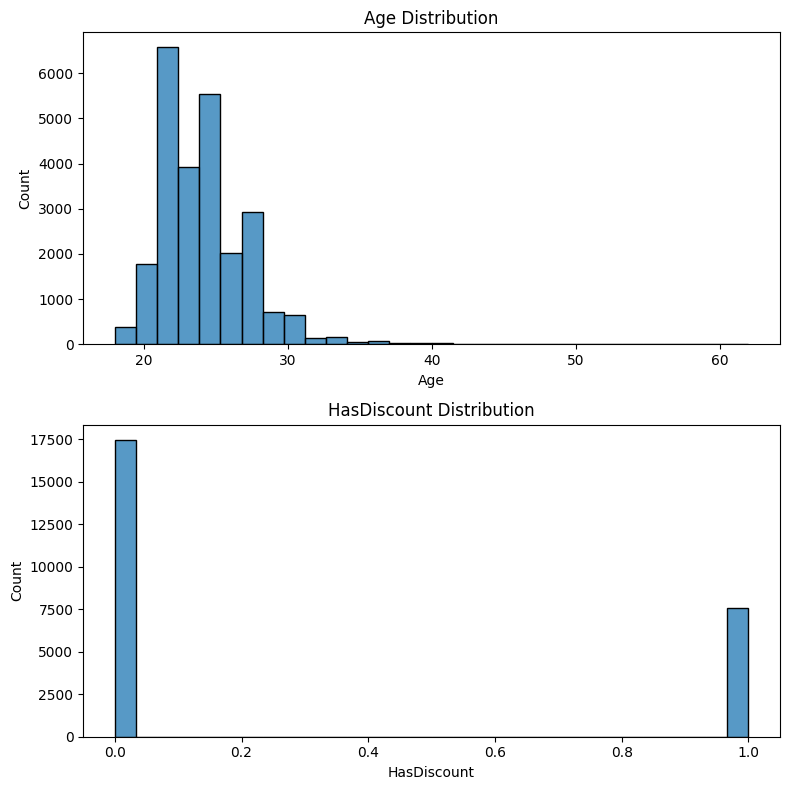

In [ ]:
numerical_features = df_cleaned.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(8, 4 * len(numerical_features)))

for ax, feature in zip(axes, numerical_features):
    sns.histplot(df_cleaned[feature], bins=30, kde=False, ax=ax)
    ax.set_title(f"{feature} Distribution")

plt.tight_layout()
plt.show()

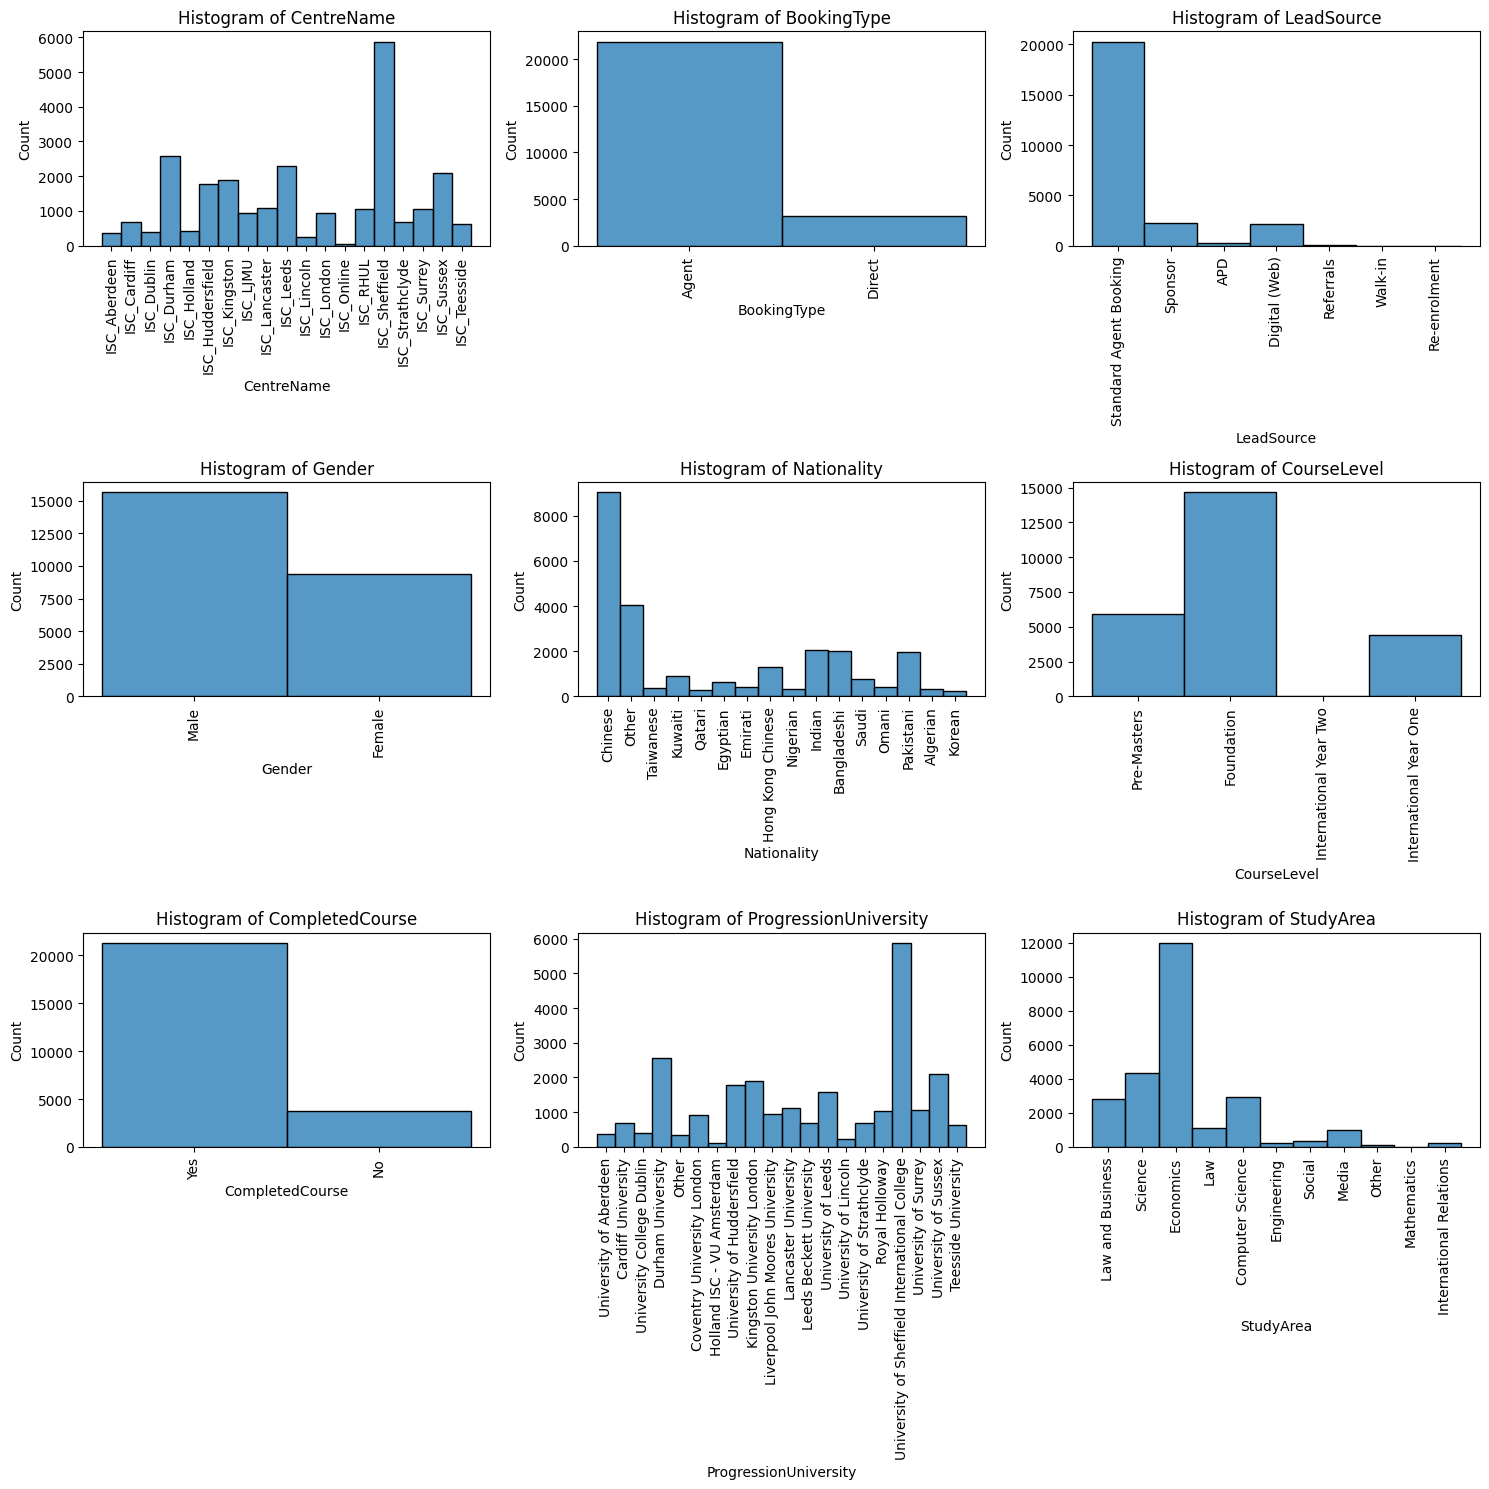

In [ ]:
# Plot of the categorical features
object_cols = df_cleaned.select_dtypes(include='object').columns
num_plots = len(object_cols)
num_rows = (num_plots + 2) // 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()


for i, col in enumerate(object_cols):
  sns.histplot(df_cleaned[col], kde=False, ax=axes[i])
  axes[i].set_title(f'Histogram of {col}')
  axes[i].tick_params(axis='x',rotation = 90)
s
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()


# Stage 1.2 - Encoding

In this section encoding is applied:
- Ordinal encoding wheter the feature's order matter
- One hot encoding wheter the fature's order doesn't matter

Looking at the dataset, it seems that the only ordinal variable is CourseLevel, since the order (Year one or year two) is important, and for this feature it has been decided to apply ordinal encodinge. For all the others, I decided to apply one hot encoding.

In [ ]:
df_cleaned['CourseLevel'].unique()

array(['Pre-Masters', 'Foundation', 'International Year Two',
       'International Year One'], dtype=object)

In [ ]:
# The IsFirstIntake column is modified to be a numerical column (1,0)
df_cleaned['IsFirstIntake'] = df_cleaned['IsFirstIntake'].astype(int)

In [ ]:
order_mapping = {
    'Foundation': 0,
    'International Year One': 1,
    'International Year Two': 2,
    'Pre-Masters': 3
}
df_encoded = df_cleaned.copy()
df_encoded['CourseLevel_encoded'] = df_cleaned['CourseLevel'].map(order_mapping)
df_encoded.drop(columns=['CourseLevel'], inplace=True)


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   BookingType            25059 non-null  object
 2   LeadSource             25059 non-null  object
 3   Gender                 25059 non-null  object
 4   Nationality            25059 non-null  object
 5   IsFirstIntake          25059 non-null  int64 
 6   CompletedCourse        25059 non-null  object
 7   ProgressionUniversity  25059 non-null  object
 8   Age                    25059 non-null  int64 
 9   HasDiscount            25059 non-null  int64 
 10  StudyArea              25059 non-null  object
 11  CourseLevel_encoded    25059 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 2.3+ MB


In [ ]:
# For these columns where the subgroups were created, instead of deleting the first occurence, it has been deleted explicitly the column which contains the 'Other'. This to ensure a bettere explainability later on.
df_encoded = pd.get_dummies(df_encoded, columns=['Nationality', 'StudyArea','ProgressionUniversity'])
df_encoded = df_encoded.drop(columns=['Nationality_Other', 'StudyArea_Other','ProgressionUniversity_Other'])

In [ ]:
# Here I have to do a further modification to delete the column StudyArea_Law and Business which is redundant and put its information in the Law column and Economics column
df_encoded['StudyArea_Law'] |= df_encoded['StudyArea_Law and Business']
df_encoded['StudyArea_Economics'] |= df_encoded['StudyArea_Law and Business']
df_encoded.drop(columns=['StudyArea_Law and Business'], inplace=True)

In [ ]:
# For all the other categorical features, it has been applied one-hot encoding, deleting the first column
df_encoded = pd.get_dummies(df_encoded, columns=df_encoded.select_dtypes(include=['object']).columns, drop_first=True)
df_encoded.shape

(25059, 74)

In [ ]:
# In this cell all the boolean type columns are modified to have numerical values
for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype(int)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 74 columns):
 #   Column                                                               Non-Null Count  Dtype
---  ------                                                               --------------  -----
 0   IsFirstIntake                                                        25059 non-null  int64
 1   Age                                                                  25059 non-null  int64
 2   HasDiscount                                                          25059 non-null  int64
 3   CourseLevel_encoded                                                  25059 non-null  int64
 4   Nationality_Algerian                                                 25059 non-null  int64
 5   Nationality_Bangladeshi                                              25059 non-null  int64
 6   Nationality_Chinese                                                  25059 non-null  int64
 7   Nationality_Egyptian  

After the feature engineering and the encoding the dataset is ready to be divided into X (input) and y (target).

In [ ]:
X = df_encoded.drop(columns=['CompletedCourse_Yes'])
y = df_encoded['CompletedCourse_Yes']
y.name = 'target'

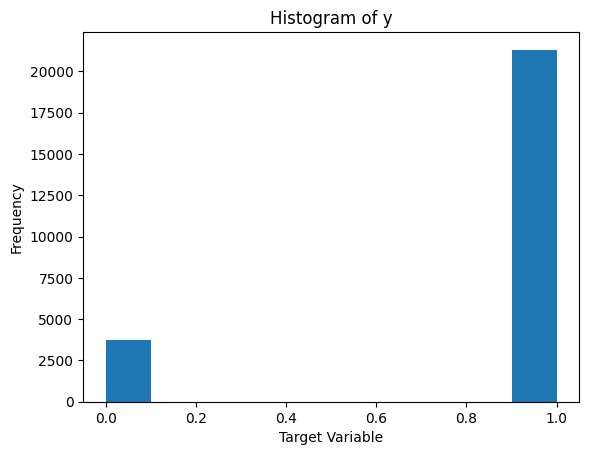

The dataset is composed of 85.0 % of students who completed the course and 15.0 who did not 


In [ ]:
plt.hist(y)
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Histogram of y')
plt.show()

print(f'The dataset is composed of {round(100*y.value_counts()[1]/y.shape[0],1)} % of students who completed the course and {round(100*y.value_counts()[0]/y.shape[0],1)} who did not ')


The distribution of output values reveals a class imbalance in the dataset. This suggests that standard accuracy may not be a reliable evaluation metric. Instead, metrics like AUC-ROC, precision-recall curves, and F1-score should be considered to better assess the model's performance, especially in handling minority classes.

In [ ]:
df_encoded.describe()

IsFirstIntake           Age   HasDiscount  CourseLevel_encoded  \
count   25059.000000  25059.000000  25059.000000         25059.000000   
mean        0.120675     24.048087      0.303085             0.887905   
std         0.325756      3.171722      0.459601             1.231749   
min         0.000000     18.000000      0.000000             0.000000   
25%         0.000000     22.000000      0.000000             0.000000   
50%         0.000000     23.000000      0.000000             0.000000   
75%         0.000000     26.000000      1.000000             1.000000   
max         1.000000     62.000000      1.000000             3.000000   

       Nationality_Algerian  Nationality_Bangladeshi  Nationality_Chinese  \
count          25059.000000             25059.000000         25059.000000   
mean               0.012411                 0.080091             0.360828   
std                0.110712                 0.271439             0.480250   
min                0.000000                 0.000000             0.000000   
25%                0.000000                 0.000000             0.000000   
50%                0.000000                 0.000000             0.000000   
75%                0.000000                 0.000000             1.000000   
max                1.000000                 1.000000             1.000000   

       Nationality_Egyptian  Nationality_Emirati  \
count          25059.000000         25059.000000   
mean               0.025540             0.016561   
std                0.157761             0.127622   
min                0.000000             0.000000   
25%                0.000000             0.000000   
50%                0.000000             0.000000   
75%                0.000000             0.000000   
max                1.000000             1.000000   

       Nationality_Hong Kong Chinese  ...  CentreName_ISC_Teesside  \
count                   25059.000000  ...             25059.000000   
mean                        0.051000  ...                 0.025220   
std                         0.220001  ...                 0.156797   
min                         0.000000  ...                 0.000000   
25%                         0.000000  ...                 0.000000   
50%                         0.000000  ...                 0.000000   
75%                         0.000000  ...                 0.000000   
max                         1.000000  ...                 1.000000   

       BookingType_Direct  LeadSource_Digital (Web)  LeadSource_Re-enrolment  \
count        25059.000000              25059.000000             25059.000000   
mean             0.126940                  0.084600                 0.000120   
std              0.332913                  0.278292                 0.010941   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 0.000000   
50%              0.000000                  0.000000                 0.000000   
75%              0.000000                  0.000000                 0.000000   
max              1.000000                  1.000000                 1.000000   

       LeadSource_Referrals  LeadSource_Sponsor  \
count          25059.000000        25059.000000   
mean               0.004709            0.090466   
std                0.068461            0.286855   
min                0.000000            0.000000   
25%                0.000000            0.000000   
50%                0.000000            0.000000   
75%                0.000000            0.000000   
max                1.000000            1.000000   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in   Gender_Male  \
count                       25059.000000        25059.000000  25059.000000   
mean                            0.809450            0.000838      0.624726   
std                             0.392743            0.028937      0.484203   
min                             0.000000            0.000000  

# Stage 1.3 XGBoost Algorithm

In this section the XGBoost algoritmh is implemented to predict wheter a student complete or not the course based on the information provided regerding each applicant.

To start, the dataset is divided into train and test. The test set will be used to evaluate the key metrics of the model.

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0],X_test.shape[0])

20047 5012


XGBoost Model Accuracy:  0.89
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       749
           1       0.92      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.79      0.76      0.77      5012
weighted avg       0.89      0.89      0.89      5012

XGBoost Model AUC: 0.88


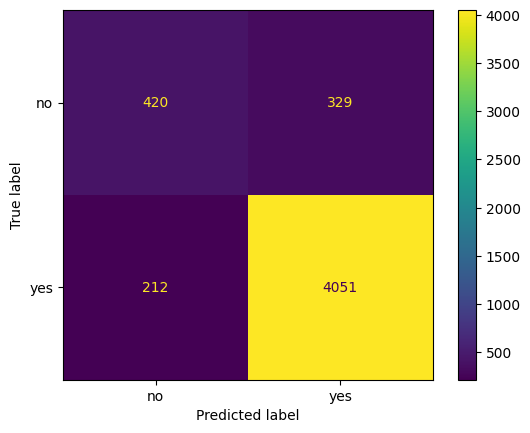

In [ ]:
xg_model_base = xgb.XGBClassifier(random_state=42)
xg_model_base.fit(X_train, y_train)

# Model evaluation
predictions = xg_model_base.predict(X_test)
cr_xbg_base_1 = classification_report(y_test, predictions)
print("XGBoost Model Accuracy: ", np.round(accuracy_score(y_test, predictions),2))
print(cr_xbg_base_1)

y_prob = xg_model_base.predict_proba(X_test)[:, 1]
auc_score_xgb_base_1 = roc_auc_score(y_test, y_prob)
print("XGBoost Model AUC:", np.round(auc_score_xgb_base_1, 2))


cm_xgb_base_1 = confusion_matrix(y_test, predictions)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_1, display_labels=["no","yes"])
cfmd.plot()
plt.show()

The initial model achieves an accuracy of 89%. Given the dataset's class imbalance, the primary focus is on the precision and recall of class 0 (students who are at risk of not completing the course). The results show a precision of 0.66 and a recall of 0.56. Fine-tuning the hyperparameters could improve these metrics by adjusting the precision-recall tradeoff to optimize detection of at-risk students.

To improve the model's performance, a grid search is performed.

The parameters considered in the optimization loop are:

- Max depth
- Learning rate
- Number of estimators

In [ ]:
# Hash map of parameters to test
param_grid = {
    "learning_rate": [0.05,0.03, 0.01],
    "max_depth": [4, 6, 8, 10]
}

# Start e end per n_estimators
start = 100
end = 1500

def increment_fn(n):
    if n > 400:
        return 200
    else:
        return 100

increment = increment_fn(start)

# Results List
results = []

# Main loop
for lr in param_grid["learning_rate"]:
    for depth in param_grid["max_depth"]:
        n = start
        while n <= end:
            model = xgb.XGBClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n,
                random_state=42, eval_metric='logloss'
            )
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

            # metrics calculation
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            report = classification_report(y_test, y_pred, output_dict=True)

            train_loss = log_loss(y_train, model.predict_proba(X_train))
            test_loss = log_loss(y_test, y_prob)

            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)
            # Salvataggio delle metriche
            metrics = {
                    "learning_rate": lr,
                    "max_depth": depth,
                    "n_estimators": n,
                    "train_loss": train_loss,
                    "accuracy": report["accuracy"],
                    "precision_0": report["0"]["precision"],
                    "recall_0": report["0"]["recall"],
                    "f1_0": report["0"]["f1-score"],
                    "precision_1": report["1"]["precision"],
                    "recall_1": report["1"]["recall"],
                    "f1_1": report["1"]["f1-score"],
                    "auc": roc_auc_score(y_test, y_prob),
                    "test_loss": test_loss,
                    "confusion_matrix": cm,
                    "classification_report": cr
                }


            results.append(metrics)
            increment = increment_fn(n)
            prev_test_loss = test_loss
            n += increment
            print(f"With  lr = {lr}and max depth = {depth} and {n} number of estimators the losses are:")
            print(f'Training loss = {np.round(train_loss,3)}, Test loss = Training loss = {np.round(test_loss,3)}')
            print('------------------------------------------------------------')


With  lr = 0.05and max depth = 4 and 200 number of estimators the losses are:
Training loss = 0.266, Test loss = Training loss = 0.277
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 300 number of estimators the losses are:
Training loss = 0.258, Test loss = Training loss = 0.274
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 400 number of estimators the losses are:
Training loss = 0.253, Test loss = Training loss = 0.273
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 500 number of estimators the losses are:
Training loss = 0.25, Test loss = Training loss = 0.273
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 700 number of estimators the losses are:
Training loss = 0.248, Test loss = Training loss = 0.273
------------------------------------------------------------
With  lr = 0.05and ma

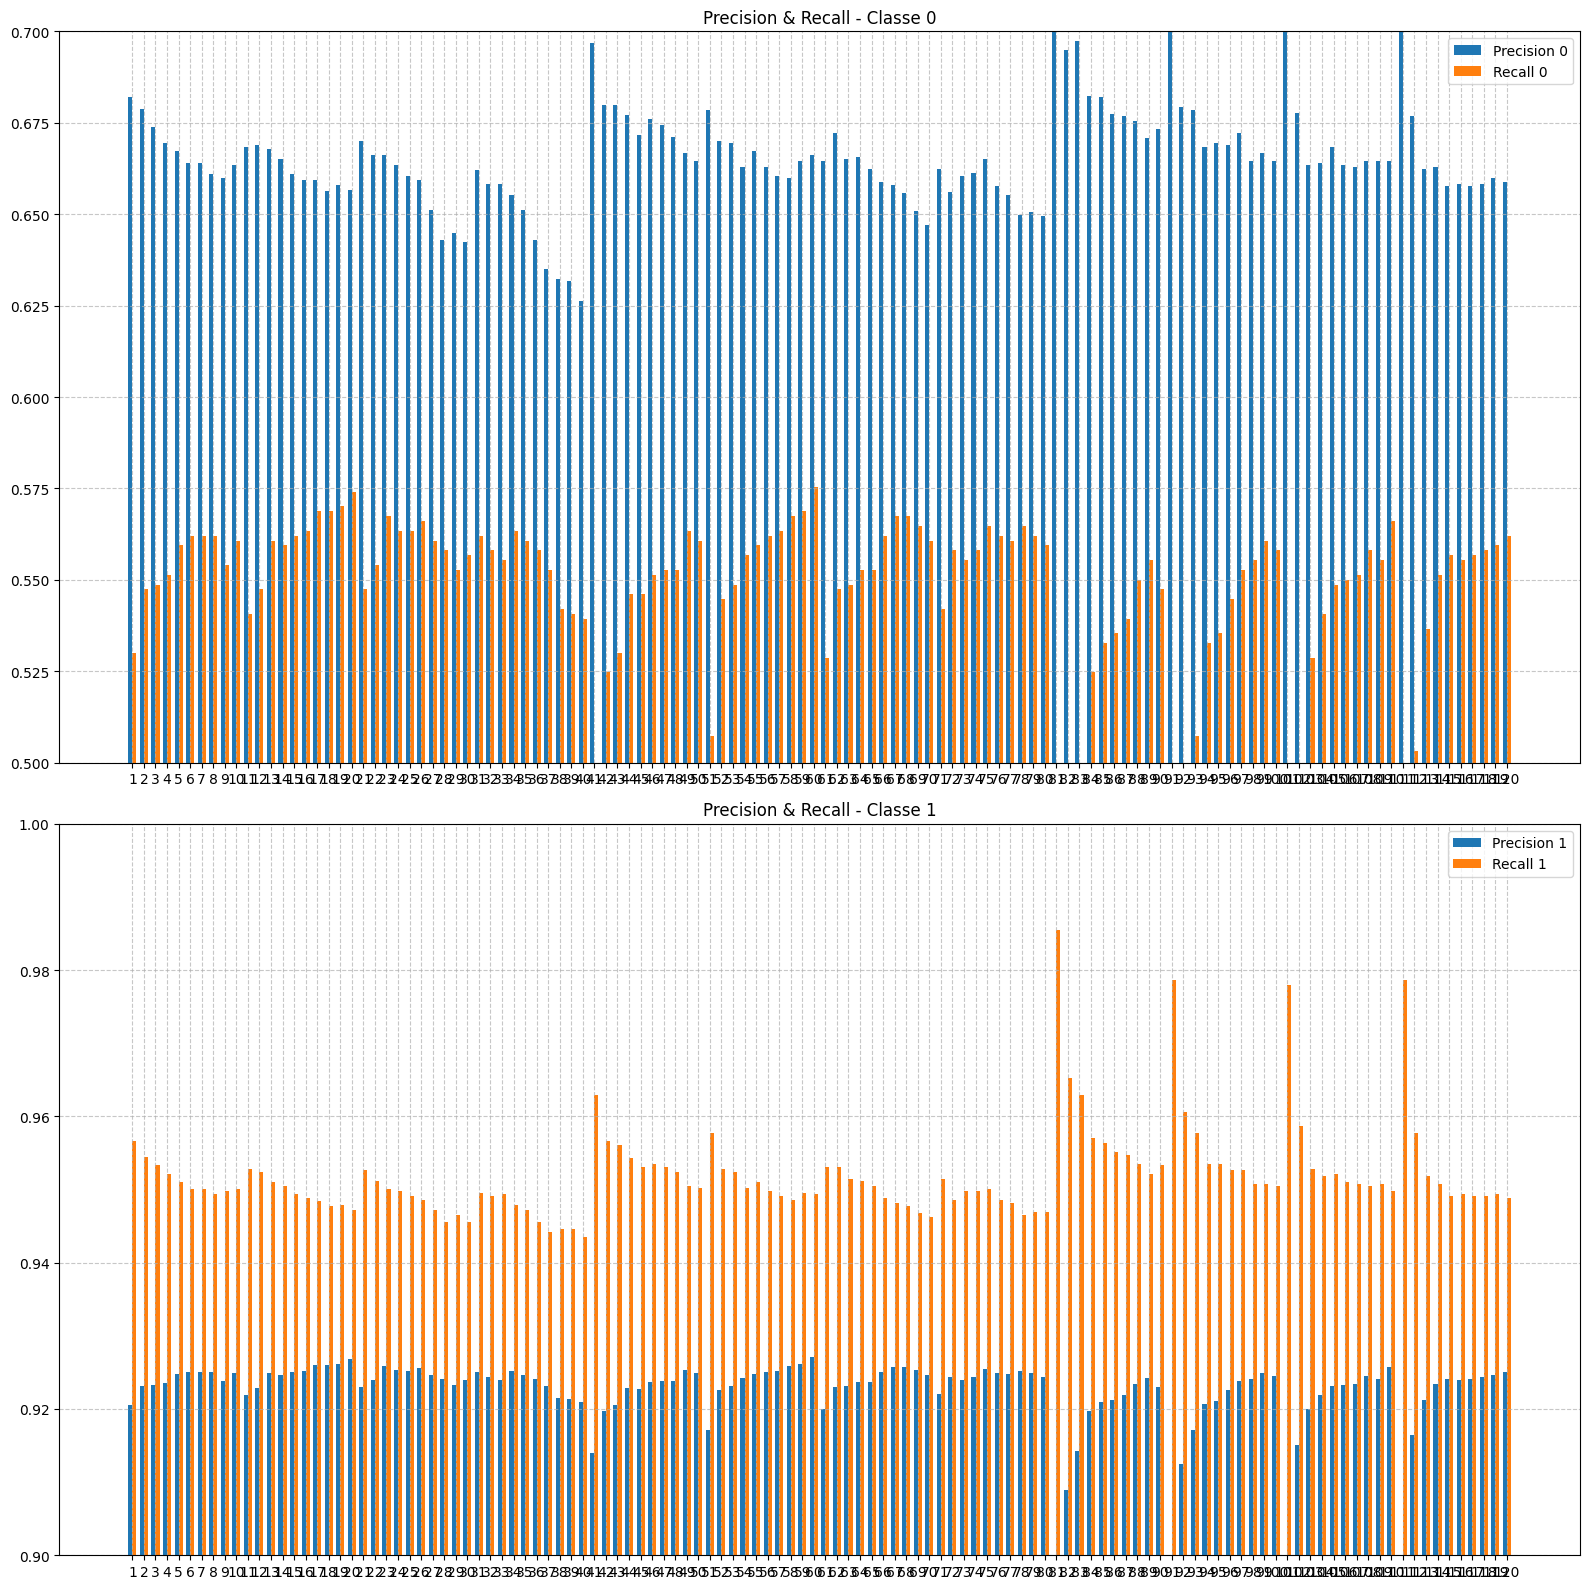

In [ ]:
precision_0 = [r["precision_0"] for r in results]
recall_0 = [r["recall_0"] for r in results]
precision_1 = [r["precision_1"] for r in results]
recall_1 = [r["recall_1"] for r in results]

x = np.arange(len(results))

fig, axes = plt.subplots(2,1, figsize=(16, 16))

axes[0].bar(x - bar_width/2, precision_0, bar_width, label="Precision 0")
axes[0].bar(x + bar_width/2, recall_0, bar_width, label="Recall 0")
axes[0].set_title("Precision & Recall - Classe 0")
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, n+1))
axes[0].set_ylim(0.5, 0.7)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width/2, precision_1, bar_width, label="Precision 1")
axes[1].bar(x + bar_width/2, recall_1, bar_width, label="Recall 1")
axes[1].set_title("Precision & Recall - Classe 1")
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, n+1))
axes[1].set_ylim(0.9, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


After an hyperparameter optimization loop, we observe that the model's performance remains quite similar to the baseline model in terms of precision and recall for class 0, the underrepresented class. One possible explanation is that the dataset imbalance limits the model's ability to learn meaningful patterns for the minority class, making hyperparameter tuning less impactful. Additionally, the default XGBoost parameters may already provide a strong baseline, suggesting that further improvements might require data augmentation  or alternative modeling approaches.

In [ ]:
best_recall = 0
best_precision = 0

for i in range(len(results)):
    if results[i]["recall_0"] > best_recall:
        best_recall = results[i]["recall_0"]
        best_recall_index = i
    if results[i]["precision_0"] > best_precision:
      best_precision = results[i]["precision_0"]
      best_precision_index = i

print('Best recall configuration has a recall for the class 0 (underrepresented) of', np.round(best_recall, 2),
      'and a precision of', np.round(results[best_recall_index]["precision_0"], 2))
print('The configuration is: learning rate =', results[best_recall_index]['learning_rate'],
      ', max depth =', results[best_recall_index]['max_depth'],
      ', number of estimators =', results[best_recall_index]['n_estimators'])
print('-----------------------------------------------------')
print('Best precision configuration has a recall for the class 0 (underrepresented) of',
      np.round(results[best_precision_index]["recall_0"], 2),
      'and a precision of', np.round(best_precision, 2))
print('The configuration is: learning rate =', results[best_precision_index]['learning_rate'],
      ', max depth =', results[best_precision_index]['max_depth'],
      ', number of estimators =', results[best_precision_index]['n_estimators'])

opt_lr = results[best_recall_index]['learning_rate']
opt_depth = results[best_recall_index]['max_depth']
opt_n_est = results[best_recall_index]['n_estimators']
cm_xgb_best_1 = results[best_recall_index]['confusion_matrix']
cr_xbg_best_1 = results[best_recall_index]['classification_report']
auc_score_xgb_best_1 = results[best_recall_index]['auc']


Best recall configuration has a recall for the class 0 (underrepresented) of 0.58 and a precision of 0.67
The configuration is: learning rate = 0.03 , max depth = 6 , number of estimators = 1500
-----------------------------------------------------
Best precision configuration has a recall for the class 0 (underrepresented) of 0.33 and a precision of 0.73
The configuration is: learning rate = 0.01 , max depth = 6 , number of estimators = 100


The dataset under analysis is imbalanced. In this case, it has been decided to consider the optimal model as the one that maximizes the recall of class 0, to try to identify as many at-risk students as possible who may not complete the course. This choice is particularly important given that the dataset at stage 1 contains data on students before they begin the course. A high precision, on the other hand, could have led to missing the identification of many at-risk students, reducing the effectiveness of early interventions.

Below the comparison between the base model (with default hyperparameters) and the model optimized through grid search to maximize the recall of the class 0.

Classification report for the base Model
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       749
           1       0.92      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.79      0.76      0.77      5012
weighted avg       0.89      0.89      0.89      5012

Classification report for the optimal Model
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       749
           1       0.93      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.76      0.78      5012
weighted avg       0.89      0.89      0.89      5012

XGBoost base Model AUC: 0.88
XGBoost base Model AUC: 0.87


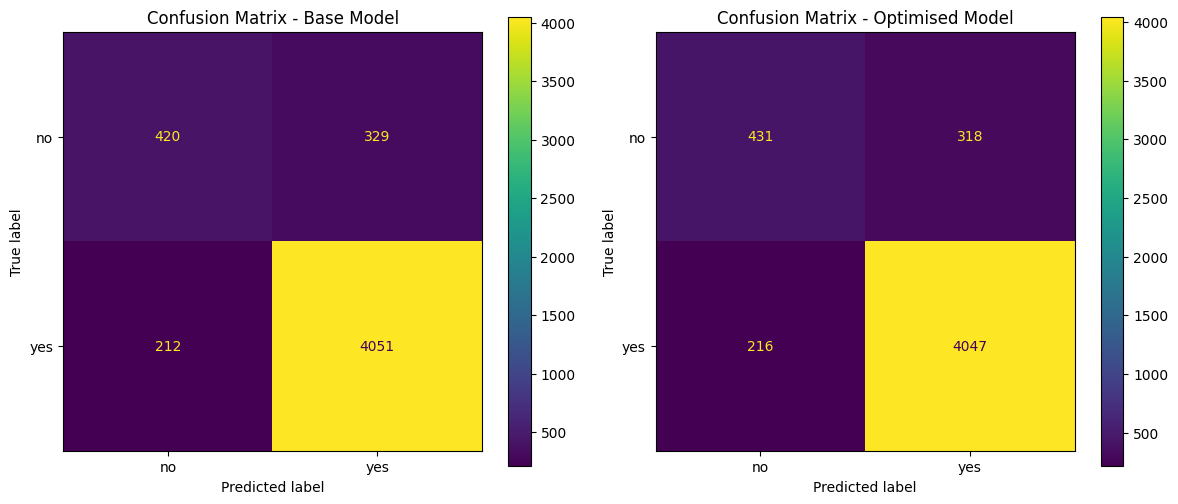

In [ ]:
print('Classification report for the base Model')
print(cr_xbg_base_1)
print('Classification report for the optimal Model')
print(cr_xbg_best_1)

print("XGBoost base Model AUC:", np.round(auc_score_xgb_base_1, 2))
print("XGBoost base Model AUC:", np.round(auc_score_xgb_best_1, 2))


cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_1, display_labels=["no","yes"])
cfmd_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best_1, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cfmd.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix - Base Model")
cfmd_opt.plot(ax=axes[1])
axes[1].set_title("Confusion Matrix - Optimised Model")
plt.tight_layout()
plt.show()


From the classification reports and confusion matrices, it can be observed that the optimized model has slightly better performance than the baseline model, with an increase in recall from 0.56 to 0.58 and an improvement in the F1 score for class 0 from 0.61 to 0.62. It is evident that hyperparameter tuning did not have a significant impact.

Stage 1.3.1 Feature Importance

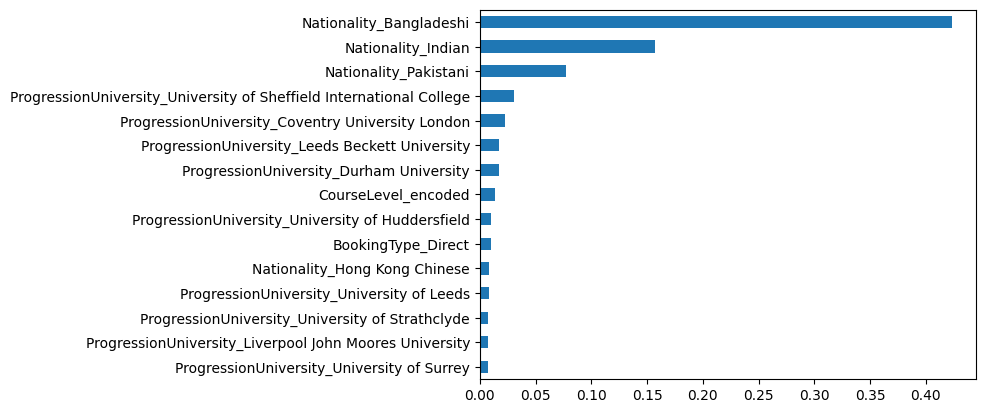

In [ ]:
xg_model_opt = xgb.XGBClassifier(random_state=42,learning_rate=opt_lr, max_depth=opt_depth, n_estimators=opt_n_est)
xg_model_opt.fit(X_train, y_train)
feature_importance = pd.Series(xg_model_opt.feature_importances_, index=X_train.columns).sort_values()

feature_importance.iloc[-15:].plot.barh()
plt.show()

Although it may seem unusual that certain nationalities emerge as the most important features, this is driven by the fact that individuals from these specific groups exhibit a significantly higher dropout rate compared to the overall population in the dataset.

In [ ]:
y_train_filtered = y_train[X_train['Nationality_Bangladeshi'] == 1]
print(y_train_filtered.value_counts(normalize=True))
y_train_filtered = y_train[X_train['Nationality_Indian'] == 1]
print(y_train_filtered.value_counts(normalize=True))

target
0    0.656269
1    0.343731
Name: proportion, dtype: float64
target
1    0.510341
0    0.489659
Name: proportion, dtype: float64


It can be seen that, the proportion of students in the dataset who did not complete the course are muche higher (65%  and 48% of the nationality Bangladeshi and Indian) with respect to the 15% of the entire students' population under analysis.

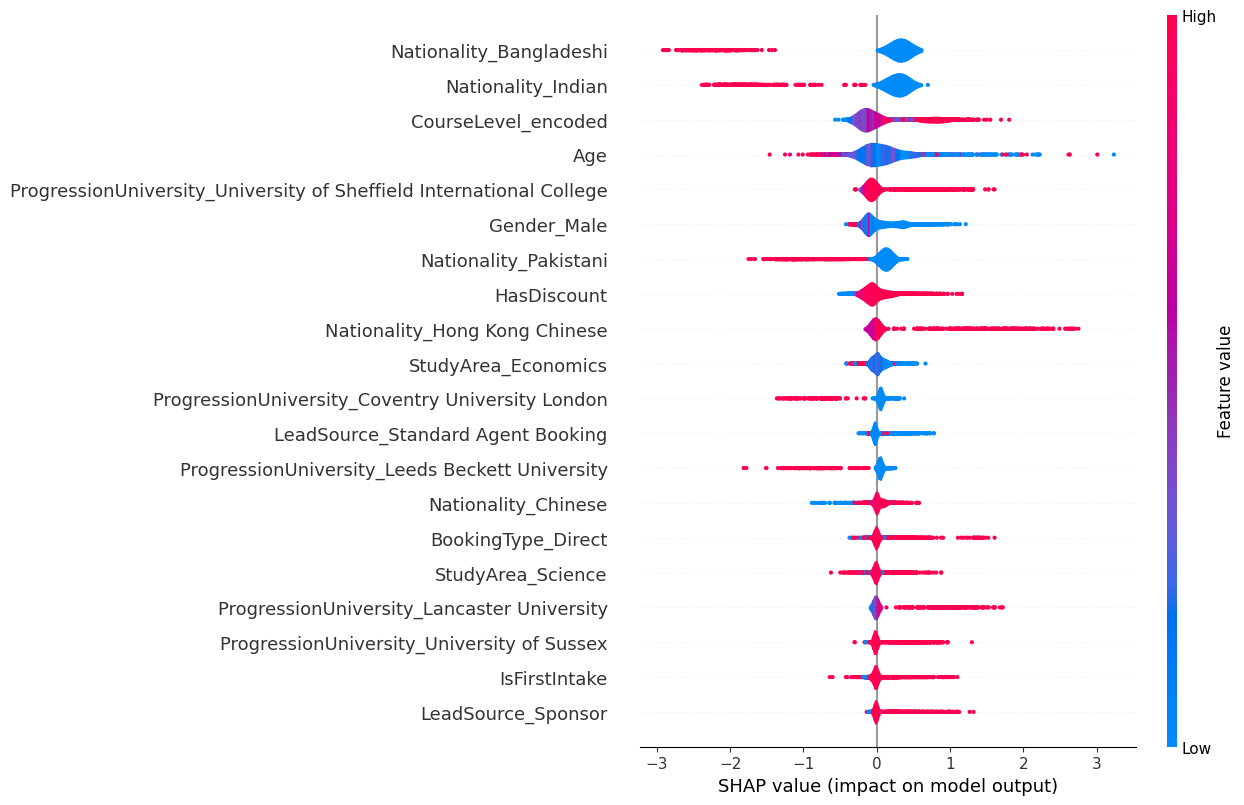

In [ ]:

shap.initjs()
shap_ex = shap.TreeExplainer(xg_model_opt)
vals = shap_ex(X_test)
shap.plots.violin(vals)

The SHAP plot provides insight into the influence of each feature and the direction in which they impact the model's predictions. Notably, high values for the Indian and Bangladeshi nationality features (indicating belonging to these groups) push the model toward predicting course dropout, aligning with the previously discussed reasons.

Conversely, features like course level and progression to the University of Sheffield exhibit the opposite effect. Since course level is a categorical feature, the plot suggests that as its value increases (indicating a more advanced year of study), the likelihood of predicting course completion also rises. Meanwhile, progression to the University of Sheffield, being a binary feature, strongly influences the model toward predicting course completion, reinforcing its importance in the decision-making process.

# Stage 1.4 - Neural Network

Before using the neural network based model, it's necessary to apply the scaling to the features to optimize the neural network performance. The scaling is applied to the features that have more than 2 unique values, to avoid scaling the binary columns.

In [ ]:
# Trova le colonne con più di 2 valori unici (non binarie)
num_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Inizializza lo scaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Applica lo scaling solo alle colonne selezionate
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_train_scaled.head()

IsFirstIntake       Age  HasDiscount  CourseLevel_encoded  \
24961              0 -0.648428            1            -0.720292   
3214               1  3.465593            1             1.716102   
8203               0 -0.648428            0            -0.720292   
13925              0 -0.331965            0             0.091839   
24910              1 -0.964891            1            -0.720292   

       Nationality_Algerian  Nationality_Bangladeshi  Nationality_Chinese  \
24961                     0                        0                    0   
3214                      0                        0                    0   
8203                      0                        0                    0   
13925                     0                        0                    0   
24910                     0                        0                    0   

       Nationality_Egyptian  Nationality_Emirati  \
24961                     0                    0   
3214                      0                    0   
8203                      0                    0   
13925                     0                    0   
24910                     0                    0   

       Nationality_Hong Kong Chinese  ...  CentreName_ISC_Sussex  \
24961                              0  ...                      0   
3214                               0  ...                      0   
8203                               0  ...                      0   
13925                              1  ...                      0   
24910                              0  ...                      0   

       CentreName_ISC_Teesside  BookingType_Direct  LeadSource_Digital (Web)  \
24961                        1                   0                         0   
3214                         0                   0                         0   
8203                         0                   0                         0   
13925                        0                   0                         0   
24910                        1                   0                         0   

       LeadSource_Re-enrolment  LeadSource_Referrals  LeadSource_Sponsor  \
24961                        0                     0                   0   
3214                         0                     0                   0   
8203                         0                     0                   0   
13925                        0                     0                   0   
24910                        0                     0                   0   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in  Gender_Male  
24961                                  1                   0            1  
3214                                   1                   0            0  
8203                                   1                   0            0  
13925                                  1                   0            0  
24910                                  1                   0            1  

[5 rows x 73 columns]

Here 2 functions are created to create and then evaluate a model.

To check a possibile overfitting, 10% of the training data are used as validation data. These data are used for checking the training process, and to use the early stopping.

In [ ]:
def create_model(learning_rate=0.001, activation='relu', n_neuron_1=32, n_neuron_2=16, optimizer_type='adam'):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(n_neuron_1, activation=activation)(inputs)
    x = Dense(n_neuron_2, activation=activation)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

    return model

def train_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)

    return accuracy, precision, recall, history

In [ ]:
model_base = create_model(learning_rate=0.001, activation='relu')
accuracy, precision,recall, history = train_evaluate_model(model_base, X_train_scaled, y_train, X_test_scaled, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


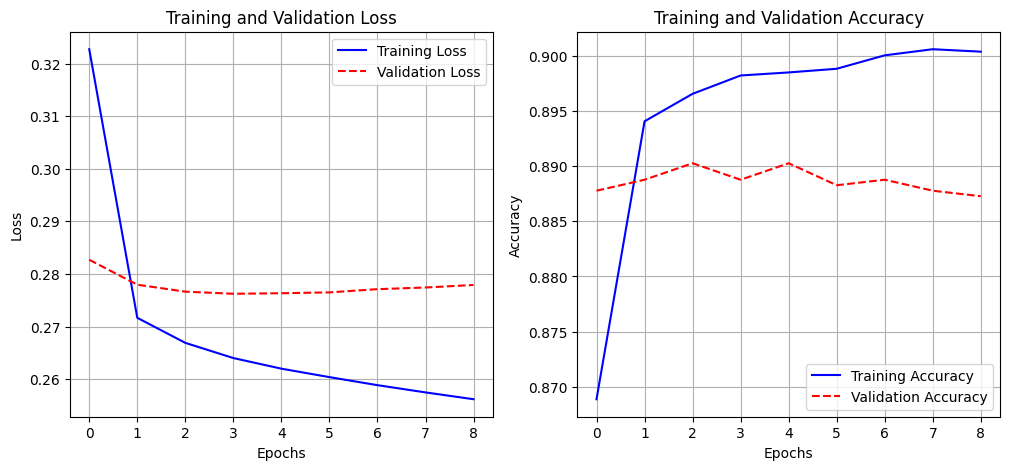

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network, accuracy score:  0.89
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       749
           1       0.92      0.96      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.73      0.76      5012
weighted avg       0.88      0.89      0.88      5012

Neural Netowrk AUC: 0.76


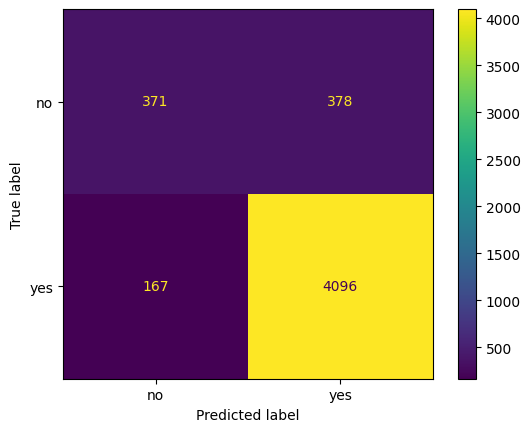

In [ ]:
y_pred = (model_base.predict(X_test_scaled) > 0.5).astype(int)

cr_nn_base_1 = classification_report(y_test, y_pred)
print("Neural Network, accuracy score: ", np.round(accuracy_score(y_test, y_pred),2))
print(cr_nn_base_1)

y_prob = model.predict(X_test).flatten()
auc_score_nn_base_1 = roc_auc_score(y_test, y_prob)
print("Neural Netowrk AUC:", np.round(auc_score_nn_base_1, 2))

cm_nn_base_1 = confusion_matrix(y_test, y_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_1, display_labels=["no","yes"])
cfmd.plot()
plt.show()

The base neural network model shows worse performance with respect to the XGBOOST.

To try to otpimize the performance of the model, a grid search is implemented.
The parameters considered in the optimization are:

- Learning rate
- Number of neuron of hidden layer 1, while the number of neuron for the second hidden layer are half of those of hid layer 1 --> this is a semplification but it can help to reduce the computation time
- Activation functions of the hidden layer
- Optimizer (Adam, RMSProp)

An early stopping has been implemented with a patience of 5, to avoid having too much overfitting.

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
n_neuron_1 = [32, 64, 128]
activations = ['relu', 'tanh','sigmoid']
optimizer_types = ['adam', 'rmsprop']
results = []

for optimizer in optimizer_types:
    for lr in learning_rates:
        for activation in activations:
            for n_neuron in n_neuron_1:
                n_neuron_2 = int(n_neuron / 2)
                model = create_model(learning_rate=lr, activation=activation, n_neuron_1=n_neuron, n_neuron_2=n_neuron_2, optimizer_type=optimizer)
                accuracy, precision, recall, history = train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, batch_size=64)

                cr = classification_report(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                cm = confusion_matrix(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                auc = roc_auc_score(y_test, model.predict(X_test_scaled))

                results.append({
                    'learning_rate': lr,
                    'batch_size': 64,
                    'activation': activation,
                    'optimizer': optimizer,
                    'n_neuron_1': n_neuron,
                    'n_neuron_2': n_neuron_2,
                    'accuracy': accuracy,
                    'precision_class_0': precision[0],
                    'precision_class_1': precision[1],
                    'recall_class_0': recall[0],
                    'recall_class_1': recall[1],
                    'auc_score' : auc,
                    'classification_report': cr,
                    'confusion_matrix': cm
                })
                print(results[-1])

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 'batch_size': 64, 'activation': 'relu', 'optimizer': 'adam', 'n_neuron_1': 32, 'n_neuron_2': 16, 'accuracy': 0.9068597867632268, 'precision_class_0': 0.7340425531914894, 'precision_class_1': 0.9289766280916724, 'recall_class_0': 0.5694635488308115, 'recall_class_1': 0.9646559849198869, 'auc_score': 0.9063373877126637, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.73      0.57      0.64       727\n           1       0.93      0.96      0.95      4244\n\n    accuracy                           0.91      4971\n   macro avg       0.83      0.77      0.79      4971\nweighted avg       0.90      0.91      0.90      4971\n', 'confusion_matrix': array([[ 414,  313],
       [ 150, 4094]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
156/156 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 92/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.1, 'batch_size': 64, 'activation': 'sigmoid', 'optimizer': 'adam', 'n_neuron_1': 128, 'n_neuron_2': 64, 'accuracy': 0.8537517602092134, 'precision_class_0': 0.0, 'precision_class_1': 0.8537517602092134, 'recall_class_0': 0.0, 'recall_class_1': 1.0, 'auc_score': 0.5, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       727\n           1       0.85      1.00      0.92      4244\n\n    accuracy                           0.85      4971\n   macro avg       0.43      0.50      0.46      4971\nweighted avg       0.73      0.85      0.79      4971\n', 'confusion_matrix': array([[   0,  727],
       [   0, 4244]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 'batch_size': 6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 96/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.1, 'batch_size': 64, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'n_neuron_1': 128, 'n_neuron_2': 64, 'accuracy': 0.8537517602092134, 'precision_class_0': 0.0, 'precision_class_1': 0.8537517602092134, 'recall_class_0': 0.0, 'recall_class_1': 1.0, 'auc_score': 0.837152896167354, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       727\n           1       0.85      1.00      0.92      4244\n\n    accuracy                           0.85      4971\n   macro avg       0.43      0.50      0.46      4971\nweighted avg       0.73      0.85      0.79      4971\n', 'confusion_matrix': array([[   0,  727],
       [   0, 4244]])}


In [ ]:
# During the grid search of the neural network, some NN models didn't predict any class 0 individual. For this reasons, these models are filtered out
results = [r for r in results if r['recall_class_0'] > 0]

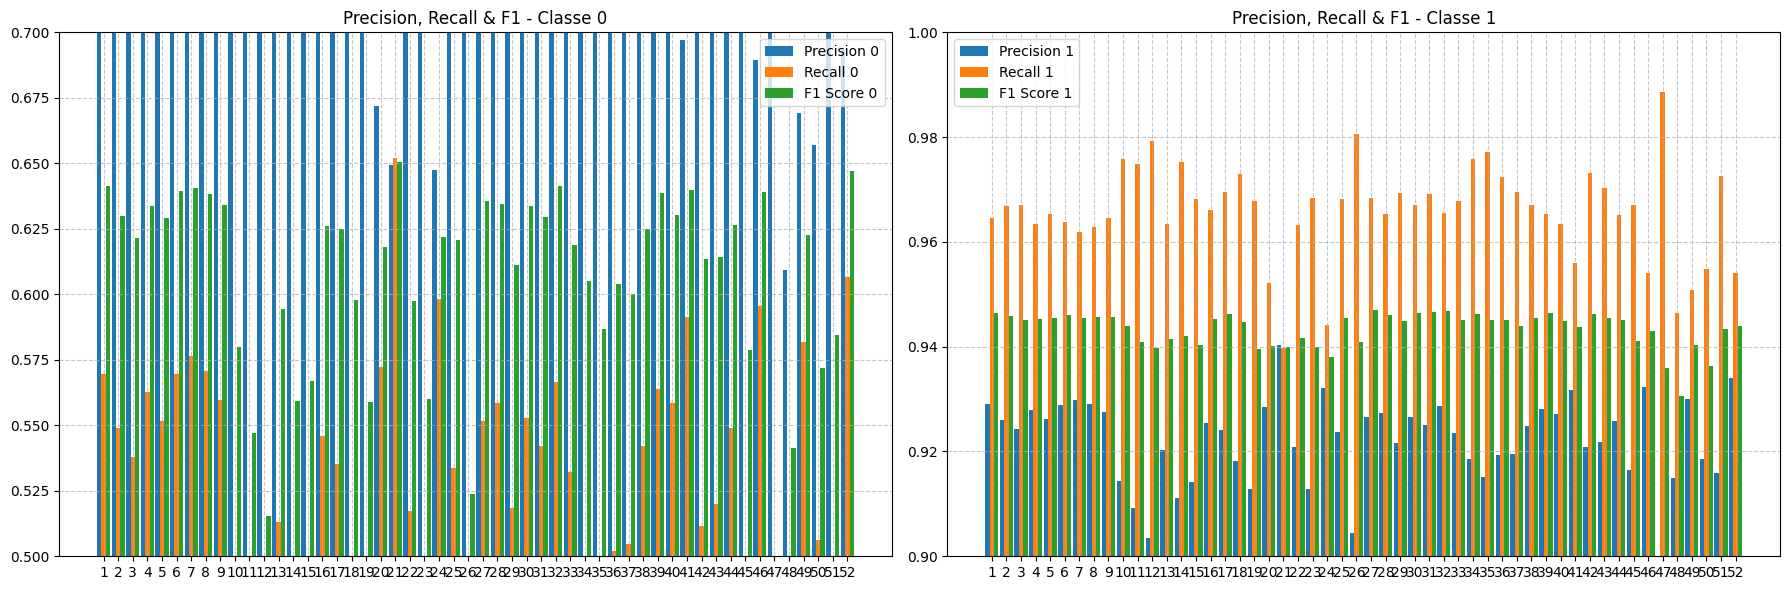

In [ ]:
precision_0 = [res["precision_class_0"] for res in results]
recall_0 = [res["recall_class_0"] for res in results]
precision_1 = [res["precision_class_1"] for res in results]
recall_1 = [res["recall_class_1"] for res in results]

f1_0 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_0, recall_0)]
f1_1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_1, recall_1)]

n = len(results)
x = np.arange(n)
bar_width = 0.3

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(x - bar_width, precision_0, bar_width, label="Precision 0")
axes[0].bar(x, recall_0, bar_width, label="Recall 0")
axes[0].bar(x + bar_width, f1_0, bar_width, label="F1 Score 0")
axes[0].set_title("Precision, Recall & F1 - Classe 0")
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, n+1))
axes[0].set_ylim(0.5, 0.7)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width, precision_1, bar_width, label="Precision 1")
axes[1].bar(x, recall_1, bar_width, label="Recall 1")
axes[1].bar(x + bar_width, f1_1, bar_width, label="F1 Score 1")
axes[1].set_title("Precision, Recall & F1 - Classe 1")
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, n+1))
axes[1].set_ylim(0.9, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


From the various network configurations, it can be observed that performance is quite sensitive to changes in hyperparameters. Unlike XGBoost, which showed much greater stability, the results here vary significantly depending on the chosen configuration. For this reason, instead of optimizing solely for recall of class 0, a more balanced approach was taken by considering both the harmonic F1 score across classes and the weighted F1 score.

The best model was selected based on the F1 score rather than just recall for class 0, as relying exclusively on recall could have led to an overly biased model, significantly reducing precision for both class 0 and class 1. Given the high variability in results, this compromise was necessary to ensure more reliable and generalizable predictions.

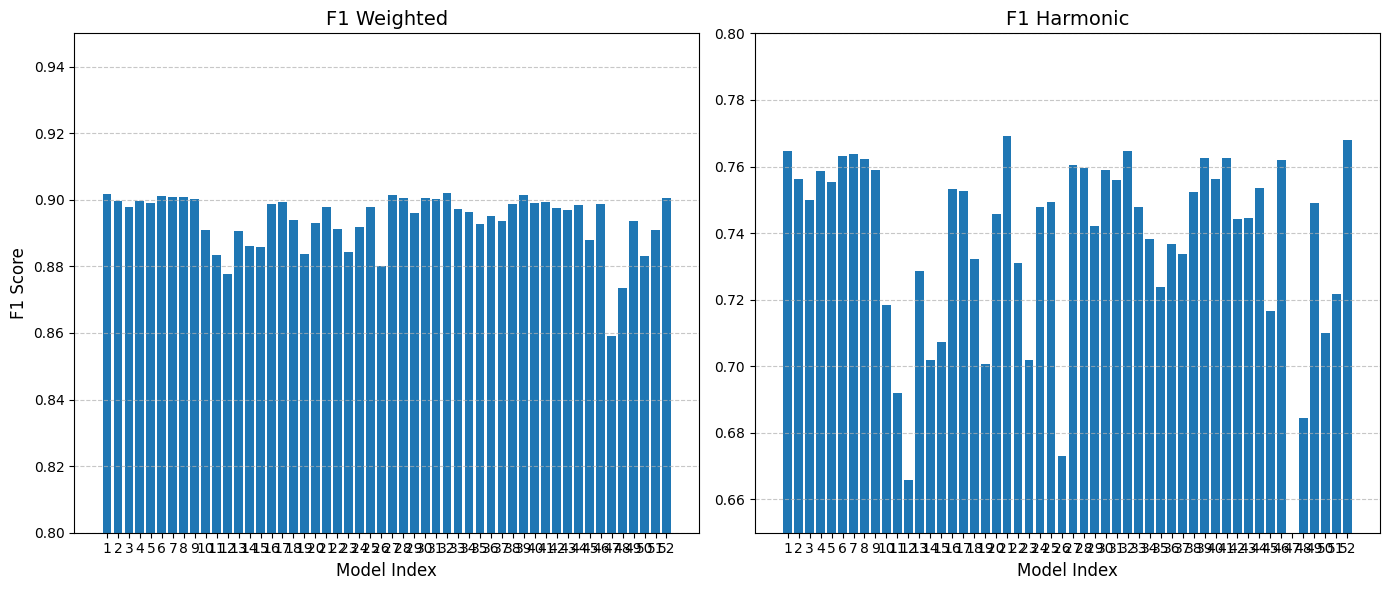

In [ ]:
f1_armonic = [(2 * f_0 * f_1) / (f_0 + f_1) for f_0, f_1 in zip(f1_0, f1_1)]
f1_weighted = [(y_test.value_counts()[0] * f_0 + y_test.value_counts()[1] * f_1) / (y_test.value_counts()[0] + y_test.value_counts()[1]) for f_0, f_1 in zip(f1_0, f1_1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(f1_weighted))

axes[0].bar(x, f1_weighted)
axes[0].set_title("F1 Weighted", fontsize=14)
axes[0].set_xlabel("Model Index", fontsize=12)
axes[0].set_ylabel("F1 Score", fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, len(f1_weighted) + 1))
axes[0].set_ylim(0.8, 0.95)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(x, f1_armonic)
axes[1].set_title("F1 Harmonic", fontsize=14)
axes[1].set_xlabel("Model Index", fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, len(f1_armonic) + 1))
axes[1].set_ylim(0.65, 0.8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


From the plots, it can be seen that the F1 weighted score is not too sensitive to the model, while the harmonic F1 score, which considers both classes, appears to be more useful.

Since the dataset is imbalanced, the weighted F1 score is heavily influenced by the majority class, making it less reliable in evaluating overall model performance. The harmonic F1 score, on the other hand, ensures that both classes contribute equally to the evaluation, preventing the model from being biased toward the dominant class.

Therefore, the best model is selected based on the harmonic F1 score.

In [ ]:
best_f1_armonic = 0

for i in range(len(f1_armonic)):
    if f1_armonic[i] > best_f1_armonic:
        best_f1_armonic = f1_armonic[i]
        best_f1_armonic_index = i


print('Best model configuration has been chosen to maximize the F1 armonic, which is for the best model', np.round(best_f1_armonic, 2), )
print("The configuration is:")
for key, value in results[best_f1_armonic_index].items():
    print(f"{key}: {value}")
nn_lr_opt = results[best_f1_armonic_index]['learning_rate']
nn_batch_size = results[best_f1_armonic_index]['batch_size']
nn_activation = results[best_f1_armonic_index]['activation']
nn_optimizer = results[best_f1_armonic_index]['optimizer']
n_neuron_1 = results[best_f1_armonic_index]['n_neuron_1']
n_neuron_2 = results[best_f1_armonic_index]['n_neuron_2']
auc_score_nn_best_1 = results[best_f1_armonic_index]['auc_score']
cm_nn_best_1 = results[best_f1_armonic_index]['confusion_matrix']
cr_nn_best_1 = results[best_f1_armonic_index]['classification_report']

Best model configuration has been chosen to maximize the F1 armonic, which is for the best model 0.77
The configuration is:
learning_rate: 0.1
batch_size: 64
activation: relu
optimizer: adam
n_neuron_1: 128
n_neuron_2: 64
accuracy: 0.8976061154697244
precision_class_0: 0.6493150684931507
precision_class_1: 0.9403442584296157
recall_class_0: 0.6519944979367263
recall_class_1: 0.939679547596607
auc_score: 0.8913196654683302
classification_report:               precision    recall  f1-score   support

           0       0.65      0.65      0.65       727
           1       0.94      0.94      0.94      4244

    accuracy                           0.90      4971
   macro avg       0.79      0.80      0.80      4971
weighted avg       0.90      0.90      0.90      4971

confusion_matrix: [[ 474  253]
 [ 256 3988]]


Classification report for the NN base model:
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       749
           1       0.92      0.96      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.73      0.76      5012
weighted avg       0.88      0.89      0.88      5012

Classification report for the NN optimal model:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       727
           1       0.94      0.94      0.94      4244

    accuracy                           0.90      4971
   macro avg       0.79      0.80      0.80      4971
weighted avg       0.90      0.90      0.90      4971

Neural Netowrk base AUC: 0.76
Neural Netowrk optimal AUC: 0.89


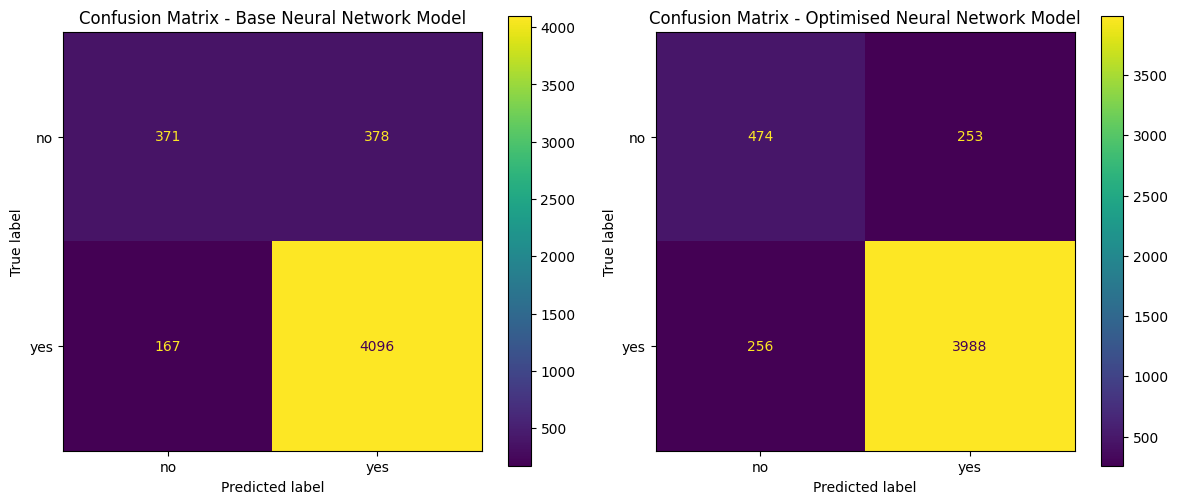

In [ ]:
print('Classification report for the NN base model:')
print(cr_nn_base_1)

print('Classification report for the NN optimal model:')
print(cr_nn_best_1)

print("Neural Netowrk base AUC:", np.round(auc_score_nn_base_1, 2))
print("Neural Netowrk optimal AUC:", np.round(auc_score_nn_best_1, 2))


cfmd_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_1, display_labels=["no","yes"])
cfmd_nn_opt = ConfusionMatrixDisplay(confusion_matrix=cm_nn_best_1, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Confusion Matrix - Base Neural Network Model")
cfmd.plot(ax=axes[0])

axes[1].set_title("Confusion Matrix - Optimised Neural Network Model")
cfmd_nn_opt.plot(ax=axes[1])

plt.tight_layout()
plt.show()



Comparing the baseline neural network model with the optimized one (which maximizes the harmonic F1 score), we observe a significant improvement in performance, especially for class 0. Although precision has slightly decreased, recall has increased substantially, allowing the model to identify a much higher number of at-risk students—critical for the stage 1 dataset. The F1 score for class 0 has improved considerably, rising from 0.58 to 0.61. Additionally, the AUC shows a marked improvement, increasing from 0.76 to 0.89. This significant boost in performance is largely due to the high sensitivity of neural networks to hyperparameter tuning.



# Stage 1.5 - XGBoost vs Neural Network

In this section the comparison of the optimal model based on XGBoost and neural network is shown.

Accuracy Report for the Best XGB Model - Stage 1 dataset
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       749
           1       0.93      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.76      0.78      5012
weighted avg       0.89      0.89      0.89      5012

-------------------------------------------------------
Accuracy Report for the Best NN Model - Stage 1 dataset
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       727
           1       0.94      0.94      0.94      4244

    accuracy                           0.90      4971
   macro avg       0.79      0.80      0.80      4971
weighted avg       0.90      0.90      0.90      4971

-------------------------------------------------------
AUC for the best XGB Model - Stage 1 dataset
0.87
-------------------------------------------------------
AUC for the bes

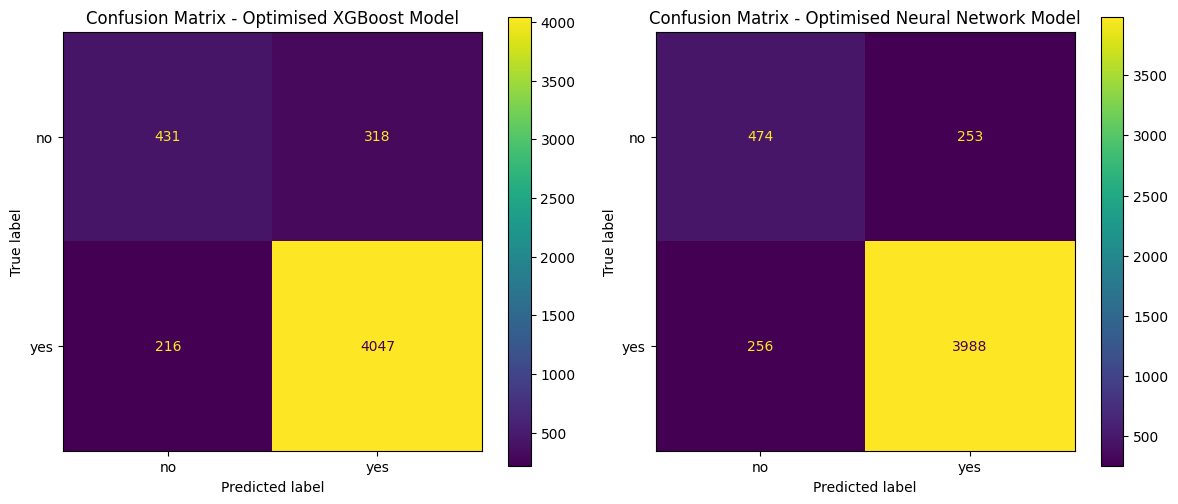

In [ ]:
print('Accuracy Report for the Best XGB Model - Stage 1 dataset')
print(cr_xbg_best_1)
print('-------------------------------------------------------')
print('Accuracy Report for the Best NN Model - Stage 1 dataset')
print(cr_nn_best_1)
print('-------------------------------------------------------')
print('AUC for the best XGB Model - Stage 1 dataset')
print(np.round(auc_score_xgb_best_1,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 1 dataset')
print(np.round(auc_score_nn_best_1,2))
print('-------------------------------------------------------')

cfmd_xgb_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best_1, display_labels=["no","yes"])


cfmd_nn_opt = ConfusionMatrixDisplay(confusion_matrix=cm_nn_best_1, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Confusion Matrix - Optimised XGBoost Model")
cfmd_xgb_opt.plot(ax=axes[0])

axes[1].set_title("Confusion Matrix - Optimised Neural Network Model")
cfmd_nn_opt.plot(ax=axes[1])

plt.tight_layout()
plt.show()

From the results obtained, it can be seen that the neural network model achieves a higher recall for class 0, which is the main parameter in consideteration. This comes at the cost of lower precision for class 0, as well as reduced precision and recall for class 1. The F1 score of the class 0 is higher with the neural network model.

Regarding the overall performance metrics, the weighted averages remain similar due to the higher prevalence of class 1, but it is important to highlight that F1 score avg goes from 0.89 XGBoost to 0.91 of the nn.

Additionally, both models exhibit similar accuracy, but this metric is less relevant given the imbalanced nature of the dataset. Finally, the XGBoost model shows a slightly higher AUC, indicating its superior ability to distinguish between the two classes.

# Stage 2 - Data

In [ ]:
# File URL
file_url = "path_to_your_dataset/dataset_name.csv"
df_2 = pd.read_csv(file_url)

In [ ]:
df_2.head()

CentreName  LearnerCode BookingType              LeadSource DiscountType  \
0  ISC_Aberdeen      2284932       Agent  Standard Agent Booking          NaN   
1  ISC_Aberdeen      2399500       Agent  Standard Agent Booking          NaN   
2  ISC_Aberdeen      2424946       Agent  Standard Agent Booking          NaN   
3  ISC_Aberdeen      2426583       Agent  Standard Agent Booking          NaN   
4  ISC_Aberdeen      2434674       Agent  Standard Agent Booking          NaN   

  DateofBirth Gender Nationality                          HomeState  \
0  13/01/1998   Male     Chinese  Jianye District; Jiangsu Province   
1   12/2/1998   Male     Chinese                                NaN   
2    7/4/2000   Male     Chinese                                NaN   
3  18/05/1999   Male     Chinese                                NaN   
4  19/04/1996   Male     Chinese                                NaN   

                 HomeCity             CourseLevel  \
0                 Nanjing             Pre-Masters   
1                   Xi'an              Foundation   
2                 Chengdu  International Year Two   
3  LIUYANG CITY ;CHANGSHA  International Year Two   
4                  Xiamen             Pre-Masters   

                                          CourseName  IsFirstIntake  \
0                       Business and Law Pre-Masters           True   
1   Life Sciences Undergraduate Foundation Programme          False   
2  Business Management and Finance International ...          False   
3  Business Management and Finance International ...           True   
4                       Business and Law Pre-Masters           True   

  CompletedCourse                              ProgressionDegree  \
0             Yes  Msc Econ Accounting and Investment Management   
1             Yes                        BSc Biological Sciences   
2             Yes                                     MA Finance   
3             Yes                         MA Business Management   
4             Yes          MSc International Business Management   

    ProgressionUniversity  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  
0  University of Aberdeen                     NaN                       NaN  
1  University of Aberdeen                    93.0                       5.0  
2  University of Aberdeen                    92.0                       6.0  
3  University of Aberdeen                    67.0                      15.0  
4  University of Aberdeen                     NaN                       NaN

# Stage 2.1 - EDA and Feature Engineering

**Stage 2: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (>200)
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.



In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Progre

In [ ]:
# Drop of the column LearnerCode since it's not useful.The Homestate  has been deleted since it has more the 50% of data missing
df_cleaned = df_2.drop(columns=['LearnerCode','HomeState'],axis=1)

In [ ]:
# Date of birth column utilised to built the age column and then drop of the first one
# I use as reference day the 01/01/2025
ref_date = pd.to_datetime("2025-01-01")
df_cleaned["DateofBirth"] = pd.to_datetime(df_cleaned["DateofBirth"], format="%d/%m/%Y")
df_cleaned["Age"] = (ref_date - df_cleaned["DateofBirth"]).dt.days // 365
df_cleaned.drop(columns=["DateofBirth"], inplace=True)

In [ ]:
# Here the features with high cardinality have been deleted (categorical features with more than 200 unique values)
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and df_cleaned[col].nunique() > 200:
        print(f"{col} has been deleted since it has {df_cleaned[col].nunique()} unique values")
        df_cleaned.drop(columns=[col], inplace=True)

HomeCity has been deleted since it has 5881 unique values
ProgressionDegree has been deleted since it has 2616 unique values


In [ ]:
#The DiscountType feature indicates whether a discount was applied (NaN if no discount) and the type of discount received
# Since the type of discount seems to be not relevant, I decided to create a binary feature called "HasDiscount" which indicates wheter a discount has been applied or not, regardless of the discount type
df_cleaned["HasDiscount"] = df_cleaned["DiscountType"].notna().astype(int)
df_cleaned.drop(columns=["DiscountType"], inplace=True)

In [ ]:
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel                                         CourseName  \
0             Pre-Masters                       Business and Law Pre-Masters   
1              Foundation   Life Sciences Undergraduate Foundation Programme   
2  International Year Two  Business Management and Finance International ...   
3  International Year Two  Business Management and Finance International ...   
4             Pre-Masters                       Business and Law Pre-Masters   

   IsFirstIntake CompletedCourse   ProgressionUniversity  \
0           True             Yes  University of Aberdeen   
1          False             Yes  University of Aberdeen   
2          False             Yes  University of Aberdeen   
3           True             Yes  University of Aberdeen   
4           True             Yes  University of Aberdeen   

   AuthorisedAbsenceCount  UnauthorisedAbsenceCount  Age  HasDiscount  
0                     NaN                       NaN   26            0  
1                    93.0                       5.0   26            0  
2                    92.0                       6.0   24            0  
3                    67.0                      15.0   25            0  
4                     NaN                       NaN   28            0

In [ ]:
for col in df_cleaned.columns:
      print(f"{col} has {df_cleaned[col].nunique()} unique values")

CentreName has 19 unique values
BookingType has 2 unique values
LeadSource has 7 unique values
Gender has 2 unique values
Nationality has 151 unique values
CourseLevel has 4 unique values
CourseName has 172 unique values
IsFirstIntake has 2 unique values
CompletedCourse has 2 unique values
ProgressionUniversity has 40 unique values
AuthorisedAbsenceCount has 190 unique values
UnauthorisedAbsenceCount has 258 unique values
Age has 38 unique values
HasDiscount has 2 unique values


In [ ]:
df_cleaned['CourseName'].unique()

array(['Business and Law Pre-Masters',
       'Life Sciences Undergraduate Foundation Programme',
       'Business Management and Finance International Year Two',
       'Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme',
       'Physical Sciences and Engineering Undergraduate Foundation Programme',
       'Life Sciences - pathway to Medicine Undergraduate Foundation Programme',
       'Science and Engineering Pre-Masters',
       'Humanities; Law and Social Science Undergraduate Foundation Programme',
       'Business and Law Pre-Masters (ICAS)',
       'Business Management and Finance International Year Two (ICAS)',
       'Computing Science International Year Two (ICAS)',
       'Science and Engineering Pre-Masters (ICAS)',
       'Engineering; Physical Sciences and Architecture International Foundation Year',
       'Health; Medical and Life Sciences International Foundation Year',
       'Business; Economics; Accounting and Finance International F

Once the dataset was cleaned it had 14 features. 3 of these features seem to be problematic since they have a lot of unique values, and the encoding applied to these should generate a too large dataset with a lot of columns who are carrying low information.

The CourseName feature has been treated to extract relevant information. In particular, a deeper analysis showed that some words are recurrent (like 'Business', 'Finance', 'Accounting' for the economics macro area of studying) and they can be use to subgroup some macro area of studying, leaving the course level info in its own specific feature.

In [ ]:
df_cleaned['StudyArea'] = None
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Mathematics', na=False), 'StudyArea'] = 'Mathematics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Arts|Art', na=False), 'StudyArea'] = 'Arts'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Engineering', na=False), 'StudyArea'] = 'Engineering'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Health', na=False), 'StudyArea'] = 'Health'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Science|Sciences', na=False), 'StudyArea'] = 'Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Computer|Comp', na=False), 'StudyArea'] = 'Computer Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Social', na=False), 'StudyArea'] = 'Social'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business|Finance|Accounting|Management|Economics', na=False), 'StudyArea'] = 'Economics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Relations', na=False), 'StudyArea'] = 'International Relations'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Media', na=False), 'StudyArea'] = 'Media'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business', na=False) &
               df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law and Business'
df_cleaned['StudyArea'] = df_cleaned['StudyArea'].fillna('Other')

In [ ]:
df_cleaned['StudyArea'].value_counts()


StudyArea
Economics                  11993
Science                     4341
Computer Science            2906
Law and Business            2794
Law                         1136
Media                        986
Social                       345
International Relations      232
Engineering                  214
Other                         90
Mathematics                   22
Name: count, dtype: int64

Even though there is likely some overlap between columns, this approach improves data quality by reducing the original feature to far fewer subgroups. Otherwise, using the raw CourseName column would have led to an excessive number of features during one-hot encoding.

In [ ]:
df_cleaned.drop(columns=["CourseName"], inplace=True)

The nationality feature has been treated to subgroup the most represented nationality to reduce the number of unique values.

In [ ]:
tot = 0
most_represented_nation = []
for nation in df_cleaned['Nationality'].unique():
    if (df_cleaned['Nationality'] == nation).sum() > 250:
        tot = tot + (df_cleaned['Nationality'] == nation).sum()
        print(f"{nation} has {df_cleaned['Nationality'].value_counts()[nation]} students")
        most_represented_nation.append(nation)

print(f'The most represented nationality are {len(most_represented_nation)} and they represent {np.around(100*tot/df_cleaned.shape[0],2)} % of total students')

Chinese has 9042 students
Taiwanese has 363 students
Kuwaiti has 893 students
Qatari has 283 students
Egyptian has 640 students
Emirati has 415 students
Hong Kong Chinese has 1278 students
Nigerian has 309 students
Indian has 2072 students
Bangladeshi has 2007 students
Saudi has 762 students
Omani has 411 students
Pakistani has 1973 students
Algerian has 311 students
Korean has 252 students
The most represented nationality are 15 and they represent 83.85 % of total students


The analysis shows that the 15 most represented nationalities account for 83% of the students in the dataset. Therefore, the nationality feature has been reduced to 16 groups: the top 15 nationalities and a 16th group labeled "Other" for all remaining cases.

In [ ]:
df_cleaned['Nationality'] = df_cleaned['Nationality'].apply(lambda x: x if x in most_represented_nation else 'Other')
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel  IsFirstIntake CompletedCourse  \
0             Pre-Masters           True             Yes   
1              Foundation          False             Yes   
2  International Year Two          False             Yes   
3  International Year Two           True             Yes   
4             Pre-Masters           True             Yes   

    ProgressionUniversity  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  \
0  University of Aberdeen                     NaN                       NaN   
1  University of Aberdeen                    93.0                       5.0   
2  University of Aberdeen                    92.0                       6.0   
3  University of Aberdeen                    67.0                      15.0   
4  University of Aberdeen                     NaN                       NaN   

   Age  HasDiscount         StudyArea  
0   26            0  Law and Business  
1   26            0           Science  
2   24            0         Economics  
3   25            0         Economics  
4   28            0  Law and Business

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   BookingType               25059 non-null  object 
 2   LeadSource                25059 non-null  object 
 3   Gender                    25059 non-null  object 
 4   Nationality               25059 non-null  object 
 5   CourseLevel               25059 non-null  object 
 6   IsFirstIntake             25059 non-null  bool   
 7   CompletedCourse           25059 non-null  object 
 8   ProgressionUniversity     25059 non-null  object 
 9   AuthorisedAbsenceCount    24851 non-null  float64
 10  UnauthorisedAbsenceCount  24851 non-null  float64
 11  Age                       25059 non-null  int64  
 12  HasDiscount               25059 non-null  int64  
 13  StudyArea                 25059 non-null  object 
dtypes: boo

In [ ]:
tot_uni = 0
most_represented_prog_uni = []
for university in df_cleaned['ProgressionUniversity'].unique():
    if (df_cleaned['ProgressionUniversity'] == university).sum() > 100:
        print(university,(df_cleaned['ProgressionUniversity'] == university).sum())
        most_represented_prog_uni.append(university)
        tot_uni += 1

print('------------------------------------------------------------------------------')
print('The total number of unique Progression university is', df_cleaned['ProgressionUniversity'].nunique())
print('------------------------------------------------------------------------------')
print('If we consider just the progression university chosen by more than 100 they are',tot_uni)


University of Aberdeen 363
Cardiff University 687
University College Dublin 399
Durham University 2563
Coventry University London 931
Holland ISC - VU Amsterdam 106
University of Huddersfield 1781
Kingston University London 1892
Liverpool John Moores University 950
Lancaster University 1115
Leeds Beckett University 703
University of Leeds 1591
University of Lincoln 241
University of Strathclyde 677
Royal Holloway 1048
University of Sheffield International College 5877
University of Surrey 1051
University of Sussex 2103
Teesside University 632
------------------------------------------------------------------------------
The total number of unique Progression university is 40
------------------------------------------------------------------------------
If we consider just the progression university chosen by more than 100 they are 19


In the dataset there were 40 unique university chosen by the students (if eligible to progress). Since most of them have not been chosen by a multitude of students, it has been decided to use just the ones chosen by more than 100 students. All the others have been considered as 'Others'

In [ ]:
df_cleaned['ProgressionUniversity'] = df_cleaned['ProgressionUniversity'].apply(lambda x: x if x in most_represented_prog_uni else 'Other')
df_cleaned['ProgressionUniversity'].unique()

array(['University of Aberdeen', 'Cardiff University',
       'University College Dublin', 'Durham University', 'Other',
       'Coventry University London', 'Holland ISC - VU Amsterdam',
       'University of Huddersfield', 'Kingston University London',
       'Liverpool John Moores University', 'Lancaster University',
       'Leeds Beckett University', 'University of Leeds',
       'University of Lincoln', 'University of Strathclyde',
       'Royal Holloway', 'University of Sheffield International College',
       'University of Surrey', 'University of Sussex',
       'Teesside University'], dtype=object)

In [ ]:
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel  IsFirstIntake CompletedCourse  \
0             Pre-Masters           True             Yes   
1              Foundation          False             Yes   
2  International Year Two          False             Yes   
3  International Year Two           True             Yes   
4             Pre-Masters           True             Yes   

    ProgressionUniversity  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  \
0  University of Aberdeen                     NaN                       NaN   
1  University of Aberdeen                    93.0                       5.0   
2  University of Aberdeen                    92.0                       6.0   
3  University of Aberdeen                    67.0                      15.0   
4  University of Aberdeen                     NaN                       NaN   

   Age  HasDiscount         StudyArea  
0   26            0  Law and Business  
1   26            0           Science  
2   24            0         Economics  
3   25            0         Economics  
4   28            0  Law and Business

In [ ]:
df_cleaned['AuthorisedAbsenceCount'].isnull().sum()
df_cleaned['UnauthorisedAbsenceCount'].isnull().sum()

print(f'The column AuthorisedAbsenceCount has {df_cleaned["AuthorisedAbsenceCount"].isnull().sum()} missing values, which represents the {np.around(100*(df_cleaned["AuthorisedAbsenceCount"].isnull().sum())/df_cleaned.shape[0],2)}%')
print(f'The column UnauthorisedAbsenceCount has {df_cleaned["UnauthorisedAbsenceCount"].isnull().sum()} missing values, which represents the {np.around(100*(df_cleaned["UnauthorisedAbsenceCount"].isnull().sum())/df_cleaned.shape[0],2)}%')


The column AuthorisedAbsenceCount has 208 missing values, which represents the 0.83%
The column UnauthorisedAbsenceCount has 208 missing values, which represents the 0.83%


Since the number of null rows in the two features related to authorised and unauthorised features is relatively small (2%), these rows have been removed.

In [ ]:
df_cleaned_filt = df_cleaned.copy()
df_cleaned_filt = df_cleaned_filt.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
df_cleaned_filt.shape

(24851, 14)

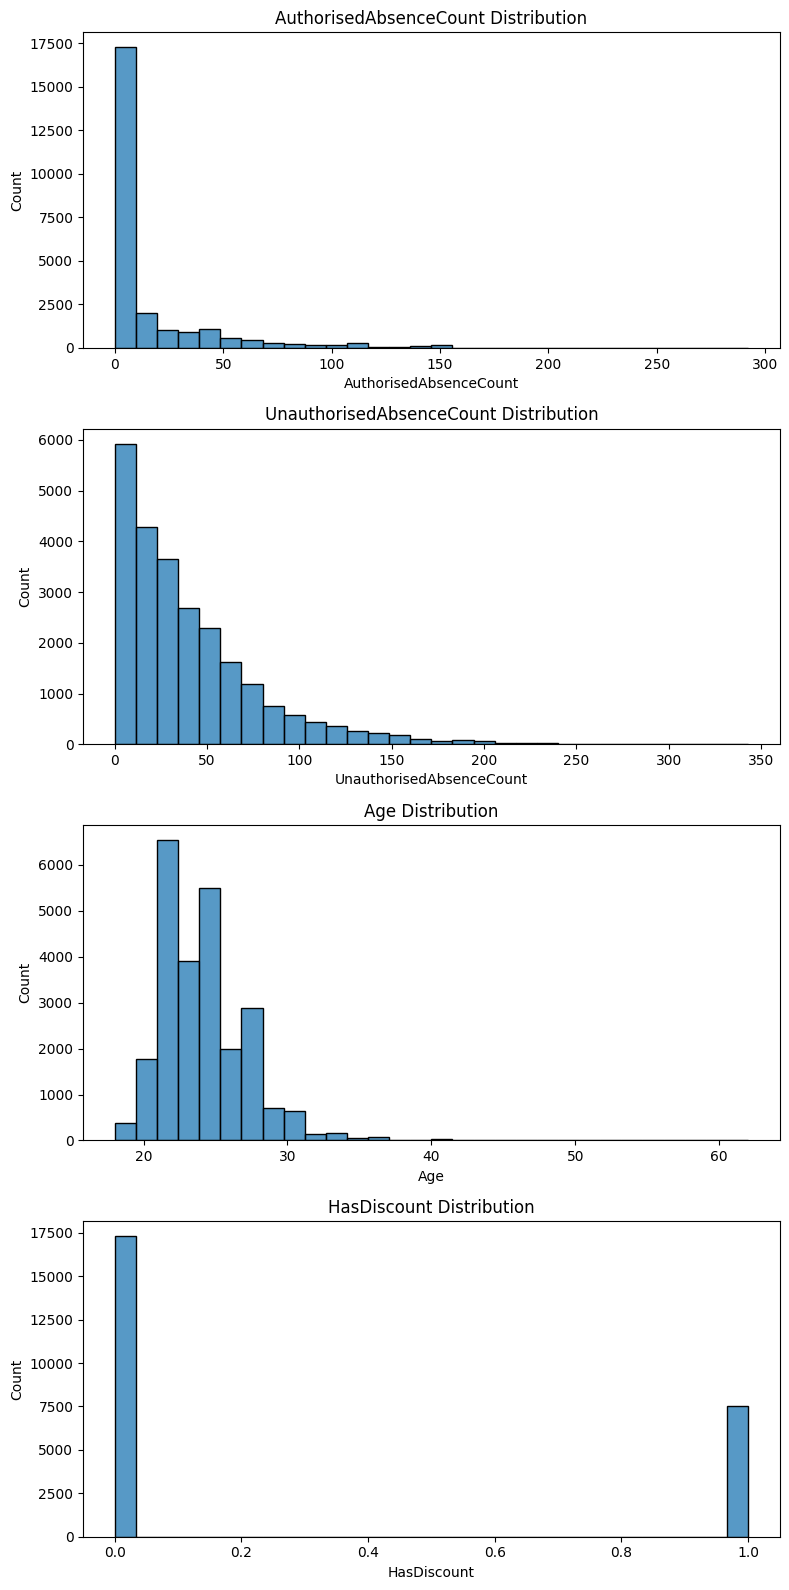

In [ ]:
numerical_features = df_cleaned_filt.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(8, 4 * len(numerical_features)))

for ax, feature in zip(axes, numerical_features):
    sns.histplot(df_cleaned_filt[feature], bins=30, kde=False, ax=ax)
    ax.set_title(f"{feature} Distribution")

plt.tight_layout()
plt.show()

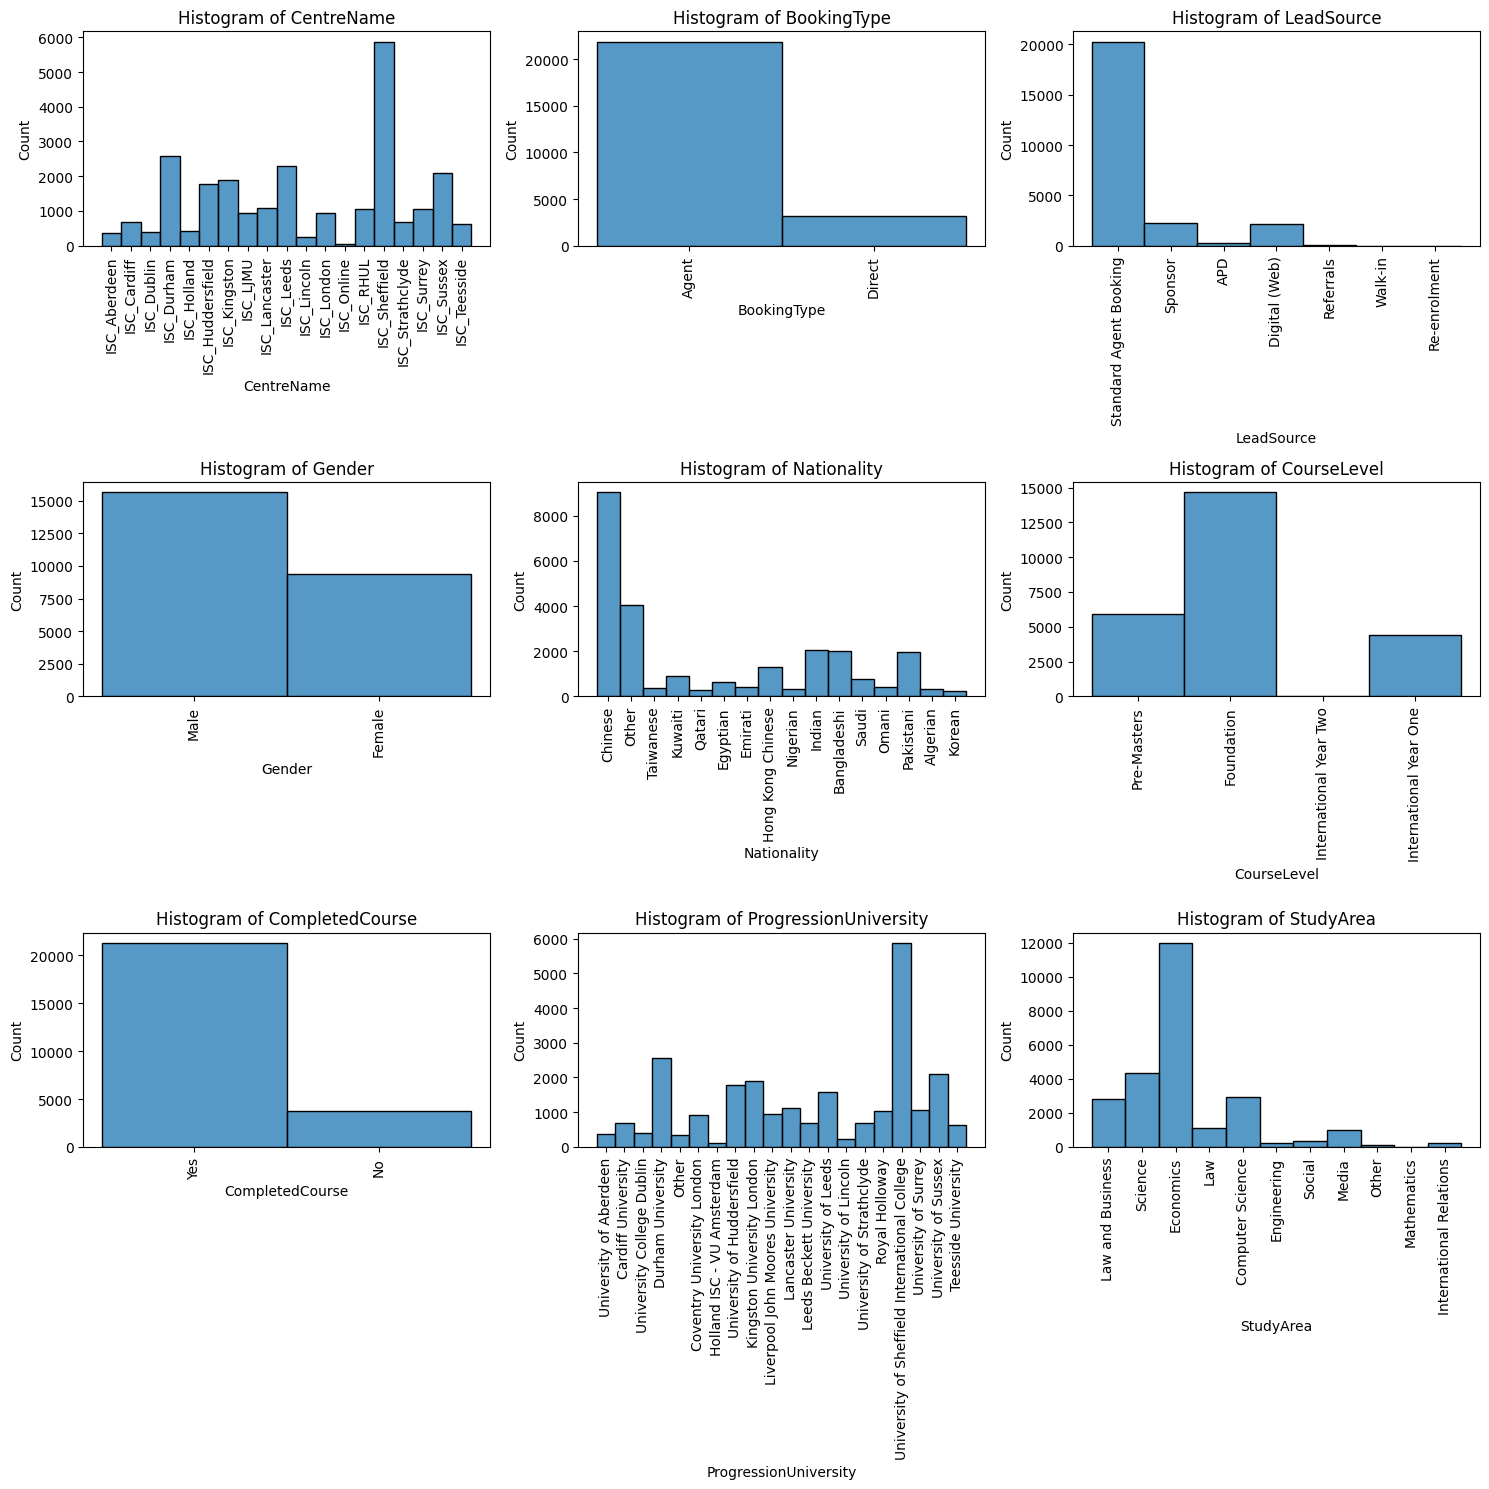

In [ ]:
object_cols = df_cleaned.select_dtypes(include='object').columns

# Calculate the number of rows and columns for subplots
num_plots = len(object_cols)
num_rows = (num_plots + 2) // 3  # Ensure enough rows for all plots
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through object columns and create histograms
for i, col in enumerate(object_cols):
  sns.histplot(df_cleaned[col], kde=False, ax=axes[i]) # kde=False to remove the kernel density estimation
  axes[i].set_title(f'Histogram of {col}')
  axes[i].tick_params(axis='x',rotation = 90) # Rotate x-axis labels for readability

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()

# Stage 2.2 - Encoding

In this section encoding is applied:
- Ordinal encoding wheter the feature's order matter
- One hot encoding wheter the fature's order doesn't matter

Looking at the dataset, it seems that the only ordinal variable is CourseLevel, since the order (Year one or year two) is important, and for this feature it has been decided to apply ordinal encodinge. For all the others, I decided to apply one hot encoding.

In [ ]:
df_cleaned_filt['CourseLevel'].unique()

array(['Foundation', 'International Year Two', 'Pre-Masters',
       'International Year One'], dtype=object)

In [ ]:
# The IsFirstIntake column is modified to be a numerical column (1,0)
df_cleaned_filt['IsFirstIntake'] = df_cleaned_filt['IsFirstIntake'].astype(int)

In [ ]:
order_mapping = {
    'Foundation': 0,
    'International Year One': 1,
    'International Year Two': 2,
    'Pre-Masters': 3
}
df_encoded = df_cleaned_filt.copy()
df_encoded['CourseLevel_encoded'] = df_cleaned_filt['CourseLevel'].map(order_mapping)
df_encoded.drop(columns=['CourseLevel'], inplace=True)


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24851 entries, 1 to 25058
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                24851 non-null  object 
 1   BookingType               24851 non-null  object 
 2   LeadSource                24851 non-null  object 
 3   Gender                    24851 non-null  object 
 4   Nationality               24851 non-null  object 
 5   IsFirstIntake             24851 non-null  int64  
 6   CompletedCourse           24851 non-null  object 
 7   ProgressionUniversity     24851 non-null  object 
 8   AuthorisedAbsenceCount    24851 non-null  float64
 9   UnauthorisedAbsenceCount  24851 non-null  float64
 10  Age                       24851 non-null  int64  
 11  HasDiscount               24851 non-null  int64  
 12  StudyArea                 24851 non-null  object 
 13  CourseLevel_encoded       24851 non-null  int64  
dtypes: float64(

In [ ]:
# For these columns where the subgroups were created, instead of deleting the first occurence, it has been deleted explicitly the column which contains the 'Other'. This to ensure a bettere explainability later on.
df_encoded = pd.get_dummies(df_encoded, columns=['Nationality', 'StudyArea','ProgressionUniversity'])
df_encoded = df_encoded.drop(columns=['Nationality_Other', 'StudyArea_Other','ProgressionUniversity_Other'])

In [ ]:
# Here I have to do a further modification to delete the column StudyArea_Law and Business which is redundant and put its information in the Law column and Economics column
df_encoded['StudyArea_Law'] |= df_encoded['StudyArea_Law and Business']
df_encoded['StudyArea_Economics'] |= df_encoded['StudyArea_Law and Business']
df_encoded.drop(columns=['StudyArea_Law and Business'], inplace=True)

In [ ]:
# For all the other categorical features, it has been applied one-hot encoding, deleting the first column
df_encoded = pd.get_dummies(df_encoded, columns=df_encoded.select_dtypes(include=['object']).columns, drop_first=True)
df_encoded.shape

(24851, 76)

In [ ]:
# In this cell all the boolean type columns are modified to have numerical values
for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype(int)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24851 entries, 1 to 25058
Data columns (total 76 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   IsFirstIntake                                                        24851 non-null  int64  
 1   AuthorisedAbsenceCount                                               24851 non-null  float64
 2   UnauthorisedAbsenceCount                                             24851 non-null  float64
 3   Age                                                                  24851 non-null  int64  
 4   HasDiscount                                                          24851 non-null  int64  
 5   CourseLevel_encoded                                                  24851 non-null  int64  
 6   Nationality_Algerian                                                 24851 non-null  int64  
 7   Nationali

In [ ]:
X = df_encoded.drop(columns=['CompletedCourse_Yes'])
y = df_encoded['CompletedCourse_Yes']
y.name = 'target'

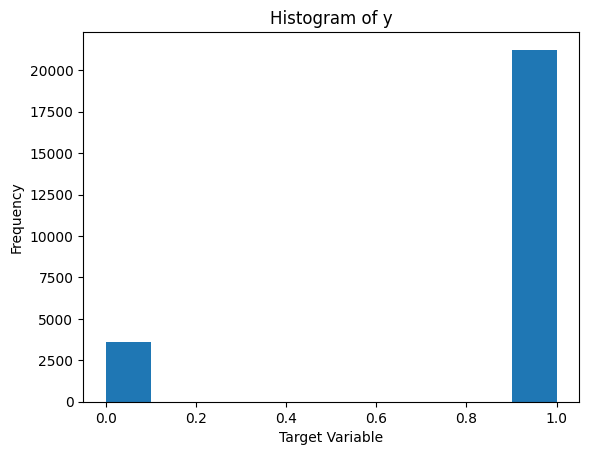

The dataset is composed of 85.5 % of students who completed the course and 14.5 who did not 


In [ ]:
plt.hist(y)
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Histogram of y')
plt.show()

print(f'The dataset is composed of {round(100*y.value_counts()[1]/y.shape[0],1)} % of students who completed the course and {round(100*y.value_counts()[0]/y.shape[0],1)} who did not ')


The distribution of output values reveals a class imbalance in the dataset. This suggests that standard accuracy may not be a reliable evaluation metric. Instead, metrics like AUC-ROC, precision-recall curves, and F1-score should be considered to better assess the model's performance, especially in handling minority classes.

In [ ]:
df_encoded.describe()

IsFirstIntake  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  \
count   24851.000000            24851.000000              24851.000000   
mean        0.120035               15.120639                 40.491892   
std         0.325009               28.918253                 39.029384   
min         0.000000                0.000000                  0.000000   
25%         0.000000                0.000000                 12.000000   
50%         0.000000                1.000000                 29.000000   
75%         0.000000               15.000000                 56.000000   
max         1.000000              292.000000                343.000000   

                Age   HasDiscount  CourseLevel_encoded  Nationality_Algerian  \
count  24851.000000  24851.000000         24851.000000          24851.000000   
mean      24.033077      0.303328             0.883385              0.012434   
std        3.161557      0.459705             1.230008              0.110815   
min       18.000000      0.000000             0.000000              0.000000   
25%       22.000000      0.000000             0.000000              0.000000   
50%       23.000000      0.000000             0.000000              0.000000   
75%       26.000000      1.000000             1.000000              0.000000   
max       62.000000      1.000000             3.000000              1.000000   

       Nationality_Bangladeshi  Nationality_Chinese  Nationality_Egyptian  \
count             24851.000000         24851.000000          24851.000000   
mean                  0.079232             0.362521              0.025633   
std                   0.270106             0.480738              0.158040   
min                   0.000000             0.000000              0.000000   
25%                   0.000000             0.000000              0.000000   
50%                   0.000000             0.000000              0.000000   
75%                   0.000000             1.000000              0.000000   
max                   1.000000             1.000000              1.000000   

       ...  CentreName_ISC_Teesside  BookingType_Direct  \
count  ...             24851.000000        24851.000000   
mean   ...                 0.024667            0.127319   
std    ...                 0.155111            0.333336   
min    ...                 0.000000            0.000000   
25%    ...                 0.000000            0.000000   
50%    ...                 0.000000            0.000000   
75%    ...                 0.000000            0.000000   
max    ...                 1.000000            1.000000   

       LeadSource_Digital (Web)  LeadSource_Re-enrolment  \
count              24851.000000             24851.000000   
mean                   0.084745                 0.000121   
std                    0.278508                 0.010987   
min                    0.000000                 0.000000   
25%                    0.000000                 0.000000   
50%                    0.000000                 0.000000   
75%                    0.000000                 0.000000   
max                    1.000000                 1.000000   

       LeadSource_Referrals  LeadSource_Sponsor  \
count          24851.000000        24851.000000   
mean               0.004708            0.090942   
std                0.068455            0.287532   
min                0.000000            0.000000   
25%                0.000000            0.000000   
50%                0.000000            0.000000   
75%                0.000000            0.000000   
max                1.000000            1.000000   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in   Gender_Male  \
count                        24851.00000        24851.000000  24851.000000   
mean                             0.80878            0.000845      0.623637   
std                              0.39327            0.029058      0.484483   
min                              0.00000            0.000000      0.000000   
25

# Stage 2.3 - XGBoost Algorithm

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0],X_test.shape[0])

19880 4971


XGBoost Model Accuracy:  0.91
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       727
           1       0.93      0.97      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.84      0.78      0.80      4971
weighted avg       0.90      0.91      0.91      4971

XGBoost Model AUC: 0.92


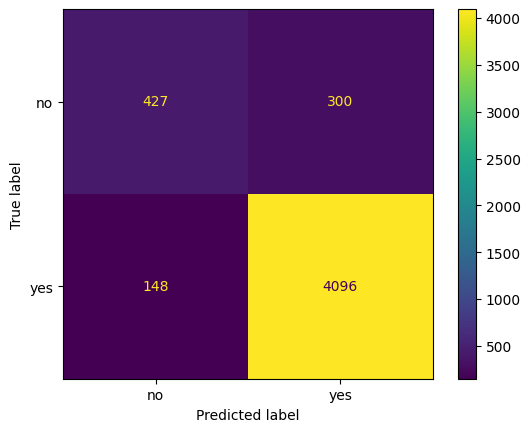

In [ ]:
xg_model_base_2 = xgb.XGBClassifier(random_state=42)
xg_model_base_2.fit(X_train, y_train)

# Model evaluation
predictions = xg_model_base_2.predict(X_test)
cr_xbg_base_2 = classification_report(y_test, predictions)
print("XGBoost Model Accuracy: ", np.round(accuracy_score(y_test, predictions),2))
print(cr_xbg_base_2)

y_prob = xg_model_base_2.predict_proba(X_test)[:, 1]
auc_score_xgb_base_2 = roc_auc_score(y_test, y_prob)
print("XGBoost Model AUC:", np.round(auc_score_xgb_base_2, 2))


cm_xgb_base_2 = confusion_matrix(y_test, predictions)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_1, display_labels=["no","yes"])
cfmd.plot()
plt.show()

The model of XGBoost trained on the dataset of the Stage 2 shows better performance than the same model run on the dataset of the stage 1. In particular, the precision and recall of the class 0 are higher, leading to an increase of the F1 score of this class (underrepresented).

To improve the model's performance, a grid search is performed.

The parameters considered in the optimization loop are:

- Max depth
- Learning rate
- Number of estimators

In [ ]:
# Hash map of parameters to test
param_grid = {
    "learning_rate": [0.05,0.03, 0.01],
    "max_depth": [4, 6, 8, 10]
}

# Start e end per n_estimators
start = 100
end = 1500

def increment_fn(n):
    if n > 400:
        return 200
    else:
        return 100

increment = increment_fn(start)

# Results List
results = []

# Main loop
for lr in param_grid["learning_rate"]:
    for depth in param_grid["max_depth"]:
        n = start
        while n <= end:
            model = xgb.XGBClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n,
                random_state=42, eval_metric='logloss'
            )
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

            # metrics calculation
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            report = classification_report(y_test, y_pred, output_dict=True)

            train_loss = log_loss(y_train, model.predict_proba(X_train))
            test_loss = log_loss(y_test, y_prob)

            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)
            # Salvataggio delle metriche
            metrics = {
                    "learning_rate": lr,
                    "max_depth": depth,
                    "n_estimators": n,
                    "train_loss": train_loss,
                    "accuracy": report["accuracy"],
                    "precision_0": report["0"]["precision"],
                    "recall_0": report["0"]["recall"],
                    "f1_0": report["0"]["f1-score"],
                    "precision_1": report["1"]["precision"],
                    "recall_1": report["1"]["recall"],
                    "f1_1": report["1"]["f1-score"],
                    "auc": roc_auc_score(y_test, y_prob),
                    "test_loss": test_loss,
                    "confusion_matrix": cm,
                    "classification_report": cr
                }


            results.append(metrics)
            increment = increment_fn(n)
            prev_test_loss = test_loss
            n += increment
            print(f"With  lr = {lr}and max depth = {depth} and {n} number of estimators the losses are:")
            print(f'Training loss = {np.round(train_loss,3)}, Test loss = Training loss = {np.round(test_loss,3)}')
            print('------------------------------------------------------------')


With  lr = 0.05and max depth = 4 and 200 number of estimators the losses are:
Training loss = 0.229, Test loss = Training loss = 0.24
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 300 number of estimators the losses are:
Training loss = 0.216, Test loss = Training loss = 0.233
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 400 number of estimators the losses are:
Training loss = 0.209, Test loss = Training loss = 0.231
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 500 number of estimators the losses are:
Training loss = 0.203, Test loss = Training loss = 0.229
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 700 number of estimators the losses are:
Training loss = 0.199, Test loss = Training loss = 0.228
------------------------------------------------------------
With  lr = 0.05and ma

In [ ]:
len(results)

120

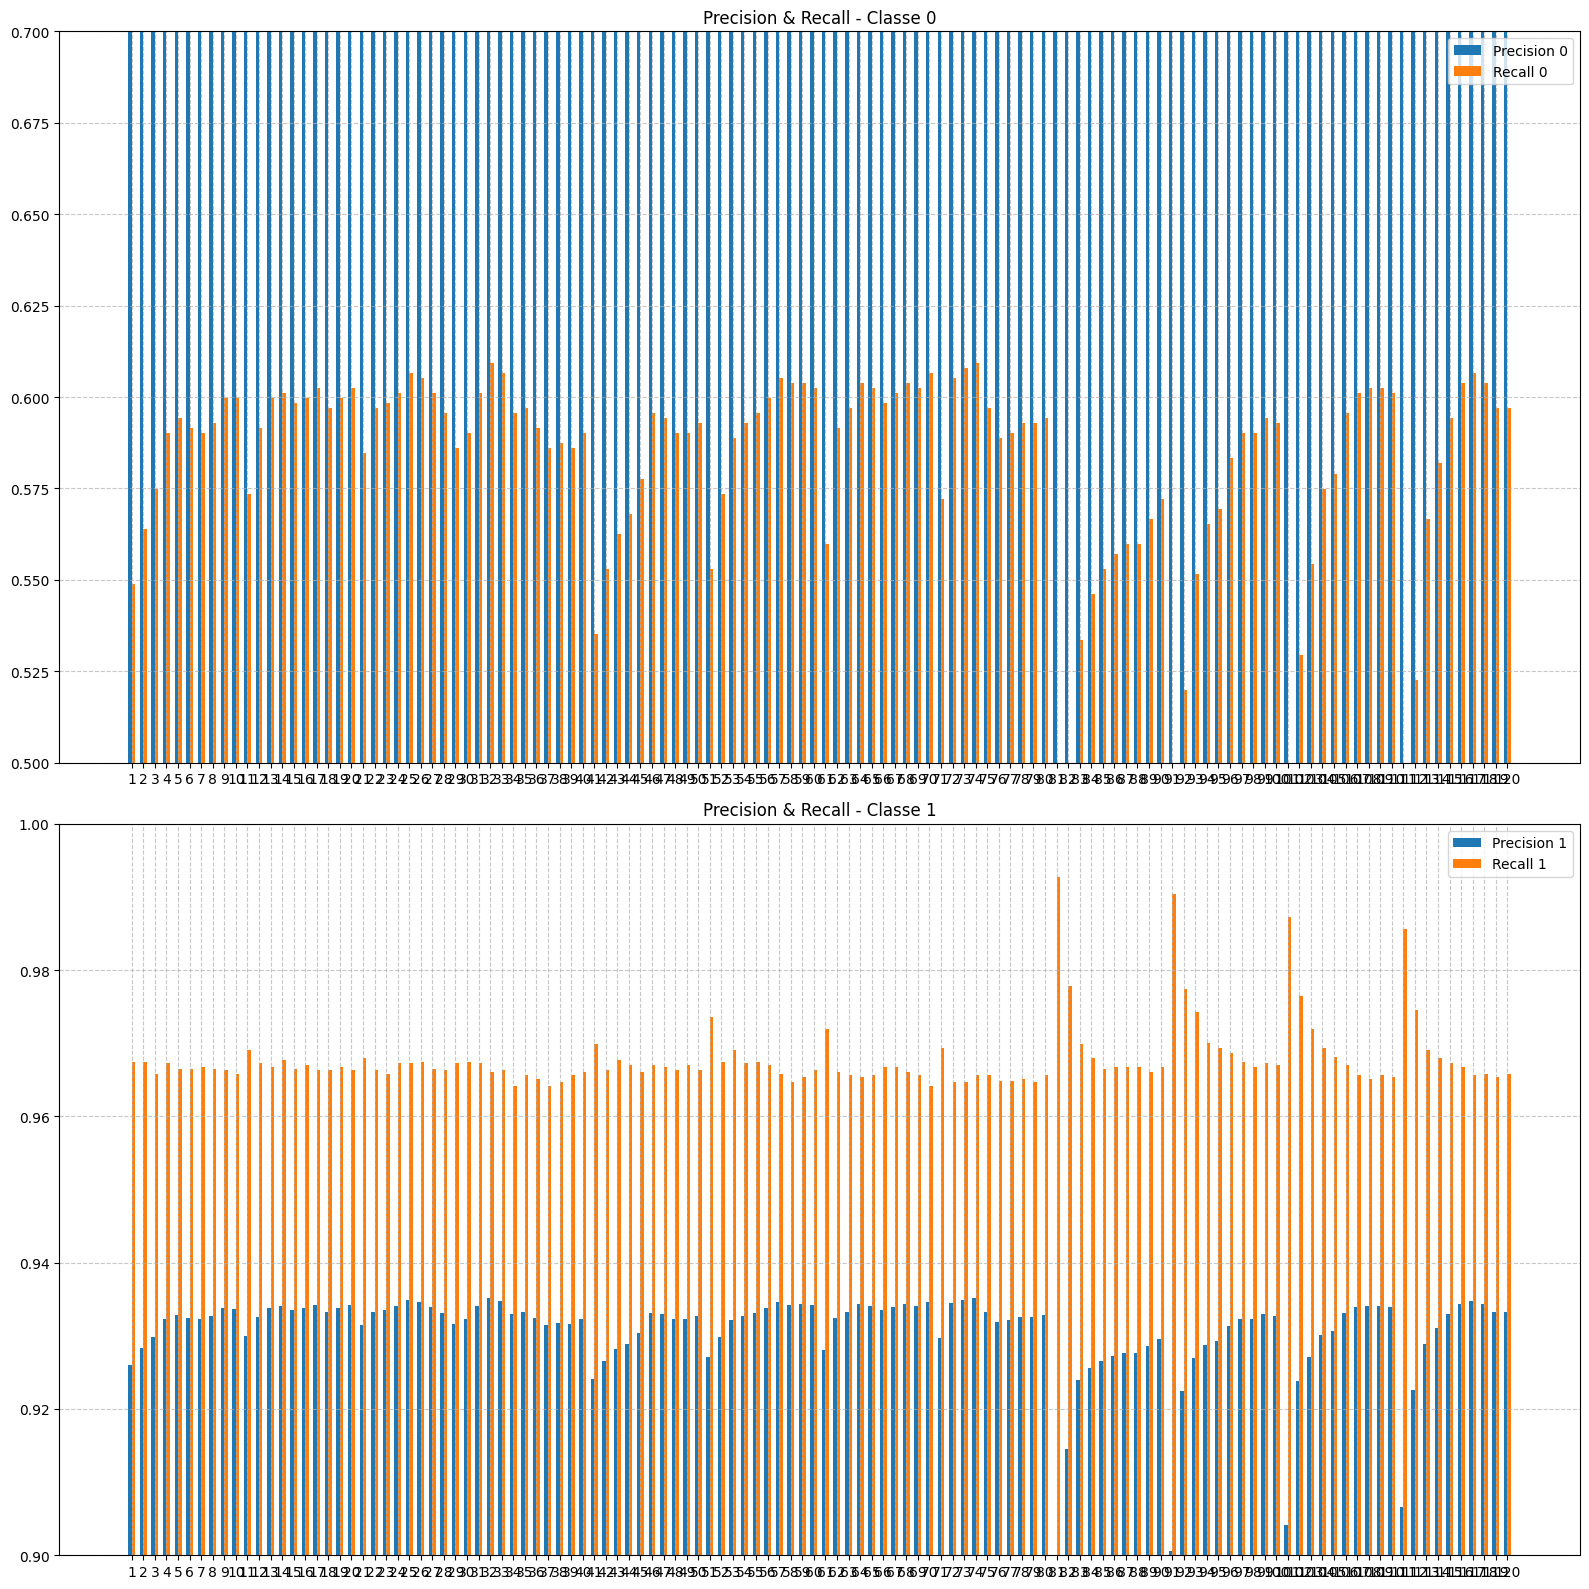

In [ ]:
precision_0 = [r["precision_0"] for r in results]
recall_0 = [r["recall_0"] for r in results]
precision_1 = [r["precision_1"] for r in results]
recall_1 = [r["recall_1"] for r in results]

x = np.arange(len(results))

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

axes[0].bar(x - bar_width / 2, precision_0, bar_width, label="Precision 0")
axes[0].bar(x + bar_width / 2, recall_0, bar_width, label="Recall 0")
axes[0].set_title("Precision & Recall - Classe 0")
axes[0].set_xticks(np.arange(len(results)))
axes[0].set_xticklabels(range(1, len(results) + 1))
axes[0].set_ylim(0.5, 0.7)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width / 2, precision_1, bar_width, label="Precision 1")
axes[1].bar(x + bar_width / 2, recall_1, bar_width, label="Recall 1")
axes[1].set_title("Precision & Recall - Classe 1")
axes[1].set_xticks(np.arange(len(results)))
axes[1].set_xticklabels(range(1, len(results) + 1))
axes[1].set_ylim(0.9, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


After an hyperparameter optimization loop, we observe that the model's performance remains quite similar to the baseline model in terms of precision and recall for class 0, the underrepresented class. One possible explanation is that the dataset imbalance limits the model's ability to learn meaningful patterns for the minority class, making hyperparameter tuning less impactful. Additionally, the default XGBoost parameters may already provide a strong baseline, suggesting that further improvements might require data augmentation  or alternative modeling approaches.

In [ ]:
best_recall = 0
best_precision = 0

for i in range(len(results)):
    if results[i]["recall_0"] > best_recall:
        best_recall = results[i]["recall_0"]
        best_recall_index = i
    if results[i]["precision_0"] > best_precision:
      best_precision = results[i]["precision_0"]
      best_precision_index = i

print('Best recall configuration has a recall for the class 0 (underrepresented) of', np.round(best_recall, 2),
      'and a precision of', np.round(results[best_recall_index]["precision_0"], 2))
print('The configuration is: learning rate =', results[best_recall_index]['learning_rate'],
      ', max depth =', results[best_recall_index]['max_depth'],
      ', number of estimators =', results[best_recall_index]['n_estimators'])
print('-----------------------------------------------------')
print('Best precision configuration has a recall for the class 0 (underrepresented) of',
      np.round(results[best_precision_index]["recall_0"], 2),
      'and a precision of', np.round(best_precision, 2))
print('The configuration is: learning rate =', results[best_precision_index]['learning_rate'],
      ', max depth =', results[best_precision_index]['max_depth'],
      ', number of estimators =', results[best_precision_index]['n_estimators'])

opt_lr = results[best_recall_index]['learning_rate']
opt_depth = results[best_recall_index]['max_depth']
opt_n_est = results[best_recall_index]['n_estimators']
cm_xgb_best_2 = results[best_recall_index]['confusion_matrix']
cr_xbg_best_2 = results[best_recall_index]['classification_report']
auc_score_xgb_best_2 = results[best_recall_index]['auc']


Best recall configuration has a recall for the class 0 (underrepresented) of 0.61 and a precision of 0.75
The configuration is: learning rate = 0.05 , max depth = 10 , number of estimators = 200
-----------------------------------------------------
Best precision configuration has a recall for the class 0 (underrepresented) of 0.36 and a precision of 0.87
The configuration is: learning rate = 0.01 , max depth = 6 , number of estimators = 100


The dataset under analysis is imbalanced. In this case, the goal is to maximize recall, as it is preferable to identify more students in class 0 (who will not complete the course), even at the cost of increasing false positives.

Below the comparison between the base model (with default hyperparameters) and the model optimized through grid search to maximize the recall of the class 0.

Classification report for the base Model
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       727
           1       0.93      0.97      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.84      0.78      0.80      4971
weighted avg       0.90      0.91      0.91      4971

Classification report for the optimal Model
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       727
           1       0.94      0.97      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.84      0.79      0.81      4971
weighted avg       0.91      0.91      0.91      4971

XGBoost base Model AUC: 0.92
XGBoost base Model AUC: 0.92


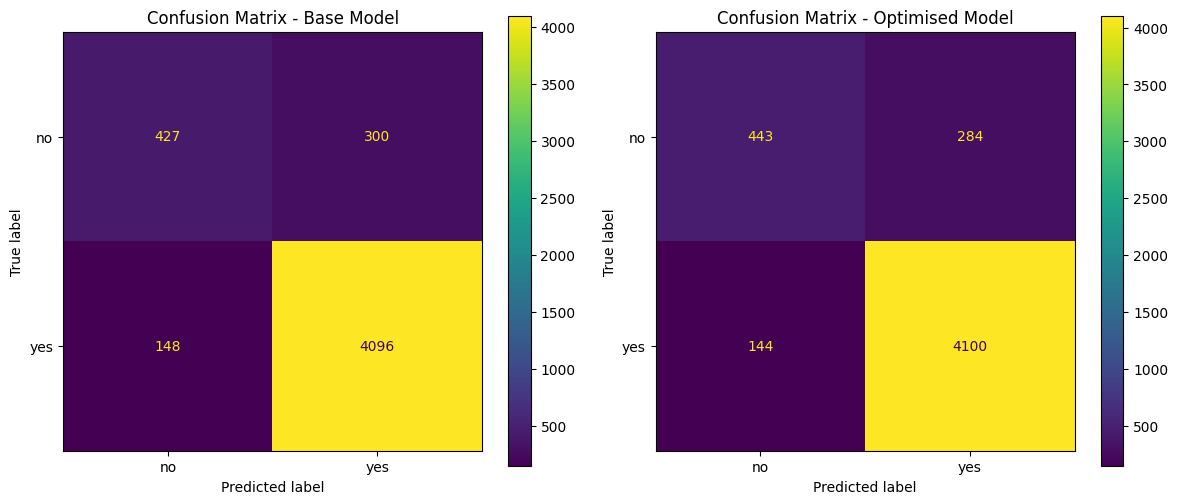

In [ ]:
print('Classification report for the base Model')
print(cr_xbg_base_2)
print('Classification report for the optimal Model')
print(cr_xbg_best_2)

print("XGBoost base Model AUC:", np.round(auc_score_xgb_base_2, 2))
print("XGBoost base Model AUC:", np.round(auc_score_xgb_best_2, 2))


cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_2, display_labels=["no","yes"])
cfmd_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best_2, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cfmd.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix - Base Model")
cfmd_opt.plot(ax=axes[1])
axes[1].set_title("Confusion Matrix - Optimised Model")
plt.tight_layout()
plt.show()


From the classification reports and confusion matrices, it can be observed that the optimized model has slightly better performance than the baseline model, with an increase in recall from 0.59 to 0.61 and an improvement in the F1 score for class 0 from 0.66 to 0.67. It is evident that hyperparameter tuning did not have a significant impact. The AUC is the same for both the models.

Stage 1.3.1 Feature Importance

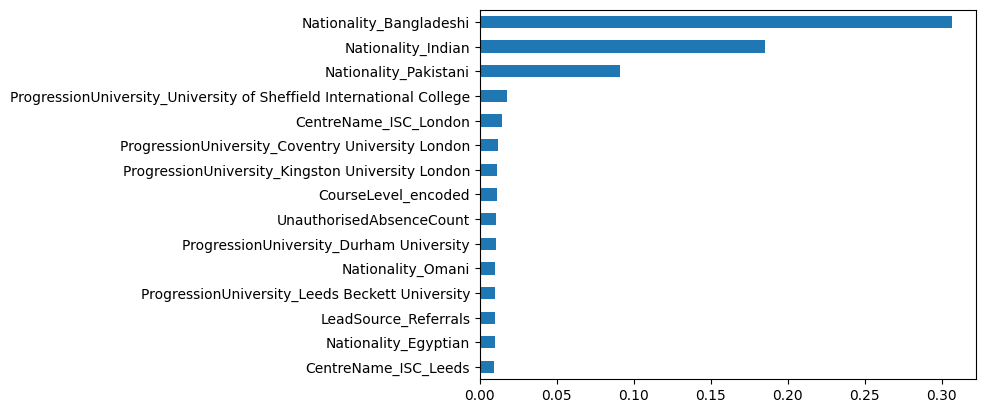

In [ ]:
xg_model_opt = xgb.XGBClassifier(random_state=42,learning_rate=opt_lr, max_depth=opt_depth, n_estimators=opt_n_est)
xg_model_opt.fit(X_train, y_train)
feature_importance = pd.Series(xg_model_opt.feature_importances_, index=X_train.columns).sort_values()

feature_importance.iloc[-15:].plot.barh()
plt.show()

Although it may seem unusual that certain nationalities emerge as the most important features, this is driven by the fact that individuals from these specific groups exhibit a significantly higher dropout rate compared to the overall population in the dataset.

In [ ]:
y_train_filtered = y_train[X_train['Nationality_Bangladeshi'] == 1]
print(y_train_filtered.value_counts(normalize=True))
y_train_filtered = y_train[X_train['Nationality_Indian'] == 1]
print(y_train_filtered.value_counts(normalize=True))

target
0    0.632614
1    0.367386
Name: proportion, dtype: float64
target
1    0.518125
0    0.481875
Name: proportion, dtype: float64


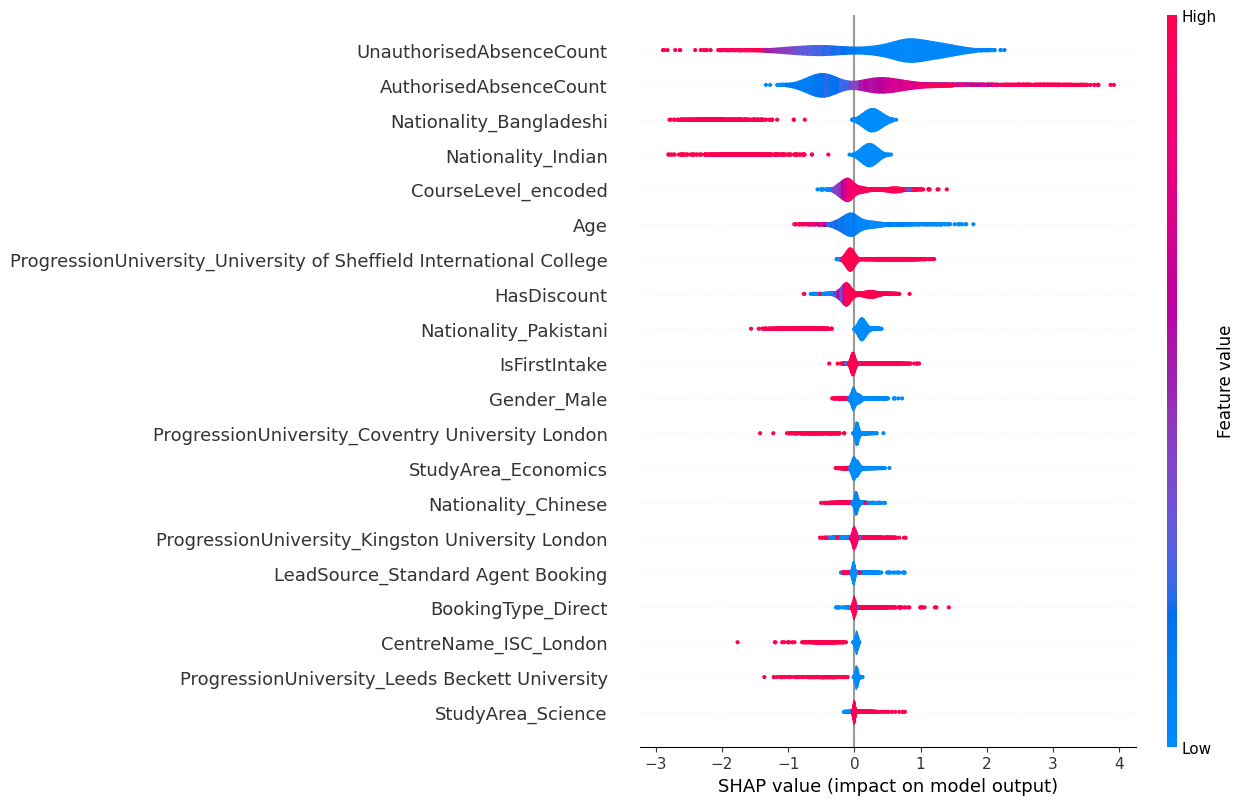

In [ ]:

shap.initjs()
shap_ex = shap.TreeExplainer(xg_model_opt)
vals = shap_ex(X_test)
shap.plots.violin(vals)

The evaluations made regarding the SHAP plot in the previous stage remain valid. However, it is now evident that the additional features introduced in stage two influence the model’s predictions in a specific direction. In particular, a high number of unauthorized absences seems to push the model to classify these individuals into class 0 (those who will drop out), whereas a high number of authorized absences leads the model to predict these individuals as belonging to class 1 (those who will complete the course).

This behavior can be logically explained: unauthorized absences are often viewed as a sign of disengagement from the course, suggesting that students with high unauthorized absences are more likely to drop out. On the other hand, a high number of authorized absences typically points to legitimate reasons for missing classes, such as illness or personal commitments, which might not indicate a lack of commitment to the course, making them more likely to complete their studies.

# Stage 2.4 - Neural Network

In [ ]:
# Trova le colonne con più di 2 valori unici (non binarie)
num_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Inizializza lo scaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Applica lo scaling solo alle colonne selezionate
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_train_scaled.head()

IsFirstIntake  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  \
6664               0               -0.522867                  0.368126   
17815              1               -0.350383                 -0.602403   
23633              0                1.339958                  0.751230   
10108              0               -0.522867                  0.393666   
4913               0                0.719016                  0.112724   

            Age  HasDiscount  CourseLevel_encoded  Nationality_Algerian  \
6664  -0.327936            0             0.093131                     0   
17815 -0.962889            1            -0.720687                     0   
23633 -0.962889            1             0.093131                     0   
10108 -1.597842            0            -0.720687                     0   
4913  -0.327936            0             0.093131                     0   

       Nationality_Bangladeshi  Nationality_Chinese  Nationality_Egyptian  \
6664                         0                    0                     0   
17815                        0                    0                     1   
23633                        0                    0                     1   
10108                        0                    0                     0   
4913                         0                    0                     0   

       ...  CentreName_ISC_Sussex  CentreName_ISC_Teesside  \
6664   ...                      0                        0   
17815  ...                      0                        0   
23633  ...                      1                        0   
10108  ...                      0                        0   
4913   ...                      0                        0   

       BookingType_Direct  LeadSource_Digital (Web)  LeadSource_Re-enrolment  \
6664                    0                         0                        0   
17815                   0                         0                        0   
23633                   0                         0                        0   
10108                   0                         0                        0   
4913                    0                         0                        0   

       LeadSource_Referrals  LeadSource_Sponsor  \
6664                      0                   0   
17815                     0                   0   
23633                     0                   0   
10108                     0                   1   
4913                      0                   0   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in  Gender_Male  
6664                                   1                   0            1  
17815                                  1                   0            1  
23633                                  1                   0            1  
10108                                  0                   0            1  
4913                                   1                   0            1  

[5 rows x 75 columns]

Here 2 functions are created to create and then evaluate a model.

To check a possibile overfitting, 10% of the training data are used as validation data.

In [ ]:
def create_model(learning_rate=0.001, activation='relu', n_neuron_1=32, n_neuron_2=16, optimizer_type='adam'):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(n_neuron_1, activation=activation)(inputs)
    x = Dense(n_neuron_2, activation=activation)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

    return model

def train_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)

    return accuracy, precision, recall, history

In [ ]:
model_base_2 = create_model(learning_rate=0.001, activation='relu')
accuracy, precision,recall, history = train_evaluate_model(model_base_2, X_train_scaled, y_train, X_test_scaled, y_test)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


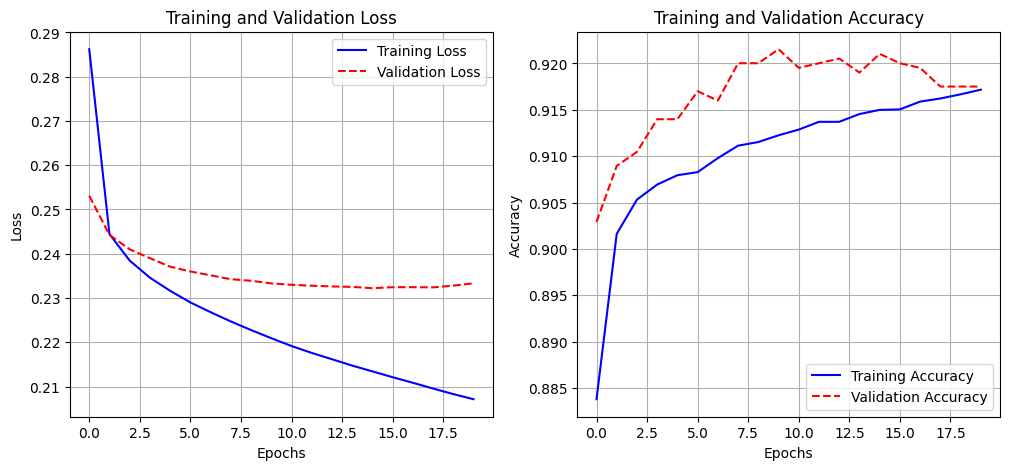

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network, accuracy score:  0.91
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       727
           1       0.93      0.97      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.84      0.76      0.79      4971
weighted avg       0.90      0.91      0.90      4971

Neural Netowrk AUC: 0.78


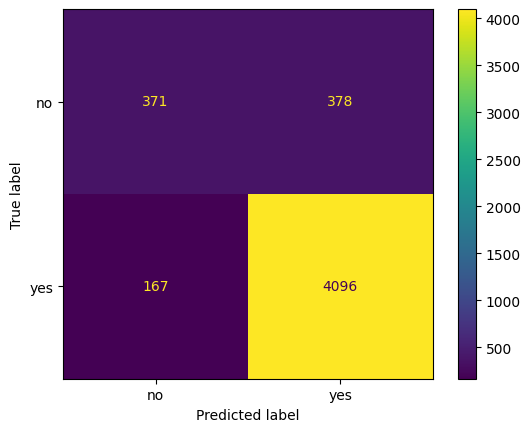

In [ ]:
y_pred = (model_base_2.predict(X_test_scaled) > 0.5).astype(int)

cr_nn_base_2 = classification_report(y_test, y_pred)
print("Neural Network, accuracy score: ", np.round(accuracy_score(y_test, y_pred),2))
print(cr_nn_base_2)

y_prob = model_base_2.predict(X_test).flatten()
auc_score_nn_base_2 = roc_auc_score(y_test, y_prob)
print("Neural Netowrk AUC:", np.round(auc_score_nn_base_2, 2))

cm_nn_base_2 = confusion_matrix(y_test, y_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_2, display_labels=["no","yes"])
cfmd.plot()
plt.show()

The base neural network model shows wors performance with respect to the XGBOOST.

To try to otpimize the performance of the model, a grid search is implemented.
The parameters considered in the optimization are:

- Learning rate
- Number of neuron of hidden layer 1, while the number of neuron for the second hidden layer are half of those of hid layer 1 --> this is a semplification but it can help to reduce the computation time
- Activation functions of the hidden layer
- Optimizer (Adam, RMSProp)

An early stopping has been implemented with a patience of 5, to avoid having too much overfitting.

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
n_neuron_1 = [32, 64, 128]
activations = ['relu', 'tanh','sigmoid']
optimizer_types = ['adam', 'rmsprop']
results = []

for optimizer in optimizer_types:
    for lr in learning_rates:
        for activation in activations:
            for n_neuron in n_neuron_1:
                n_neuron_2 = int(n_neuron / 2)
                model = create_model(learning_rate=lr, activation=activation, n_neuron_1=n_neuron, n_neuron_2=n_neuron_2, optimizer_type=optimizer)
                accuracy, precision, recall, history = train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, batch_size=64)

                cr = classification_report(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                cm = confusion_matrix(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                auc = roc_auc_score(y_test, model.predict(X_test_scaled))

                results.append({
                    'learning_rate': lr,
                    'batch_size': 64,
                    'activation': activation,
                    'optimizer': optimizer,
                    'n_neuron_1': n_neuron,
                    'n_neuron_2': n_neuron_2,
                    'accuracy': accuracy,
                    'precision_class_0': precision[0],
                    'precision_class_1': precision[1],
                    'recall_class_0': recall[0],
                    'recall_class_1': recall[1],
                    'auc_score' : auc,
                    'classification_report': cr,
                    'confusion_matrix': cm
                })
                print(results[-1])

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 'batch_size': 64, 'activation': 'relu', 'optimizer': 'adam', 'n_neuron_1': 32, 'n_neuron_2': 16, 'accuracy': 0.9070609535304768, 'precision_class_0': 0.7226890756302521, 'precision_class_1': 0.9321297989031079, 'recall_class_0': 0.5914718019257221, 'recall_class_1': 0.9611215834118756, 'auc_score': 0.9069506007024076, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.59      0.65       727\n           1       0.93      0.96      0.95      4244\n\n    accuracy                           0.91      4971\n   macro avg       0.83      0.78      0.80      4971\nweighted avg       0.90      0.91      0.90      4971\n', 'confusion_matrix': array([[ 430,  297],
       [ 165, 4079]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
156/156 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 96/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.1, 'batch_size': 64, 'activation': 'sigmoid', 'optimizer': 'adam', 'n_neuron_1': 128, 'n_neuron_2': 64, 'accuracy': 0.8537517602092134, 'precision_class_0': 0.0, 'precision_class_1': 0.8537517602092134, 'recall_class_0': 0.0, 'recall_class_1': 1.0, 'auc_score': 0.5, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       727\n           1       0.85      1.00      0.92      4244\n\n    accuracy                           0.85      4971\n   macro avg       0.43      0.50      0.46      4971\nweighted avg       0.73      0.85      0.79      4971\n', 'confusion_matrix': array([[   0,  727],
       [   0, 4244]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 'batch_size': 6

In [ ]:
# During the grid search of the neural network, some NN models didn't predict any class 0 individual. For this reasons, these models are filtered out
results = [r for r in results if r['recall_class_0'] > 0]

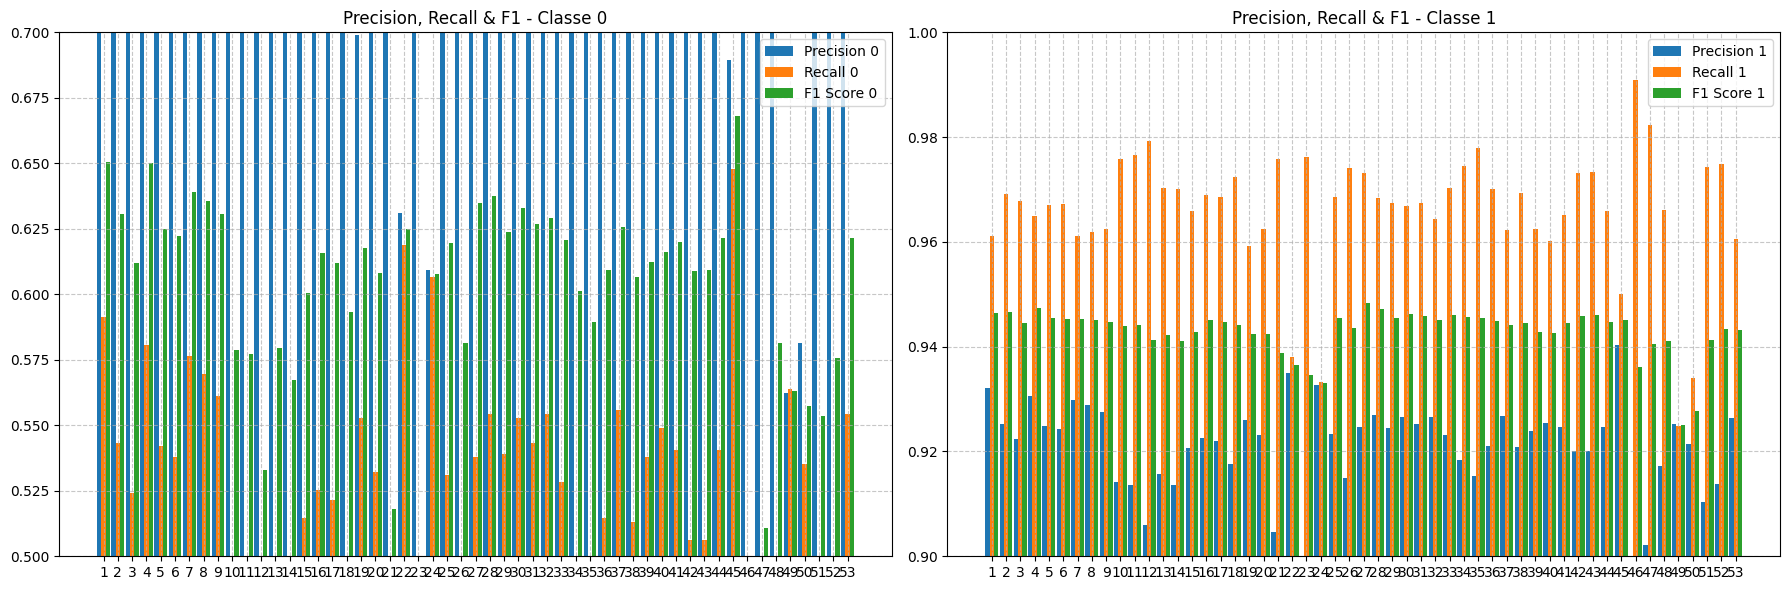

In [ ]:
precision_0 = [res["precision_class_0"] for res in results]
recall_0 = [res["recall_class_0"] for res in results]
precision_1 = [res["precision_class_1"] for res in results]
recall_1 = [res["recall_class_1"] for res in results]

f1_0 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_0, recall_0)]
f1_1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_1, recall_1)]

n = len(results)
x = np.arange(n)
bar_width = 0.3

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(x - bar_width, precision_0, bar_width, label="Precision 0")
axes[0].bar(x, recall_0, bar_width, label="Recall 0")
axes[0].bar(x + bar_width, f1_0, bar_width, label="F1 Score 0")
axes[0].set_title("Precision, Recall & F1 - Classe 0")
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, n+1))
axes[0].set_ylim(0.5, 0.7)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width, precision_1, bar_width, label="Precision 1")
axes[1].bar(x, recall_1, bar_width, label="Recall 1")
axes[1].bar(x + bar_width, f1_1, bar_width, label="F1 Score 1")
axes[1].set_title("Precision, Recall & F1 - Classe 1")
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, n+1))
axes[1].set_ylim(0.9, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


From the various network configurations, it can be observed that performance is quite sensitive to changes in hyperparameters. Unlike XGBoost, which showed much greater stability, the results here vary significantly depending on the chosen configuration. For this reason, instead of optimizing solely for recall of class 0, a more balanced approach was taken by considering both the harmonic F1 score across classes and the weighted F1 score.

The best model was selected based on the F1 score rather than just recall for class 0, as relying exclusively on recall could have led to an overly biased model, significantly reducing precision for both class 0 and class 1. Given the high variability in results, this compromise was necessary to ensure more reliable and generalizable predictions.

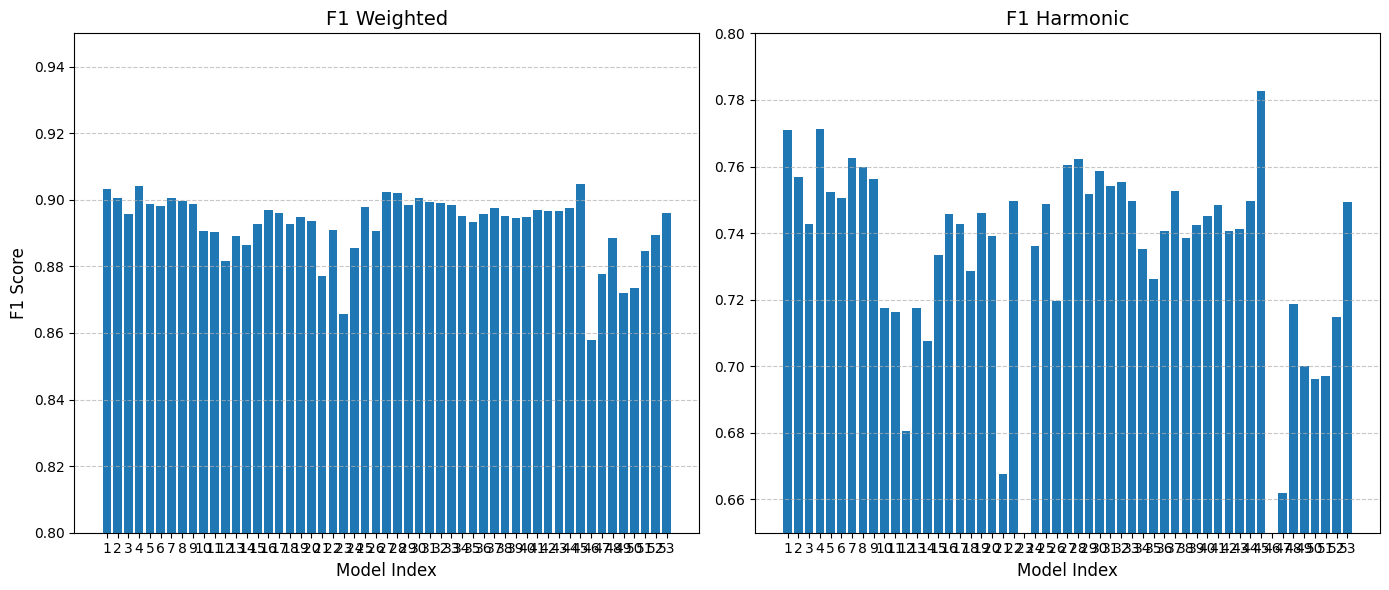

In [ ]:
f1_armonic = [(2 * f_0 * f_1) / (f_0 + f_1) for f_0, f_1 in zip(f1_0, f1_1)]
f1_weighted = [(y_test.value_counts()[0] * f_0 + y_test.value_counts()[1] * f_1) / (y_test.value_counts()[0] + y_test.value_counts()[1]) for f_0, f_1 in zip(f1_0, f1_1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(f1_weighted))

axes[0].bar(x, f1_weighted)
axes[0].set_title("F1 Weighted", fontsize=14)
axes[0].set_xlabel("Model Index", fontsize=12)
axes[0].set_ylabel("F1 Score", fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, len(f1_weighted) + 1))
axes[0].set_ylim(0.8, 0.95)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(x, f1_armonic)
axes[1].set_title("F1 Harmonic", fontsize=14)
axes[1].set_xlabel("Model Index", fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, len(f1_armonic) + 1))
axes[1].set_ylim(0.65, 0.8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


From the plots, it can be seen that the F1 weighted score is not too sensitive to the model, while the harmonic F1 score, which considers both classes, appears to be more useful.

Since the dataset is imbalanced, the weighted F1 score is heavily influenced by the majority class, making it less reliable in evaluating overall model performance. The harmonic F1 score, on the other hand, ensures that both classes contribute equally to the evaluation, preventing the model from being biased toward the dominant class.

Therefore, the best model is selected based on the harmonic F1 score.

In [ ]:
best_f1_armonic = 0

for i in range(len(f1_armonic)):
    if f1_armonic[i] > best_f1_armonic:
        best_f1_armonic = f1_armonic[i]
        best_f1_armonic_index = i


print('Best model configuration has been chosen to maximize the F1 armonic, which is for the best model', np.round(best_f1_armonic, 2), )
print("The configuration is:")
for key, value in results[best_f1_armonic_index].items():
    print(f"{key}: {value}")
nn_lr_opt = results[best_f1_armonic_index]['learning_rate']
nn_batch_size = results[best_f1_armonic_index]['batch_size']
nn_activation = results[best_f1_armonic_index]['activation']
nn_optimizer = results[best_f1_armonic_index]['optimizer']
n_neuron_1 = results[best_f1_armonic_index]['n_neuron_1']
n_neuron_2 = results[best_f1_armonic_index]['n_neuron_2']
auc_score_nn_best_2 = results[best_f1_armonic_index]['auc_score']
cm_nn_best_2 = results[best_f1_armonic_index]['confusion_matrix']
cr_nn_best_2 = results[best_f1_armonic_index]['classification_report']

Best model configuration has been chosen to maximize the F1 armonic, which is for the best model 0.78
The configuration is:
learning_rate: 0.1
batch_size: 64
activation: relu
optimizer: rmsprop
n_neuron_1: 32
n_neuron_2: 16
accuracy: 0.9058539529269765
precision_class_0: 0.6896046852122987
precision_class_1: 0.9402985074626866
recall_class_0: 0.6478679504814305
recall_class_1: 0.9500471253534402
auc_score: 0.8927134934082844
classification_report:               precision    recall  f1-score   support

           0       0.69      0.65      0.67       727
           1       0.94      0.95      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.81      0.80      0.81      4971
weighted avg       0.90      0.91      0.90      4971

confusion_matrix: [[ 471  256]
 [ 212 4032]]


Classification report for the NN base model:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       727
           1       0.93      0.97      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.84      0.76      0.79      4971
weighted avg       0.90      0.91      0.90      4971

Classification report for the NN optimal model:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       727
           1       0.94      0.95      0.95      4244

    accuracy                           0.91      4971
   macro avg       0.81      0.80      0.81      4971
weighted avg       0.90      0.91      0.90      4971

Neural Netowrk base AUC: 0.78
Neural Netowrk optimal AUC: 0.89


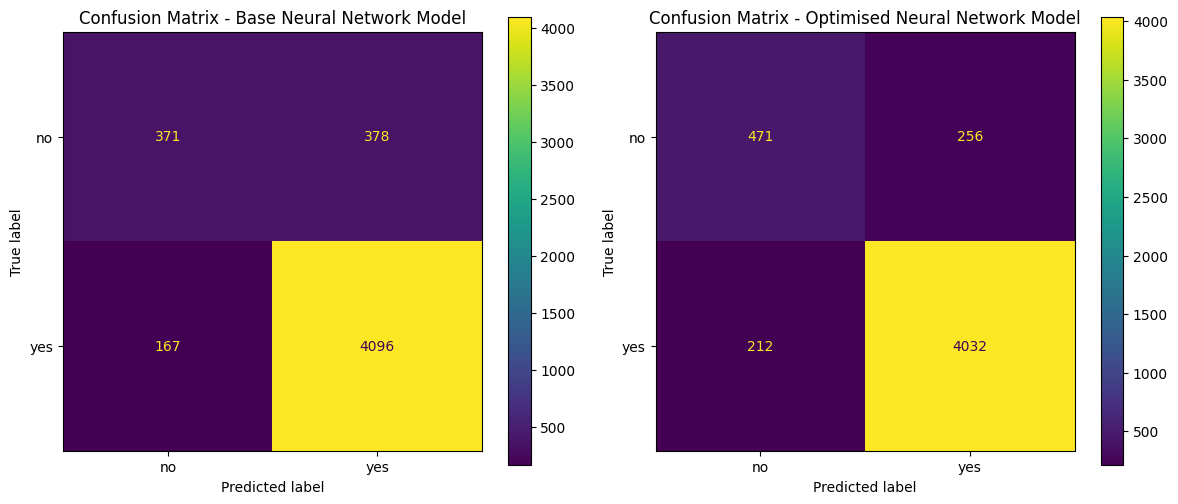

In [ ]:
print('Classification report for the NN base model:')
print(cr_nn_base_2)

print('Classification report for the NN optimal model:')
print(cr_nn_best_2)

print("Neural Netowrk base AUC:", np.round(auc_score_nn_base_2, 2))
print("Neural Netowrk optimal AUC:", np.round(auc_score_nn_best_2, 2))


cfmd_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_2, display_labels=["no","yes"])
cfmd_nn_opt = ConfusionMatrixDisplay(confusion_matrix=cm_nn_best_2, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Confusion Matrix - Base Neural Network Model")
cfmd.plot(ax=axes[0])

axes[1].set_title("Confusion Matrix - Optimised Neural Network Model")
cfmd_nn_opt.plot(ax=axes[1])

plt.tight_layout()
plt.show()



Comparing the baseline neural network model with the optimized one (which maximizes the harmonic F1 score), we observe a significant improvement in performance of the optimized model, especially for class 0. Although precision has decreased, recall has increased substantially, allowing the model to identify a much higher number of at-risk students—critical. The F1 score for class 0 has improved considerably, rising from 0.64 to 0.67. Additionally, the AUC shows a marked improvement, increasing from 0.78 to 0.89. This significant boost in performance is largely due to the high sensitivity of neural networks to hyperparameter tuning.


# Stage 2.5 - Stage 1 vs Stage 2 Dataset - Performance

In this section the comparison of the optimal model based on XGBoost and neural network is shown.

Accuracy Report for the best XGB Model - Stage 1 Dataset
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       749
           1       0.93      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.76      0.78      5012
weighted avg       0.89      0.89      0.89      5012

--------------------------------------------------------
Accuracy Report for the best NN Model - Stage 1 Dataset
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       727
           1       0.94      0.94      0.94      4244

    accuracy                           0.90      4971
   macro avg       0.79      0.80      0.80      4971
weighted avg       0.90      0.90      0.90      4971

--------------------------------------------------------
Accuracy Report for the best XGB Model - Stage 2 Dataset
              precision    recall  f1-score   support

       

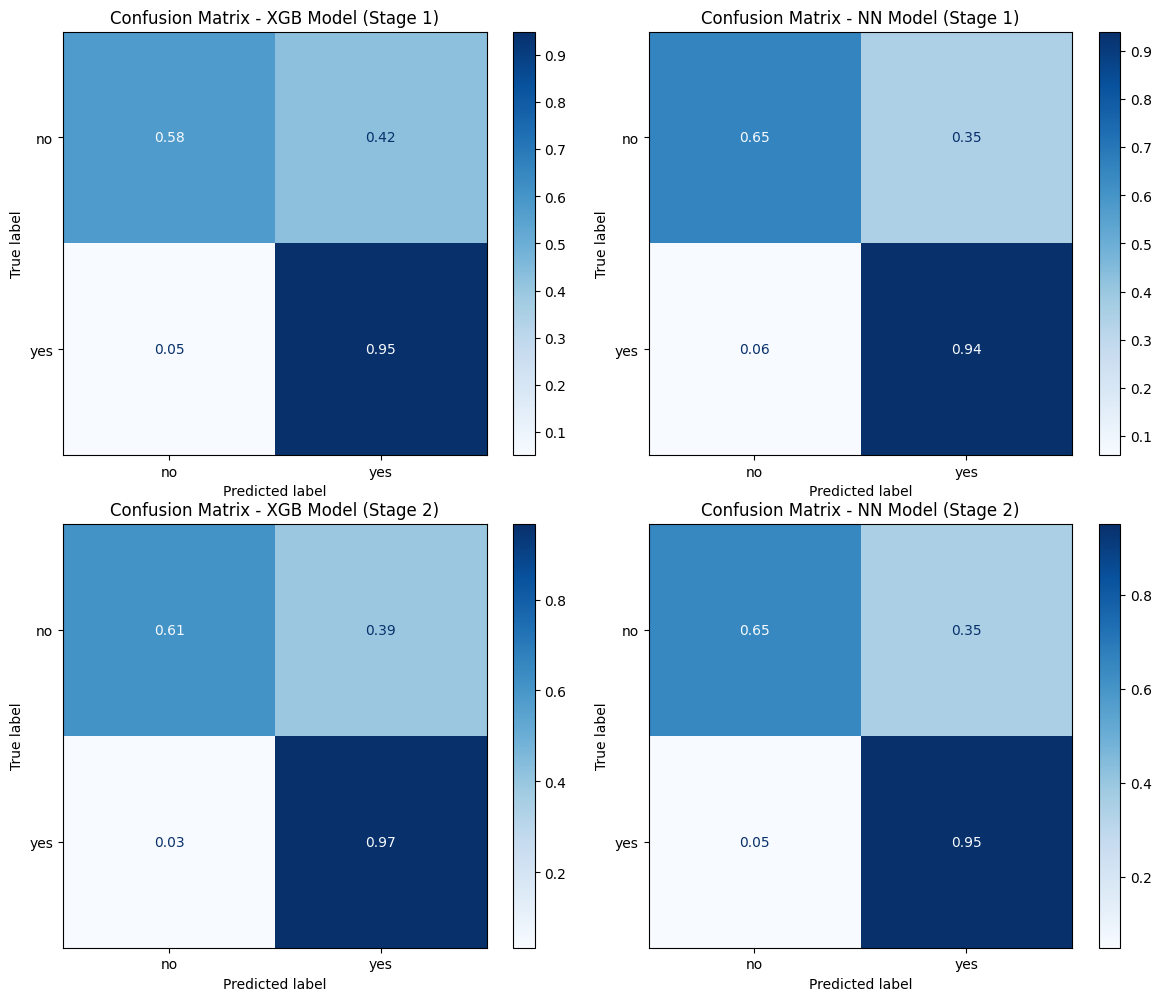

In [ ]:
print('Accuracy Report for the best XGB Model - Stage 1 Dataset')
print(cr_xbg_best_1)
print('--------------------------------------------------------')
print('Accuracy Report for the best NN Model - Stage 1 Dataset')
print(cr_nn_best_1)
print('--------------------------------------------------------')
print('Accuracy Report for the best XGB Model - Stage 2 Dataset')
print(cr_xbg_best_2)
print('--------------------------------------------------------')
print('Accuracy Report for the best NN Model - Stage 2 Dataset')
print(cr_nn_best_2)
print('--------------------------------------------------------')
print('AUC for the best XGB Model - Stage 1 dataset')
print(np.round(auc_score_xgb_best_1,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 1 dataset')
print(np.round(auc_score_nn_best_1,2))
print('--------------------------------------------------------')
print('AUC for the best XGB Model - Stage 2 dataset')
print(np.round(auc_score_xgb_best_2,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 2 dataset')
print(np.round(auc_score_nn_best_1,2))
print('-------------------------------------------------------')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def plot_normalized_cm(cm, ax, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=1, keepdims=True), display_labels=["no", "yes"])
    ax.set_title(title)
    disp.plot(ax=ax, cmap='Blues', values_format='.2f')

plot_normalized_cm(cm_xgb_best_1, axes[0, 0], "Confusion Matrix - XGB Model (Stage 1)")
plot_normalized_cm(cm_nn_best_1, axes[0, 1], "Confusion Matrix - NN Model (Stage 1)")
plot_normalized_cm(cm_xgb_best_2, axes[1, 0], "Confusion Matrix - XGB Model (Stage 2)")
plot_normalized_cm(cm_nn_best_2, axes[1, 1], "Confusion Matrix - NN Model (Stage 2)")

plt.tight_layout()
plt.show()

Above is the comparison between the optimized XGBoost and neural network models on the stage 1 and stage 2 datasets. From the confusion matrices, we can observe that models trained on stage 2 data achieve slightly better performance compared to those optimized on stage 1.

The neural network model on stage 2 maintains the same recall as the optimized stage 1 model but achieves higher precision, leading to an increase in the F1 score from 0.65 to 0.67. Meanwhile, the XGBoost model on stage 2 retains the same F1 score for class 0 as neural network counterpart but is significantly more precise (0.75 vs. 0.69) compared to the neural network.

Overall, accuracy has slightly improved when considering models trained on stage 2 rather than stage 1.

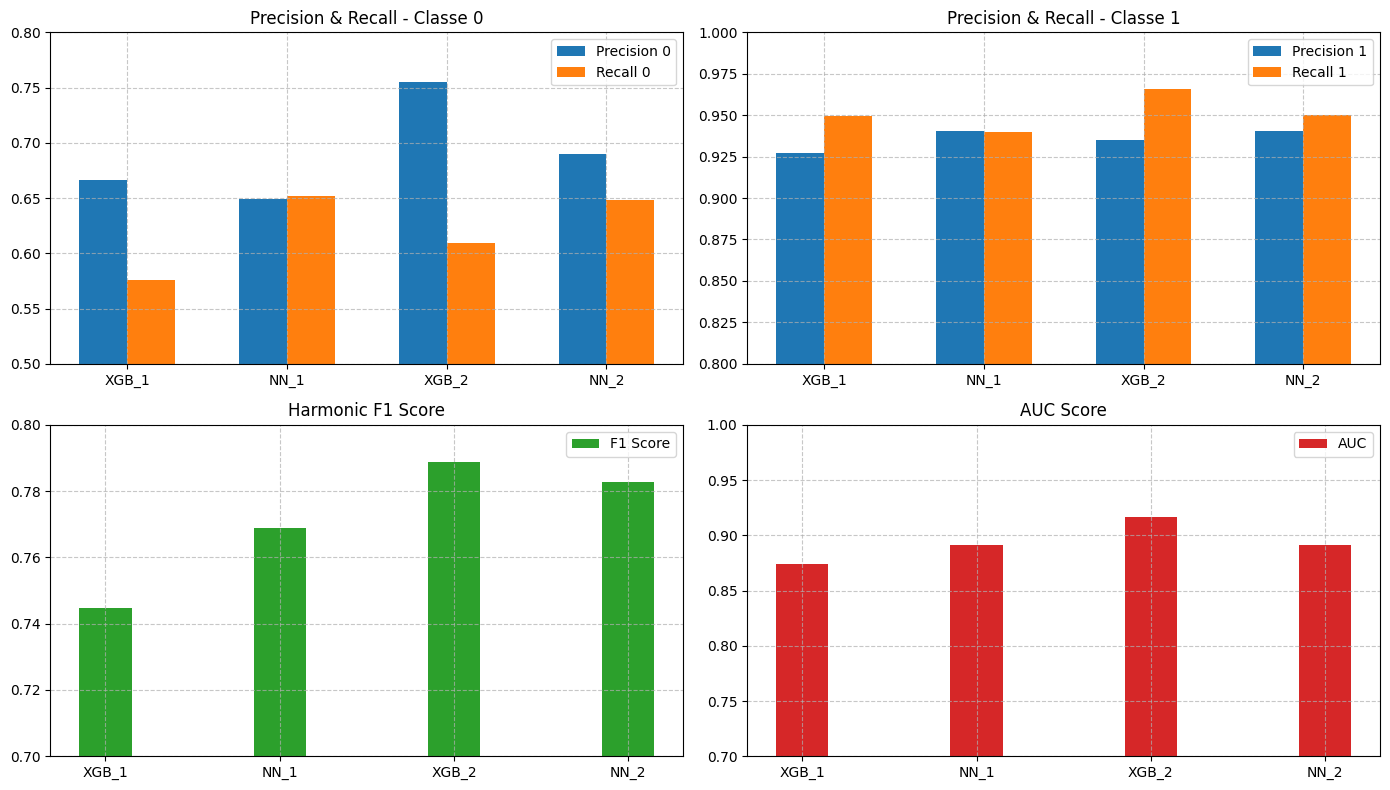

In [ ]:
def calculate_metrics(cm):
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[0, 0]

    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    f1_harmonic = 2 * (f1_0 * f1_1) / (f1_0 + f1_1) if (f1_0 + f1_1) > 0 else 0

    return precision_0, recall_0, precision_1, recall_1, f1_harmonic

models = ["XGB_1", "NN_1", "XGB_2", "NN_2"]
cm_list = [cm_xgb_best_1, cm_nn_best_1, cm_xgb_best_2, cm_nn_best_2]
auc_scores = [auc_score_xgb_best_1, auc_score_nn_best_1, auc_score_xgb_best_2, auc_score_nn_best_1]

metrics = [calculate_metrics(cm) for cm in cm_list]
precision_0, recall_0, precision_1, recall_1, f1_scores = zip(*metrics)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
x = np.arange(len(models))
bar_width = 0.3

axes[0, 0].bar(x - bar_width / 2, precision_0, bar_width, label="Precision 0")
axes[0, 0].bar(x + bar_width / 2, recall_0, bar_width, label="Recall 0")
axes[0, 0].set_title("Precision & Recall - Classe 0")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(True, linestyle="--", alpha=0.7)
axes[0, 0].legend()
axes[0, 0].set_ylim(0.5, 0.8)

axes[0, 1].bar(x - bar_width / 2, precision_1, bar_width, label="Precision 1")
axes[0, 1].bar(x + bar_width / 2, recall_1, bar_width, label="Recall 1")
axes[0, 1].set_title("Precision & Recall - Classe 1")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].grid(True, linestyle="--", alpha=0.7)
axes[0, 1].legend()
axes[0, 1].set_ylim(0.8, 1)

axes[1, 0].bar(x, f1_scores, bar_width, color="C2", label="F1 Score")
axes[1, 0].set_title("Harmonic F1 Score")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(True, linestyle="--", alpha=0.7)
axes[1, 0].legend()
axes[1, 0].set_ylim(0.7, 0.8)

axes[1, 1].bar(x, auc_scores, bar_width, color="C3", label="AUC")
axes[1, 1].set_title("AUC Score")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(True, linestyle="--", alpha=0.7)
axes[1, 1].legend()
axes[1, 1].set_ylim(0.7, 1)

plt.tight_layout()
plt.show()

From the graphs above, we can see that the neural network model on stage 2 achieves a good balance between precision and recall for class 0, while the XGBoost model on stage 2 prioritizes higher precision at the cost of lower recall. Notably, the latter achieves the highest harmonic F1 score and AUC, indicating that it is better at distinguishing between the two classes.

Performance across all four models remains fairly comparable for class 1.

In conclusion, the addition of absence-related features in stage 2 has contributed to a slight performance improvement for the models trained on this dataset.

# Stage 3 - Data

In [ ]:
# File URL
file_url = "/path_to_your_dataset"
df_3 = pd.read_csv(file_url)

In [ ]:
df_3.head()

CentreName  LearnerCode BookingType              LeadSource DiscountType  \
0  ISC_Aberdeen      2284932       Agent  Standard Agent Booking          NaN   
1  ISC_Aberdeen      2399500       Agent  Standard Agent Booking          NaN   
2  ISC_Aberdeen      2424946       Agent  Standard Agent Booking          NaN   
3  ISC_Aberdeen      2426583       Agent  Standard Agent Booking          NaN   
4  ISC_Aberdeen      2434674       Agent  Standard Agent Booking          NaN   

  DateofBirth Gender Nationality                          HomeState  \
0  13/01/1998   Male     Chinese  Jianye District; Jiangsu Province   
1   12/2/1998   Male     Chinese                                NaN   
2    7/4/2000   Male     Chinese                                NaN   
3  18/05/1999   Male     Chinese                                NaN   
4  19/04/1996   Male     Chinese                                NaN   

                 HomeCity  ...  \
0                 Nanjing  ...   
1                   Xi'an  ...   
2                 Chengdu  ...   
3  LIUYANG CITY ;CHANGSHA  ...   
4                  Xiamen  ...   

                                          CourseName IsFirstIntake  \
0                       Business and Law Pre-Masters          True   
1   Life Sciences Undergraduate Foundation Programme         False   
2  Business Management and Finance International ...         False   
3  Business Management and Finance International ...          True   
4                       Business and Law Pre-Masters          True   

   CompletedCourse AssessedModules  PassedModules  FailedModules  \
0              Yes             4.0            4.0            0.0   
1              Yes             7.0            7.0            0.0   
2              Yes             8.0            8.0            0.0   
3              Yes             8.0            8.0            0.0   
4              Yes             4.0            4.0            0.0   

                               ProgressionDegree   ProgressionUniversity  \
0  Msc Econ Accounting and Investment Management  University of Aberdeen   
1                        BSc Biological Sciences  University of Aberdeen   
2                                     MA Finance  University of Aberdeen   
3                         MA Business Management  University of Aberdeen   
4          MSc International Business Management  University of Aberdeen   

  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  
0                    NaN                       NaN  
1                   93.0                       5.0  
2                   92.0                       6.0  
3                   67.0                      15.0  
4                    NaN                       NaN  

[5 rows x 21 columns]

# Stage 3 - EDA and Feature Engineering

**Stage 3: Pre-processing instructions**

- Remove any columns not useful in the analysis 
- Remove columns with high cardinality 
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.






In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

In [ ]:
# Drop of the column LearnerCode since it's not useful.The Homestate  has been deleted since it has more the 50% of data missing
df_cleaned = df_3.drop(columns=['LearnerCode','HomeState'],axis=1)

In [ ]:
# Date of birth column utilised to built the age column and then drop of the first one
# I use as reference day the 01/01/2025
ref_date = pd.to_datetime("2025-01-01")
df_cleaned["DateofBirth"] = pd.to_datetime(df_cleaned["DateofBirth"], format="%d/%m/%Y")
df_cleaned["Age"] = (ref_date - df_cleaned["DateofBirth"]).dt.days // 365
df_cleaned.drop(columns=["DateofBirth"], inplace=True)

In [ ]:
# Here the features with high cardinality have been deleted (categorical features with more than 200 unique values)
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and df_cleaned[col].nunique() > 200:
        print(f"{col} has been deleted since it has {df_cleaned[col].nunique()} unique values")
        df_cleaned.drop(columns=[col], inplace=True)

HomeCity has been deleted since it has 5881 unique values
ProgressionDegree has been deleted since it has 2616 unique values


In [ ]:
#The DiscountType feature indicates whether a discount was applied (NaN if no discount) and the type of discount received
# Since the type of discount seems to be not relevant, I decided to create a binary feature called "HasDiscount" which indicates wheter a discount has been applied or not, regardless of the discount type
df_cleaned["HasDiscount"] = df_cleaned["DiscountType"].notna().astype(int)
df_cleaned.drop(columns=["DiscountType"], inplace=True)

In [ ]:
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel                                         CourseName  \
0             Pre-Masters                       Business and Law Pre-Masters   
1              Foundation   Life Sciences Undergraduate Foundation Programme   
2  International Year Two  Business Management and Finance International ...   
3  International Year Two  Business Management and Finance International ...   
4             Pre-Masters                       Business and Law Pre-Masters   

   IsFirstIntake CompletedCourse  AssessedModules  PassedModules  \
0           True             Yes              4.0            4.0   
1          False             Yes              7.0            7.0   
2          False             Yes              8.0            8.0   
3           True             Yes              8.0            8.0   
4           True             Yes              4.0            4.0   

   FailedModules   ProgressionUniversity  AuthorisedAbsenceCount  \
0            0.0  University of Aberdeen                     NaN   
1            0.0  University of Aberdeen                    93.0   
2            0.0  University of Aberdeen                    92.0   
3            0.0  University of Aberdeen                    67.0   
4            0.0  University of Aberdeen                     NaN   

   UnauthorisedAbsenceCount  Age  HasDiscount  
0                       NaN   26            0  
1                       5.0   26            0  
2                       6.0   24            0  
3                      15.0   25            0  
4                       NaN   28            0

In [ ]:
for col in df_cleaned.columns:
      print(f"{col} has {df_cleaned[col].nunique()} unique values")

CentreName has 19 unique values
BookingType has 2 unique values
LeadSource has 7 unique values
Gender has 2 unique values
Nationality has 151 unique values
CourseLevel has 4 unique values
CourseName has 172 unique values
IsFirstIntake has 2 unique values
CompletedCourse has 2 unique values
AssessedModules has 12 unique values
PassedModules has 12 unique values
FailedModules has 11 unique values
ProgressionUniversity has 40 unique values
AuthorisedAbsenceCount has 190 unique values
UnauthorisedAbsenceCount has 258 unique values
Age has 38 unique values
HasDiscount has 2 unique values


In [ ]:
df_cleaned['CourseName'].unique()

array(['Business and Law Pre-Masters',
       'Life Sciences Undergraduate Foundation Programme',
       'Business Management and Finance International Year Two',
       'Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme',
       'Physical Sciences and Engineering Undergraduate Foundation Programme',
       'Life Sciences - pathway to Medicine Undergraduate Foundation Programme',
       'Science and Engineering Pre-Masters',
       'Humanities; Law and Social Science Undergraduate Foundation Programme',
       'Business and Law Pre-Masters (ICAS)',
       'Business Management and Finance International Year Two (ICAS)',
       'Computing Science International Year Two (ICAS)',
       'Science and Engineering Pre-Masters (ICAS)',
       'Engineering; Physical Sciences and Architecture International Foundation Year',
       'Health; Medical and Life Sciences International Foundation Year',
       'Business; Economics; Accounting and Finance International F

Once the dataset was cleaned it had 12 features. 3 of these features seem to be problematic since they have a lot of unique values, and the encoding applied to these should generate a too large dataset with a lot of columns who are carrying low information.

The CourseName feature has been treated to extract relevant information. In particular, a deeper analysis showed that some words are recurrent (like 'Business', 'Finance', 'Accounting' for the economics macro area of studying) and they can be use to subgroup some macro area of studying, leaving the course level info in its own specific feature.

In [ ]:
df_cleaned['StudyArea'] = None
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Mathematics', na=False), 'StudyArea'] = 'Mathematics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Arts|Art', na=False), 'StudyArea'] = 'Arts'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Engineering', na=False), 'StudyArea'] = 'Engineering'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Health', na=False), 'StudyArea'] = 'Health'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Science|Sciences', na=False), 'StudyArea'] = 'Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Computer|Comp', na=False), 'StudyArea'] = 'Computer Science'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Social', na=False), 'StudyArea'] = 'Social'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business|Finance|Accounting|Management|Economics', na=False), 'StudyArea'] = 'Economics'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Relations', na=False), 'StudyArea'] = 'International Relations'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Media', na=False), 'StudyArea'] = 'Media'
df_cleaned.loc[df_cleaned['CourseName'].str.contains('Business', na=False) &
               df_cleaned['CourseName'].str.contains('Law', na=False), 'StudyArea'] = 'Law and Business'
df_cleaned['StudyArea'] = df_cleaned['StudyArea'].fillna('Other')

In [ ]:
df_cleaned['StudyArea'].value_counts()


StudyArea
Economics                  11993
Science                     4341
Computer Science            2906
Law and Business            2794
Law                         1136
Media                        986
Social                       345
International Relations      232
Engineering                  214
Other                         90
Mathematics                   22
Name: count, dtype: int64

Even though there is likely some overlap between columns, this approach improves data quality by reducing the original feature to far fewer subgroups. Otherwise, using the raw CourseName column would have led to an excessive number of features during one-hot encoding.

In [ ]:
df_cleaned.drop(columns=["CourseName"], inplace=True)

The nationality feature has been treated to subgroup the most represented nationality to reduce the number of unique values.

In [ ]:
tot = 0
most_represented_nation = []
for nation in df_cleaned['Nationality'].unique():
    if (df_cleaned['Nationality'] == nation).sum() > 250:
        tot = tot + (df_cleaned['Nationality'] == nation).sum()
        print(f"{nation} has {df_cleaned['Nationality'].value_counts()[nation]} students")
        most_represented_nation.append(nation)

print(f'The most represented nationality are {len(most_represented_nation)} and they represent {np.around(100*tot/df_cleaned.shape[0],2)} % of total students')

Chinese has 9042 students
Taiwanese has 363 students
Kuwaiti has 893 students
Qatari has 283 students
Egyptian has 640 students
Emirati has 415 students
Hong Kong Chinese has 1278 students
Nigerian has 309 students
Indian has 2072 students
Bangladeshi has 2007 students
Saudi has 762 students
Omani has 411 students
Pakistani has 1973 students
Algerian has 311 students
Korean has 252 students
The most represented nationality are 15 and they represent 83.85 % of total students


The analysis shows that the 15 most represented nationalities account for 83% of the students in the dataset. Therefore, the nationality feature has been reduced to 16 groups: the top 15 nationalities and a 16th group labeled "Other" for all remaining cases.

In [ ]:
df_cleaned['Nationality'] = df_cleaned['Nationality'].apply(lambda x: x if x in most_represented_nation else 'Other')
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel  IsFirstIntake CompletedCourse  AssessedModules  \
0             Pre-Masters           True             Yes              4.0   
1              Foundation          False             Yes              7.0   
2  International Year Two          False             Yes              8.0   
3  International Year Two           True             Yes              8.0   
4             Pre-Masters           True             Yes              4.0   

   PassedModules  FailedModules   ProgressionUniversity  \
0            4.0            0.0  University of Aberdeen   
1            7.0            0.0  University of Aberdeen   
2            8.0            0.0  University of Aberdeen   
3            8.0            0.0  University of Aberdeen   
4            4.0            0.0  University of Aberdeen   

   AuthorisedAbsenceCount  UnauthorisedAbsenceCount  Age  HasDiscount  \
0                     NaN                       NaN   26            0   
1                    93.0                       5.0   26            0   
2                    92.0                       6.0   24            0   
3                    67.0                      15.0   25            0   
4                     NaN                       NaN   28            0   

          StudyArea  
0  Law and Business  
1           Science  
2         Economics  
3         Economics  
4  Law and Business

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   BookingType               25059 non-null  object 
 2   LeadSource                25059 non-null  object 
 3   Gender                    25059 non-null  object 
 4   Nationality               25059 non-null  object 
 5   CourseLevel               25059 non-null  object 
 6   IsFirstIntake             25059 non-null  bool   
 7   CompletedCourse           25059 non-null  object 
 8   AssessedModules           22828 non-null  float64
 9   PassedModules             22828 non-null  float64
 10  FailedModules             22828 non-null  float64
 11  ProgressionUniversity     25059 non-null  object 
 12  AuthorisedAbsenceCount    24851 non-null  float64
 13  UnauthorisedAbsenceCount  24851 non-null  float64
 14  Age   

In [ ]:
tot_uni = 0
most_represented_prog_uni = []
for university in df_cleaned['ProgressionUniversity'].unique():
    if (df_cleaned['ProgressionUniversity'] == university).sum() > 100:
        print(university,(df_cleaned['ProgressionUniversity'] == university).sum())
        most_represented_prog_uni.append(university)
        tot_uni += 1

print('------------------------------------------------------------------------------')
print('The total number of unique Progression university is', df_cleaned['ProgressionUniversity'].nunique())
print('------------------------------------------------------------------------------')
print('If we consider just the progression university chosen by more than 100 they are',tot_uni)


University of Aberdeen 363
Cardiff University 687
University College Dublin 399
Durham University 2563
Coventry University London 931
Holland ISC - VU Amsterdam 106
University of Huddersfield 1781
Kingston University London 1892
Liverpool John Moores University 950
Lancaster University 1115
Leeds Beckett University 703
University of Leeds 1591
University of Lincoln 241
University of Strathclyde 677
Royal Holloway 1048
University of Sheffield International College 5877
University of Surrey 1051
University of Sussex 2103
Teesside University 632
------------------------------------------------------------------------------
The total number of unique Progression university is 40
------------------------------------------------------------------------------
If we consider just the progression university chosen by more than 100 they are 19


In the dataset there were 40 unique university chosen by the students (if eligible to progress). Since most of them have not been chosen by a multitude of students, it has been decided to use just the ones chosen by more than 100 students. All the others have been considered as 'Others'

In [ ]:
df_cleaned['ProgressionUniversity'] = df_cleaned['ProgressionUniversity'].apply(lambda x: x if x in most_represented_prog_uni else 'Other')
df_cleaned['ProgressionUniversity'].unique()

array(['University of Aberdeen', 'Cardiff University',
       'University College Dublin', 'Durham University', 'Other',
       'Coventry University London', 'Holland ISC - VU Amsterdam',
       'University of Huddersfield', 'Kingston University London',
       'Liverpool John Moores University', 'Lancaster University',
       'Leeds Beckett University', 'University of Leeds',
       'University of Lincoln', 'University of Strathclyde',
       'Royal Holloway', 'University of Sheffield International College',
       'University of Surrey', 'University of Sussex',
       'Teesside University'], dtype=object)

In [ ]:
df_cleaned.head()

CentreName BookingType              LeadSource Gender Nationality  \
0  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
1  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
2  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
3  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   
4  ISC_Aberdeen       Agent  Standard Agent Booking   Male     Chinese   

              CourseLevel  IsFirstIntake CompletedCourse  AssessedModules  \
0             Pre-Masters           True             Yes              4.0   
1              Foundation          False             Yes              7.0   
2  International Year Two          False             Yes              8.0   
3  International Year Two           True             Yes              8.0   
4             Pre-Masters           True             Yes              4.0   

   PassedModules  FailedModules   ProgressionUniversity  \
0            4.0            0.0  University of Aberdeen   
1            7.0            0.0  University of Aberdeen   
2            8.0            0.0  University of Aberdeen   
3            8.0            0.0  University of Aberdeen   
4            4.0            0.0  University of Aberdeen   

   AuthorisedAbsenceCount  UnauthorisedAbsenceCount  Age  HasDiscount  \
0                     NaN                       NaN   26            0   
1                    93.0                       5.0   26            0   
2                    92.0                       6.0   24            0   
3                    67.0                      15.0   25            0   
4                     NaN                       NaN   28            0   

          StudyArea  
0  Law and Business  
1           Science  
2         Economics  
3         Economics  
4  Law and Business

In [ ]:
df_cleaned['AuthorisedAbsenceCount'].isnull().sum()
df_cleaned['UnauthorisedAbsenceCount'].isnull().sum()

print(f'The column AuthorisedAbsenceCount has {df_cleaned["AuthorisedAbsenceCount"].isnull().sum()} missing values, which represents the {np.around(100*(df_cleaned["AuthorisedAbsenceCount"].isnull().sum())/df_cleaned.shape[0],2)}%')
print(f'The column UnauthorisedAbsenceCount has {df_cleaned["UnauthorisedAbsenceCount"].isnull().sum()} missing values, which represents the {np.around(100*(df_cleaned["UnauthorisedAbsenceCount"].isnull().sum())/df_cleaned.shape[0],2)}%')


The column AuthorisedAbsenceCount has 208 missing values, which represents the 0.83%
The column UnauthorisedAbsenceCount has 208 missing values, which represents the 0.83%


Since the number of null rows in the two features related to authorised and unauthorised features is relatively small (2%), these rows have been removed.

Here the new features added on stage 3 are considered, to understand their distribution and how many missing values are present.

In [ ]:
print(100*df_cleaned['AssessedModules'].isnull().sum()/df_cleaned.shape[0])
print(100*df_cleaned['PassedModules'].isnull().sum()/df_cleaned.shape[0])
print(100*df_cleaned['FailedModules'].isnull().sum()/df_cleaned.shape[0])

8.902988946087234
8.902988946087234
8.902988946087234


In [ ]:
(df_cleaned['AssessedModules'].isnull() == df_cleaned['PassedModules'].isnull()).all() and \
(df_cleaned['AssessedModules'].isnull() == df_cleaned['FailedModules'].isnull()).all()

True

Since the new columns added on the stage 3 dataset have 9% of null columns, it has been decided to not delete them. The missing values are present in the same rows for all three columns: AssessedModules, PassedModules, and FailedModules indicating that the information related to the modules have not been provided for these students.









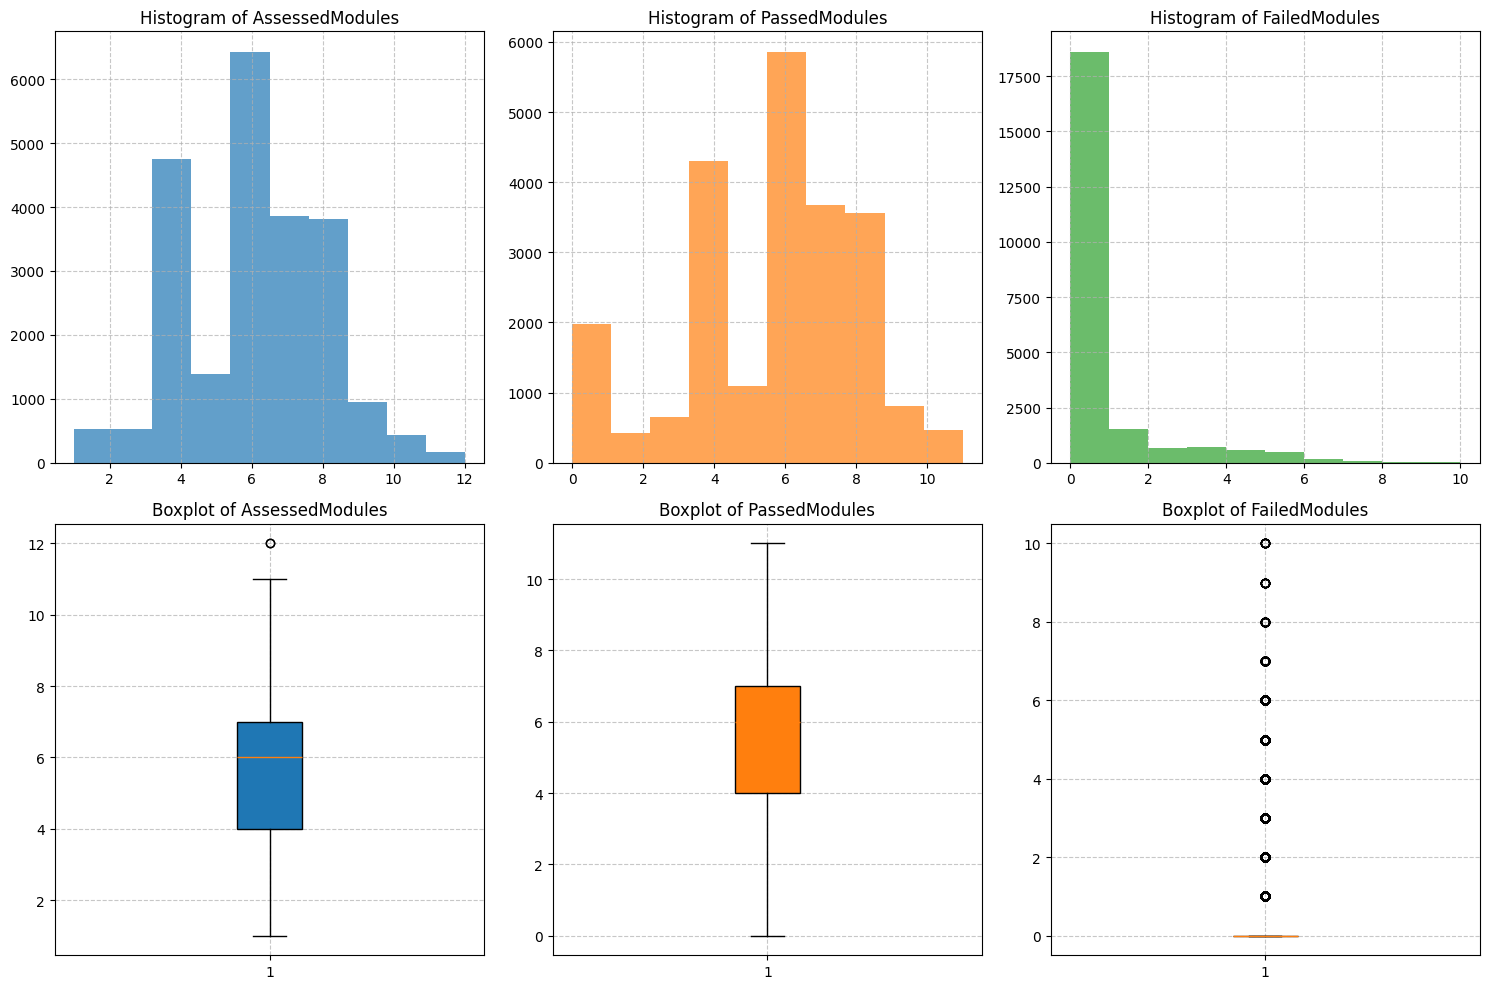

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

columns = ['AssessedModules', 'PassedModules', 'FailedModules']

for i, col in enumerate(columns):
    axes[0, i].hist(df_cleaned[col].dropna(), color='C'+str(i), alpha=0.7)
    axes[0, i].set_title(f'Histogram of {col}')
    axes[0, i].grid(True, linestyle="--", alpha=0.7)

    axes[1, i].boxplot(df_cleaned[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='C'+str(i)))
    axes[1, i].set_title(f'Boxplot of {col}')
    axes[1, i].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

From the graph it can be seen that the failed module feature is highly skewed.

In [ ]:
for col in ['AssessedModules', 'PassedModules', 'FailedModules']:
    # Handle potential missing values
    valid_values = df_cleaned[col].dropna()
    mean = np.mean(valid_values)
    median = np.median(valid_values)
    print(f"Column: {col}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")



Column: AssessedModules
Mean: 6.090327667776415
Median: 6.0
Column: PassedModules
Mean: 5.582880672857894
Median: 6.0
Column: FailedModules
Mean: 0.5074469949185211
Median: 0.0


In [ ]:
df_cleaned[df_cleaned['AssessedModules'].isna()]['CompletedCourse'].value_counts()

CompletedCourse
No    2231
Name: count, dtype: int64

Students who have no recorded values for "Assessed Modules" are those who dropped out of the course. This likely explains why there are no data for attempted, passed, or failed modules. Therefore, these columns are imputed with 0 to reflect their lack of participation accurately.

Additionally, a new feature, "Success Rate," is introduced, calculated as the ratio of passed to assessed modules. For students who did not attempt any modules, the success rate is set to 0, ensuring the model can differentiate between those who actively failed and those who never participated.

In [ ]:
df_cleaned['AssessedModules'] = df_cleaned['AssessedModules'].fillna(0)
df_cleaned['PassedModules'] = df_cleaned['PassedModules'].fillna(0)
df_cleaned['FailedModules'] = df_cleaned['FailedModules'].fillna(0)

In [ ]:
df_cleaned['SuccessRate'] = df_cleaned['PassedModules'] / df_cleaned['AssessedModules']
df_cleaned['SuccessRate'] = df_cleaned['SuccessRate'].fillna(0)

Text(0.5, 0, 'Success Rate')

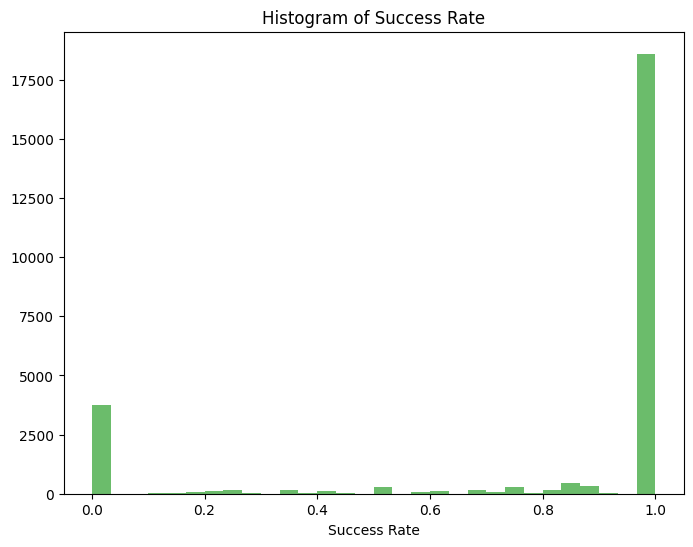

In [ ]:
# Histogram of success rate
plt.figure(figsize=(8, 6))
plt.hist(df_cleaned['SuccessRate'], bins=30, color='C2', alpha=0.7)
plt.title('Histogram of Success Rate')
plt.xlabel('Success Rate')

In [ ]:
df_cleaned_filt = df_cleaned.copy()
df_cleaned_filt = df_cleaned_filt.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
df_cleaned_filt.shape

(24851, 18)

In [ ]:
df_cleaned_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24851 entries, 1 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                24851 non-null  object 
 1   BookingType               24851 non-null  object 
 2   LeadSource                24851 non-null  object 
 3   Gender                    24851 non-null  object 
 4   Nationality               24851 non-null  object 
 5   CourseLevel               24851 non-null  object 
 6   IsFirstIntake             24851 non-null  bool   
 7   CompletedCourse           24851 non-null  object 
 8   AssessedModules           24851 non-null  float64
 9   PassedModules             24851 non-null  float64
 10  FailedModules             24851 non-null  float64
 11  ProgressionUniversity     24851 non-null  object 
 12  AuthorisedAbsenceCount    24851 non-null  float64
 13  UnauthorisedAbsenceCount  24851 non-null  float64
 14  Age        

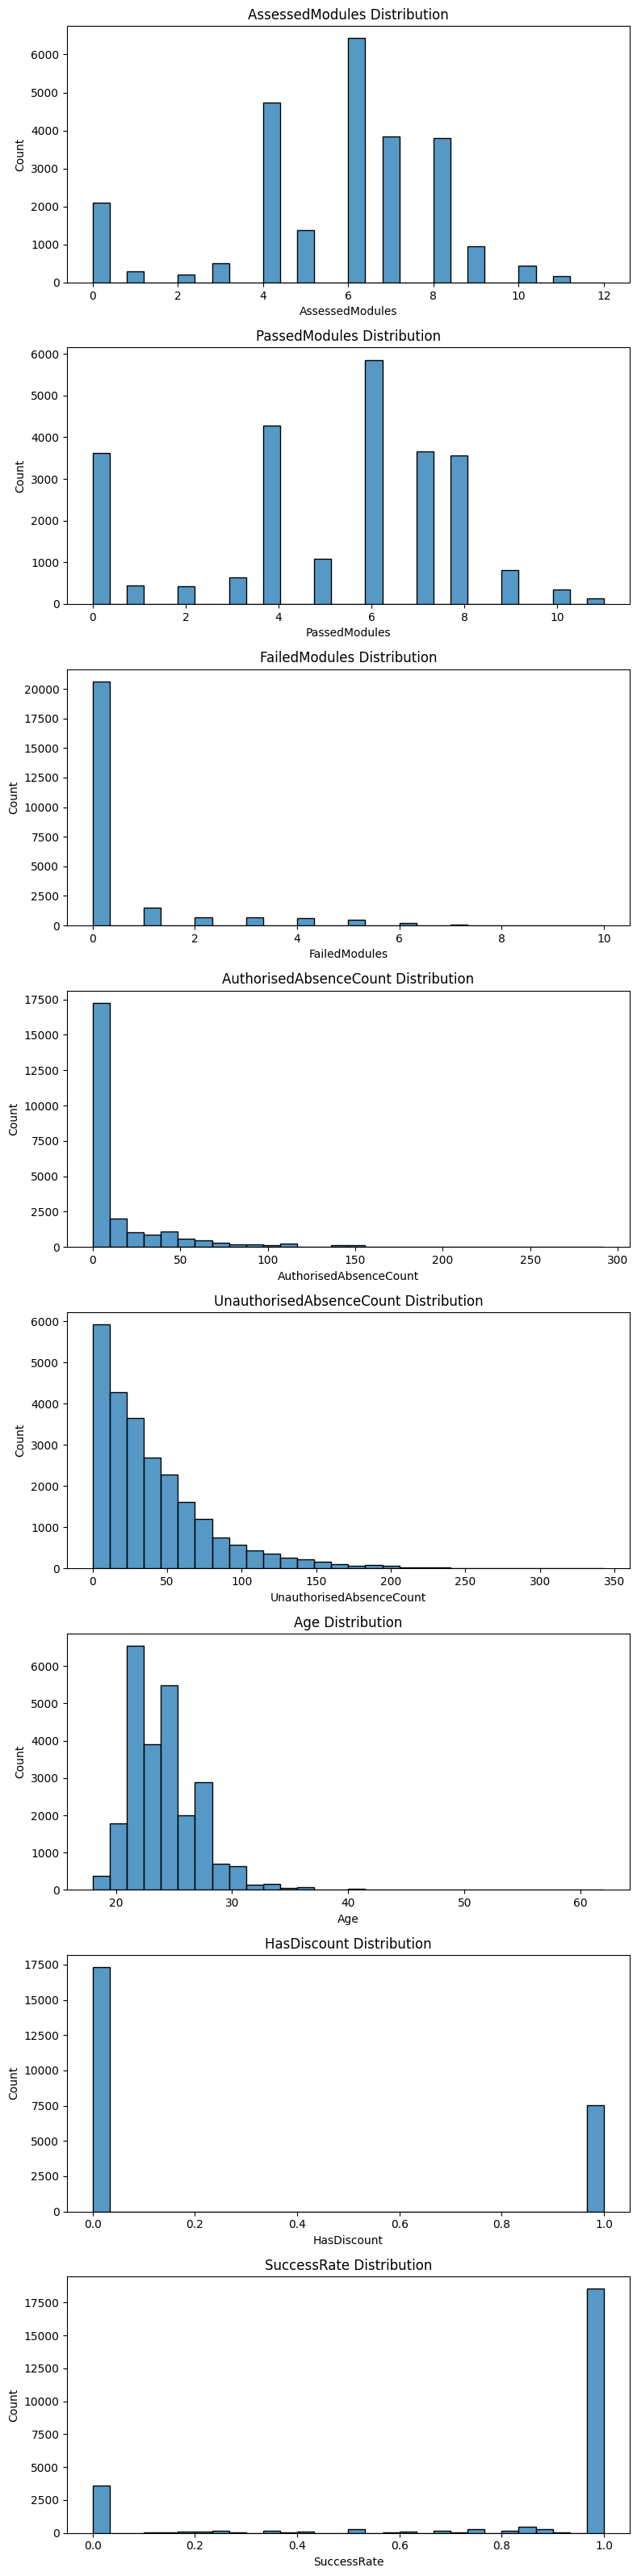

In [ ]:
numerical_features = df_cleaned_filt.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(8, 4 * len(numerical_features)))

for ax, feature in zip(axes, numerical_features):
    sns.histplot(df_cleaned_filt[feature], bins=30, kde=False, ax=ax)
    ax.set_title(f"{feature} Distribution")

plt.tight_layout()
plt.show()

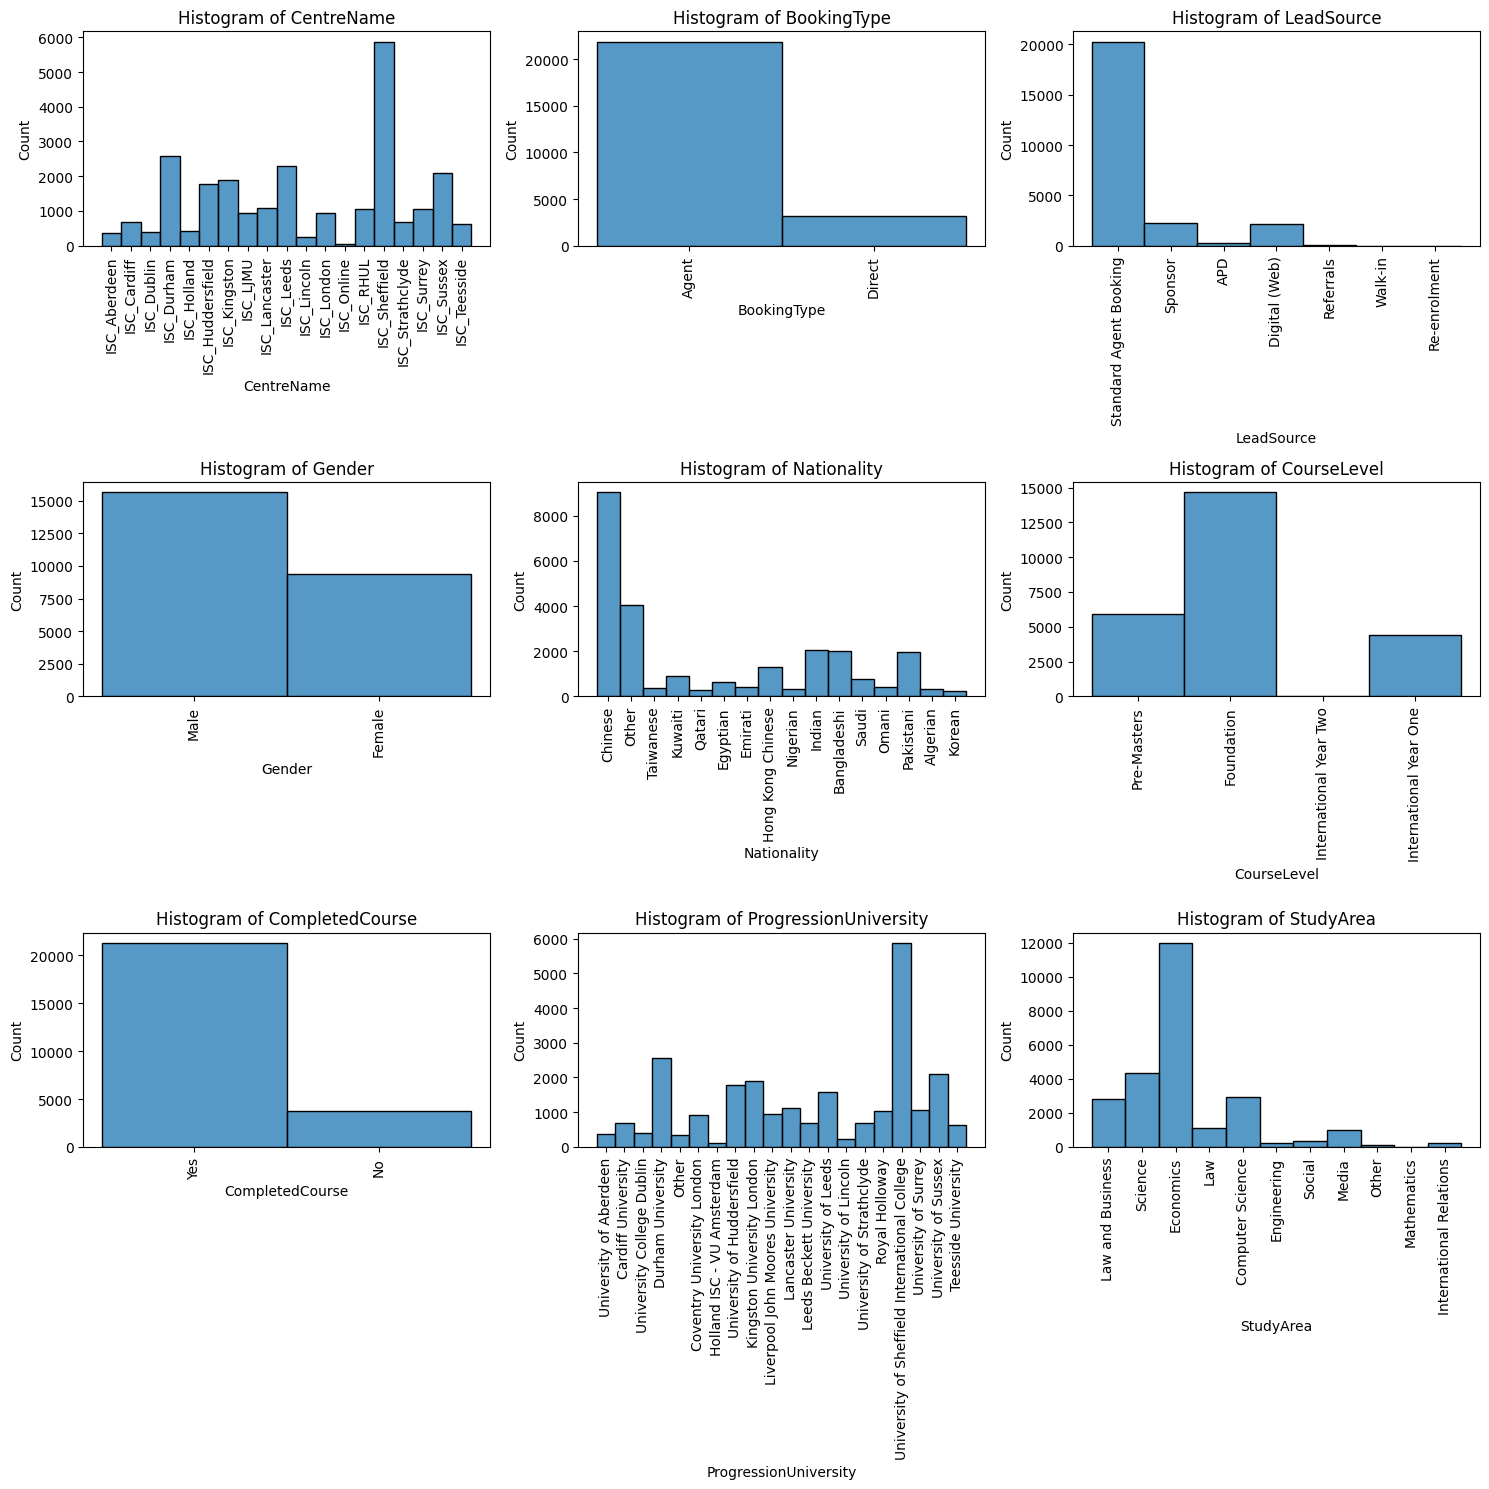

In [ ]:
object_cols = df_cleaned.select_dtypes(include='object').columns

# Calculate the number of rows and columns for subplots
num_plots = len(object_cols)
num_rows = (num_plots + 2) // 3  # Ensure enough rows for all plots
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through object columns and create histograms
for i, col in enumerate(object_cols):
  sns.histplot(df_cleaned[col], kde=False, ax=axes[i]) # kde=False to remove the kernel density estimation
  axes[i].set_title(f'Histogram of {col}')
  axes[i].tick_params(axis='x',rotation = 90) # Rotate x-axis labels for readability

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()

# Stage 3.2 - Encoding

In this section encoding is applied:
- Ordinal encoding wheter the feature's order matter
- One hot encoding wheter the fature's order doesn't matter

Looking at the dataset, it seems that the only ordinal variable is CourseLevel, since the order (Year one or year two) is important, and for this feature it has been decided to apply ordinal encodinge. For all the others, I decided to apply one hot encoding.

In [ ]:
df_cleaned_filt['CourseLevel'].unique()

array(['Foundation', 'International Year Two', 'Pre-Masters',
       'International Year One'], dtype=object)

In [ ]:
# The IsFirstIntake column is modified to be a numerical column (1,0)
df_cleaned_filt['IsFirstIntake'] = df_cleaned_filt['IsFirstIntake'].astype(int)

In [ ]:
order_mapping = {
    'Foundation': 0,
    'International Year One': 1,
    'International Year Two': 2,
    'Pre-Masters': 3
}
df_encoded = df_cleaned_filt.copy()
df_encoded['CourseLevel_encoded'] = df_cleaned_filt['CourseLevel'].map(order_mapping)
df_encoded.drop(columns=['CourseLevel'], inplace=True)


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24851 entries, 1 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                24851 non-null  object 
 1   BookingType               24851 non-null  object 
 2   LeadSource                24851 non-null  object 
 3   Gender                    24851 non-null  object 
 4   Nationality               24851 non-null  object 
 5   IsFirstIntake             24851 non-null  int64  
 6   CompletedCourse           24851 non-null  object 
 7   AssessedModules           24851 non-null  float64
 8   PassedModules             24851 non-null  float64
 9   FailedModules             24851 non-null  float64
 10  ProgressionUniversity     24851 non-null  object 
 11  AuthorisedAbsenceCount    24851 non-null  float64
 12  UnauthorisedAbsenceCount  24851 non-null  float64
 13  Age                       24851 non-null  int64  
 14  HasDiscount

In [ ]:
# For these columns where the subgroups were created, instead of deleting the first occurence, it has been deleted explicitly the column which contains the 'Other'. This to ensure a bettere explainability later on.
df_encoded = pd.get_dummies(df_encoded, columns=['Nationality', 'StudyArea','ProgressionUniversity'])
df_encoded = df_encoded.drop(columns=['Nationality_Other', 'StudyArea_Other','ProgressionUniversity_Other'])

In [ ]:
# Here I have to do a further modification to delete the column StudyArea_Law and Business which is redundant and put its information in the Law column and Economics column
df_encoded['StudyArea_Law'] |= df_encoded['StudyArea_Law and Business']
df_encoded['StudyArea_Economics'] |= df_encoded['StudyArea_Law and Business']
df_encoded.drop(columns=['StudyArea_Law and Business'], inplace=True)

In [ ]:
# For all the other categorical features, it has been applied one-hot encoding, deleting the first column
df_encoded = pd.get_dummies(df_encoded, columns=df_encoded.select_dtypes(include=['object']).columns, drop_first=True)
df_encoded.shape

(24851, 80)

In [ ]:
# In this cell all the boolean type columns are modified to have numerical values
for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype(int)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24851 entries, 1 to 25058
Data columns (total 80 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   IsFirstIntake                                                        24851 non-null  int64  
 1   AssessedModules                                                      24851 non-null  float64
 2   PassedModules                                                        24851 non-null  float64
 3   FailedModules                                                        24851 non-null  float64
 4   AuthorisedAbsenceCount                                               24851 non-null  float64
 5   UnauthorisedAbsenceCount                                             24851 non-null  float64
 6   Age                                                                  24851 non-null  int64  
 7   HasDiscou

In [ ]:
X = df_encoded.drop(columns=['CompletedCourse_Yes'])
y = df_encoded['CompletedCourse_Yes']
y.name = 'target'

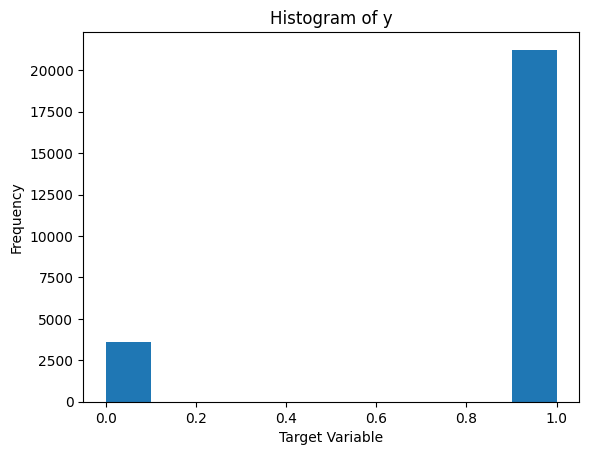

The dataset is composed of 85.5 % of students who completed the course and 14.5 who did not 


In [ ]:
plt.hist(y)
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Histogram of y')
plt.show()

print(f'The dataset is composed of {round(100*y.value_counts()[1]/y.shape[0],1)} % of students who completed the course and {round(100*y.value_counts()[0]/y.shape[0],1)} who did not ')


The distribution of output values reveals a class imbalance in the dataset. This suggests that standard accuracy may not be a reliable evaluation metric. Instead, metrics like AUC-ROC, precision-recall curves, and F1-score should be considered to better assess the model's performance, especially in handling minority classes.

In [ ]:
df_encoded.describe()

IsFirstIntake  AssessedModules  PassedModules  FailedModules  \
count   24851.000000     24851.000000   24851.000000   24851.000000   
mean        0.120035         5.581908       5.116776       0.465132   
std         0.325009         2.421783       2.740905       1.258029   
min         0.000000         0.000000       0.000000       0.000000   
25%         0.000000         4.000000       4.000000       0.000000   
50%         0.000000         6.000000       6.000000       0.000000   
75%         0.000000         7.000000       7.000000       0.000000   
max         1.000000        12.000000      11.000000      10.000000   

       AuthorisedAbsenceCount  UnauthorisedAbsenceCount           Age  \
count            24851.000000              24851.000000  24851.000000   
mean                15.120639                 40.491892     24.033077   
std                 28.918253                 39.029384      3.161557   
min                  0.000000                  0.000000     18.000000   
25%                  0.000000                 12.000000     22.000000   
50%                  1.000000                 29.000000     23.000000   
75%                 15.000000                 56.000000     26.000000   
max                292.000000                343.000000     62.000000   

        HasDiscount   SuccessRate  CourseLevel_encoded  ...  \
count  24851.000000  24851.000000         24851.000000  ...   
mean       0.303328      0.811219             0.883385  ...   
std        0.459705      0.365781             1.230008  ...   
min        0.000000      0.000000             0.000000  ...   
25%        0.000000      0.888889             0.000000  ...   
50%        0.000000      1.000000             0.000000  ...   
75%        1.000000      1.000000             1.000000  ...   
max        1.000000      1.000000             3.000000  ...   

       CentreName_ISC_Teesside  BookingType_Direct  LeadSource_Digital (Web)  \
count             24851.000000        24851.000000              24851.000000   
mean                  0.024667            0.127319                  0.084745   
std                   0.155111            0.333336                  0.278508   
min                   0.000000            0.000000                  0.000000   
25%                   0.000000            0.000000                  0.000000   
50%                   0.000000            0.000000                  0.000000   
75%                   0.000000            0.000000                  0.000000   
max                   1.000000            1.000000                  1.000000   

       LeadSource_Re-enrolment  LeadSource_Referrals  LeadSource_Sponsor  \
count             24851.000000          24851.000000        24851.000000   
mean                  0.000121              0.004708            0.090942   
std                   0.010987              0.068455            0.287532   
min                   0.000000              0.000000            0.000000   
25%                   0.000000              0.000000            0.000000   
50%                   0.000000              0.000000            0.000000   
75%                   0.000000              0.000000            0.000000   
max                   1.000000              1.000000            1.000000   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in   Gender_Male  \
count                        24851.00000        24851.000000  24851.000000   
mean                             0.80878            0.000845      0.623637   
std                              0.39327            0.029058      0.484483   
min                              0.00000            0.000000      0.000000   
25%                              1.00000            0.000000      0.000000   
50%                              1.00000            0.000000      1.000000   
75%                              1.00000            0.000000      1.000000   
max                              1.00000            1.000000      1.000000   

       CompletedCourse_Yes  
cou

# Stage 3.3 - XGBoost Algorithm

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0],X_test.shape[0])

19880 4971


XGBoost Model Accuracy:  0.99
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       727
           1       0.99      1.00      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.98      0.97      0.98      4971
weighted avg       0.99      0.99      0.99      4971

XGBoost Model AUC: 1.0


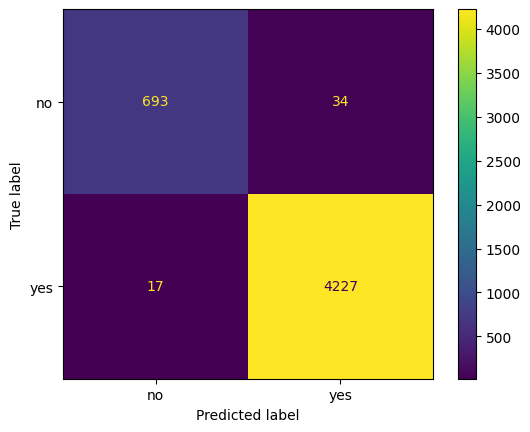

In [ ]:
xg_model_base_3 = xgb.XGBClassifier(random_state=42)
xg_model_base_3.fit(X_train, y_train)

# Model evaluation
predictions = xg_model_base_3.predict(X_test)
cr_xbg_base_3 = classification_report(y_test, predictions)
print("XGBoost Model Accuracy: ", np.round(accuracy_score(y_test, predictions),2))
print(cr_xbg_base_3)

y_prob = xg_model_base_3.predict_proba(X_test)[:, 1]
auc_score_xgb_base_3 = roc_auc_score(y_test, y_prob)
print("XGBoost Model AUC:", np.round(auc_score_xgb_base_3, 2))


cm_xgb_base_3 = confusion_matrix(y_test, predictions)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_3, display_labels=["no","yes"])
cfmd.plot()
plt.show()

It can be seen that the performances of this model are much better than the previous models. The class 0 (underrepresented) shows high precision and accuracy. The AUC is close 1, indicating an excellent ability of the model to distinguish the 2 classes.

To improve the model's performance, a grid search is performed.

The parameters considered in the optimization loop are:

- Max depth
- Learning rate
- Number of estimators

In [ ]:
# Hash map of parameters to test
param_grid = {
    "learning_rate": [0.05,0.03, 0.01],
    "max_depth": [4, 6, 8, 10]
}

# Start e end per n_estimators
start = 100
end = 1500

def increment_fn(n):
    if n > 400:
        return 200
    else:
        return 100

increment = increment_fn(start)

# Results List
results = []

# Main loop
for lr in param_grid["learning_rate"]:
    for depth in param_grid["max_depth"]:
        n = start
        while n <= end:
            model = xgb.XGBClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n,
                random_state=42, eval_metric='logloss'
            )
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

            # metrics calculation
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            report = classification_report(y_test, y_pred, output_dict=True)

            train_loss = log_loss(y_train, model.predict_proba(X_train))
            test_loss = log_loss(y_test, y_prob)

            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)
            # Salvataggio delle metriche
            metrics = {
                    "learning_rate": lr,
                    "max_depth": depth,
                    "n_estimators": n,
                    "train_loss": train_loss,
                    "accuracy": report["accuracy"],
                    "precision_0": report["0"]["precision"],
                    "recall_0": report["0"]["recall"],
                    "f1_0": report["0"]["f1-score"],
                    "precision_1": report["1"]["precision"],
                    "recall_1": report["1"]["recall"],
                    "f1_1": report["1"]["f1-score"],
                    "auc": roc_auc_score(y_test, y_prob),
                    "test_loss": test_loss,
                    "confusion_matrix": cm,
                    "classification_report": cr
                }


            results.append(metrics)
            increment = increment_fn(n)
            prev_test_loss = test_loss
            n += increment
            print(f"With  lr = {lr}and max depth = {depth} and {n} number of estimators the losses are:")
            print(f'Training loss = {np.round(train_loss,3)}, Test loss = Training loss = {np.round(test_loss,3)}')
            print('------------------------------------------------------------')


With  lr = 0.05and max depth = 4 and 200 number of estimators the losses are:
Training loss = 0.033, Test loss = Training loss = 0.043
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 300 number of estimators the losses are:
Training loss = 0.024, Test loss = Training loss = 0.037
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 400 number of estimators the losses are:
Training loss = 0.02, Test loss = Training loss = 0.035
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 500 number of estimators the losses are:
Training loss = 0.017, Test loss = Training loss = 0.034
------------------------------------------------------------
With  lr = 0.05and max depth = 4 and 700 number of estimators the losses are:
Training loss = 0.015, Test loss = Training loss = 0.034
------------------------------------------------------------
With  lr = 0.05and ma

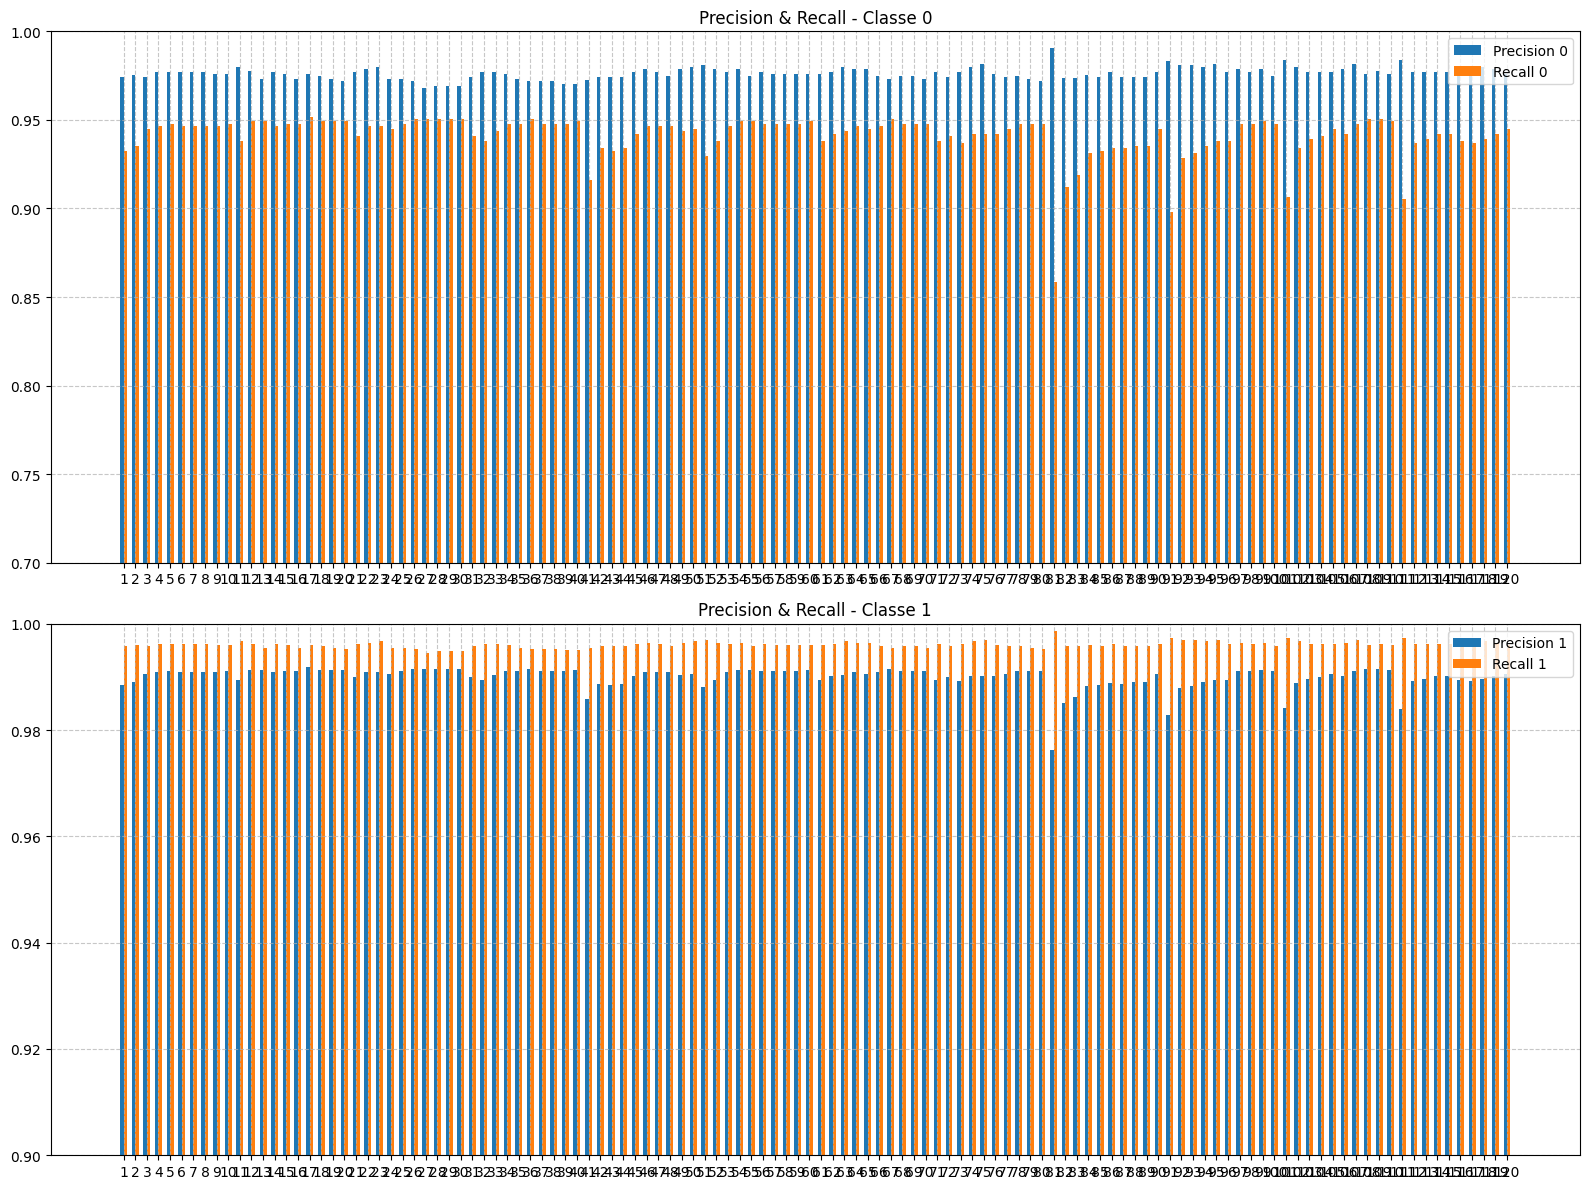

In [ ]:
precision_0 = [r["precision_0"] for r in results]
recall_0 = [r["recall_0"] for r in results]
precision_1 = [r["precision_1"] for r in results]
recall_1 = [r["recall_1"] for r in results]

x = np.arange(len(results))

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].bar(x - bar_width / 2, precision_0, bar_width, label="Precision 0")
axes[0].bar(x + bar_width / 2, recall_0, bar_width, label="Recall 0")
axes[0].set_title("Precision & Recall - Classe 0")
axes[0].set_xticks(np.arange(len(results)))
axes[0].set_xticklabels(range(1, len(results) + 1))
axes[0].set_ylim(0.7,1)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width / 2, precision_1, bar_width, label="Precision 1")
axes[1].bar(x + bar_width / 2, recall_1, bar_width, label="Recall 1")
axes[1].set_title("Precision & Recall - Classe 1")
axes[1].set_xticks(np.arange(len(results)))
axes[1].set_xticklabels(range(1, len(results) + 1))
axes[1].set_ylim(0.9, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


After an hyperparameter optimization loop, we observe that the model's performance remains quite similar to the baseline model in terms of precision and recall for class 0 and class 1. One possible explanation is that the dataset imbalance limits the model's ability to learn meaningful patterns for the minority class, making hyperparameter tuning less impactful. Additionally, the default XGBoost parameters may already provide a strong baseline, suggesting that further improvements might require data augmentation  or alternative modeling approaches.

In [ ]:
best_recall = 0
best_precision = 0

for i in range(len(results)):
    if results[i]["recall_0"] > best_recall:
        best_recall = results[i]["recall_0"]
        best_recall_index = i
    if results[i]["precision_0"] > best_precision:
      best_precision = results[i]["precision_0"]
      best_precision_index = i

print('Best recall configuration has a recall for the class 0 (underrepresented) of', np.round(best_recall, 2),
      'and a precision of', np.round(results[best_recall_index]["precision_0"], 2))
print('The configuration is: learning rate =', results[best_recall_index]['learning_rate'],
      ', max depth =', results[best_recall_index]['max_depth'],
      ', number of estimators =', results[best_recall_index]['n_estimators'])
print('-----------------------------------------------------')
print('Best precision configuration has a recall for the class 0 (underrepresented) of',
      np.round(results[best_precision_index]["recall_0"], 2),
      'and a precision of', np.round(best_precision, 2))
print('The configuration is: learning rate =', results[best_precision_index]['learning_rate'],
      ', max depth =', results[best_precision_index]['max_depth'],
      ', number of estimators =', results[best_precision_index]['n_estimators'])

opt_lr = results[best_recall_index]['learning_rate']
opt_depth = results[best_recall_index]['max_depth']
opt_n_est = results[best_recall_index]['n_estimators']
cm_xgb_best_3 = results[best_recall_index]['confusion_matrix']
cr_xbg_best_3 = results[best_recall_index]['classification_report']
auc_score_xgb_best_3 = results[best_recall_index]['auc']


Best recall configuration has a recall for the class 0 (underrepresented) of 0.95 and a precision of 0.98
The configuration is: learning rate = 0.05 , max depth = 6 , number of estimators = 900
-----------------------------------------------------
Best precision configuration has a recall for the class 0 (underrepresented) of 0.86 and a precision of 0.99
The configuration is: learning rate = 0.01 , max depth = 4 , number of estimators = 100


The dataset under analysis is imbalanced. In this case, the goal is to maximize recall, as it is preferable to identify more students in class 0 (who will not complete the course), even at the cost of increasing false positives.

Below the comparison between the base model (with default hyperparameters) and the model optimized through grid search to maximize the recall of the class 0.

Classification report for the base Model
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       727
           1       0.99      1.00      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.98      0.97      0.98      4971
weighted avg       0.99      0.99      0.99      4971

Classification report for the optimal Model
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       727
           1       0.99      1.00      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.98      0.97      0.98      4971
weighted avg       0.99      0.99      0.99      4971

XGBoost base Model AUC: 0.998
XGBoost base Model AUC: 0.999


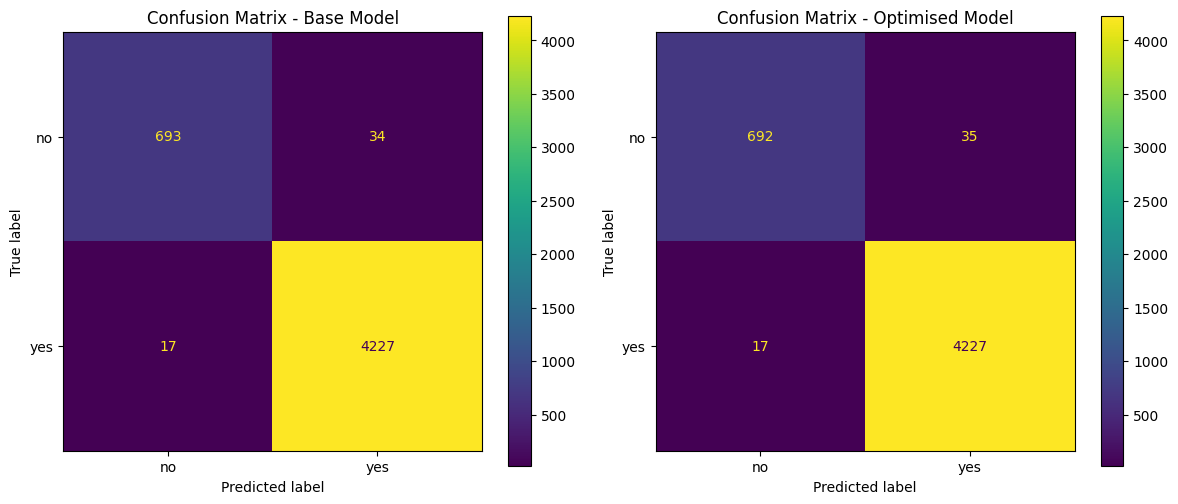

In [ ]:
print('Classification report for the base Model')
print(cr_xbg_base_3)
print('Classification report for the optimal Model')
print(cr_xbg_best_3)

print("XGBoost base Model AUC:", np.round(auc_score_xgb_base_3, 3))
print("XGBoost base Model AUC:", np.round(auc_score_xgb_best_3, 3))


cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base_3, display_labels=["no","yes"])
cfmd_opt = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best_3, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cfmd.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix - Base Model")
cfmd_opt.plot(ax=axes[1])
axes[1].set_title("Confusion Matrix - Optimised Model")
plt.tight_layout()
plt.show()


The performance of both models is practically identical, indicating that the default parameter configuration is already quite robust. This suggests that the dataset contains a wealth of informative features, allowing XGBoost to perform well even with varying hyperparameter settings. The model’s stability across different configurations highlights its ability to effectively capture the underlying patterns in the data.

Stage 1.3.1 Feature Importance

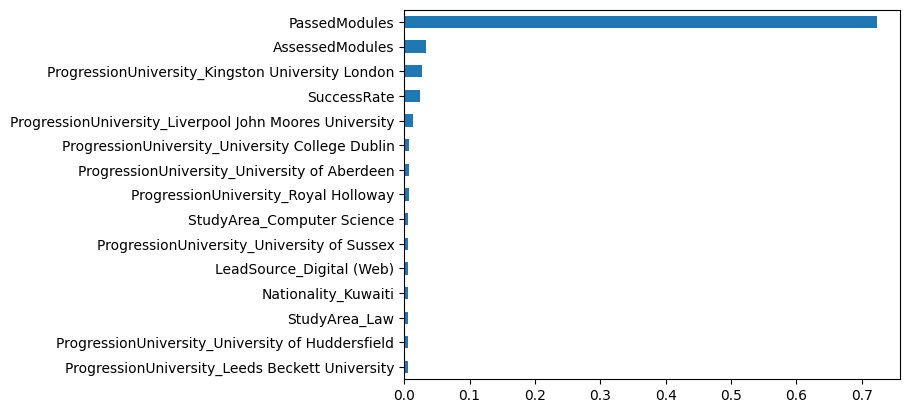

In [ ]:
xg_model_opt = xgb.XGBClassifier(random_state=42,learning_rate=opt_lr, max_depth=opt_depth, n_estimators=opt_n_est)
xg_model_opt.fit(X_train, y_train)
feature_importance = pd.Series(xg_model_opt.feature_importances_, index=X_train.columns).sort_values()

feature_importance.iloc[-15:].plot.barh()
plt.show()

From the feature importance plot, we can see that the most influential feature is passed modules. This indicates that the number of modules a student has successfully completed is a strong predictor of whether they will continue the course. Students who have passed more modules are more likely to persist, and the model leverages this feature to effectively differentiate between those at risk of dropping out and those likely to complete the course. This suggests that academic progress plays a crucial role in student retention, making it a key factor in the model's decision-making process.

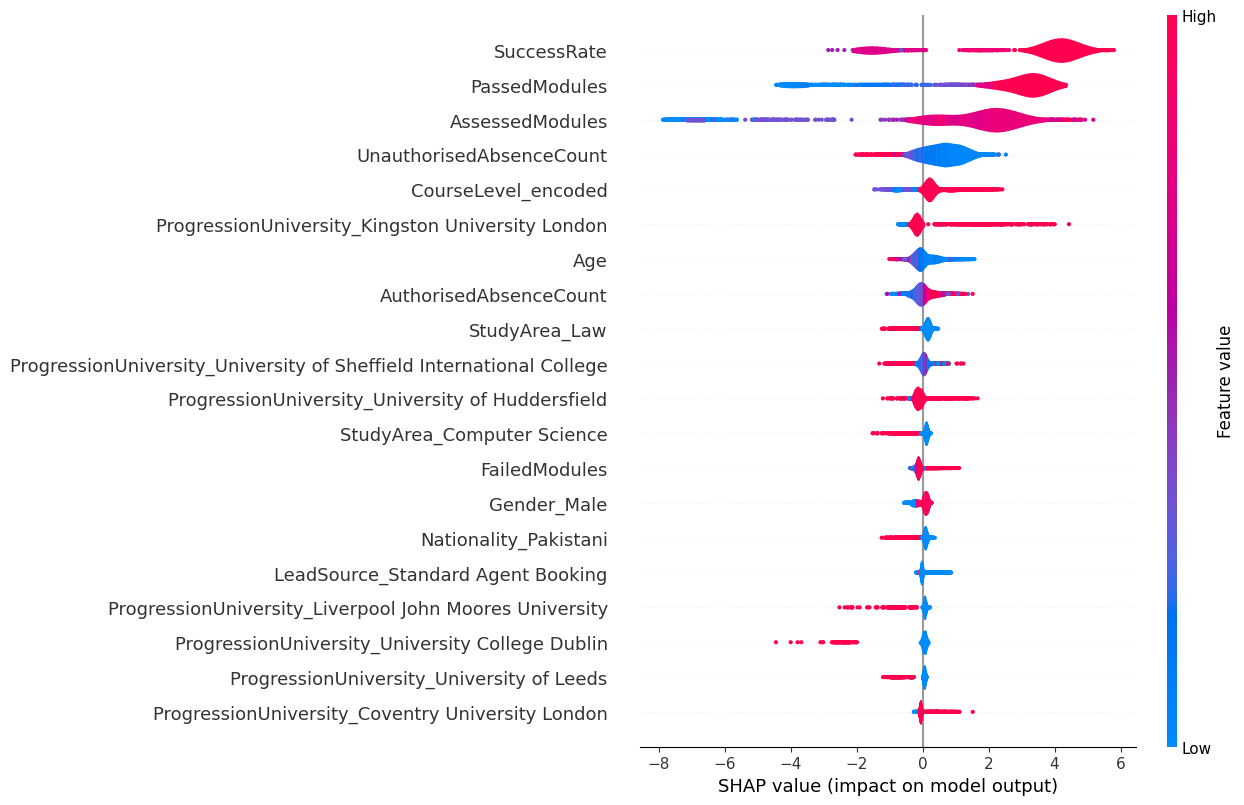

In [ ]:

shap.initjs()
shap_ex = shap.TreeExplainer(xg_model_opt)
vals = shap_ex(X_test)
shap.plots.violin(vals)

From the SHAP plot, we can observe that the features passed modules and assessed modules have a strong influence in pushing the model’s predictions toward class 1. Specifically, higher values of these features increase the likelihood of predicting class 1, indicating that students who have completed and been assessed on more modules are more likely to continue the course. Conversely, lower values strongly shift the prediction toward class 0, suggesting a higher dropout risk.

Regarding success rate, we notice a different pattern: very high values significantly push the prediction toward class 1, reinforcing the idea that consistently successful students are likely to persist. However, intermediate/low values tend to have the opposite effect, decreasing the likelihood of predicting class 1, possibly indicating that moderate but inconsistent performance may be a warning sign for dropout risk.

# Stage 3.4 - Neural Network

In [ ]:
# Trova le colonne con più di 2 valori unici (non binarie)
num_cols = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Inizializza lo scaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Applica lo scaling solo alle colonne selezionate
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_train_scaled.head()

IsFirstIntake  AssessedModules  PassedModules  FailedModules  \
6664               0        -0.238209      -0.041148      -0.369734   
17815              1         0.174947       0.323717      -0.369734   
23633              0         1.001257       1.053449      -0.369734   
10108              0         0.174947      -0.041148       0.427480   
4913               0        -0.238209      -1.135745       2.021910   

       AuthorisedAbsenceCount  UnauthorisedAbsenceCount       Age  \
6664                -0.522867                  0.368126 -0.327936   
17815               -0.350383                 -0.602403 -0.962889   
23633                1.339958                  0.751230 -0.962889   
10108               -0.522867                  0.393666 -1.597842   
4913                 0.719016                  0.112724 -0.327936   

       HasDiscount  SuccessRate  CourseLevel_encoded  ...  \
6664             0     0.515894             0.093131  ...   
17815            1     0.515894            -0.720687  ...   
23633            1     0.515894             0.093131  ...   
10108            0     0.060506            -0.720687  ...   
4913             0    -1.123502             0.093131  ...   

       CentreName_ISC_Sussex  CentreName_ISC_Teesside  BookingType_Direct  \
6664                       0                        0                   0   
17815                      0                        0                   0   
23633                      1                        0                   0   
10108                      0                        0                   0   
4913                       0                        0                   0   

       LeadSource_Digital (Web)  LeadSource_Re-enrolment  \
6664                          0                        0   
17815                         0                        0   
23633                         0                        0   
10108                         0                        0   
4913                          0                        0   

       LeadSource_Referrals  LeadSource_Sponsor  \
6664                      0                   0   
17815                     0                   0   
23633                     0                   0   
10108                     0                   1   
4913                      0                   0   

       LeadSource_Standard Agent Booking  LeadSource_Walk-in  Gender_Male  
6664                                   1                   0            1  
17815                                  1                   0            1  
23633                                  1                   0            1  
10108                                  0                   0            1  
4913                                   1                   0            1  

[5 rows x 79 columns]

Here 2 functions are created to create and then evaluate a model.

To check a possibile overfitting, 10% of the training data are used as validation data.

In [ ]:
def create_model(learning_rate=0.001, activation='relu', n_neuron_1=32, n_neuron_2=16, optimizer_type='adam'):
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(n_neuron_1, activation=activation)(inputs)
    x = Dense(n_neuron_2, activation=activation)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

    return model

def train_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)

    return accuracy, precision, recall, history

In [ ]:
model_base_3 = create_model(learning_rate=0.001, activation='relu')
accuracy, precision,recall, history = train_evaluate_model(model_base_3, X_train_scaled, y_train, X_test_scaled, y_test)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


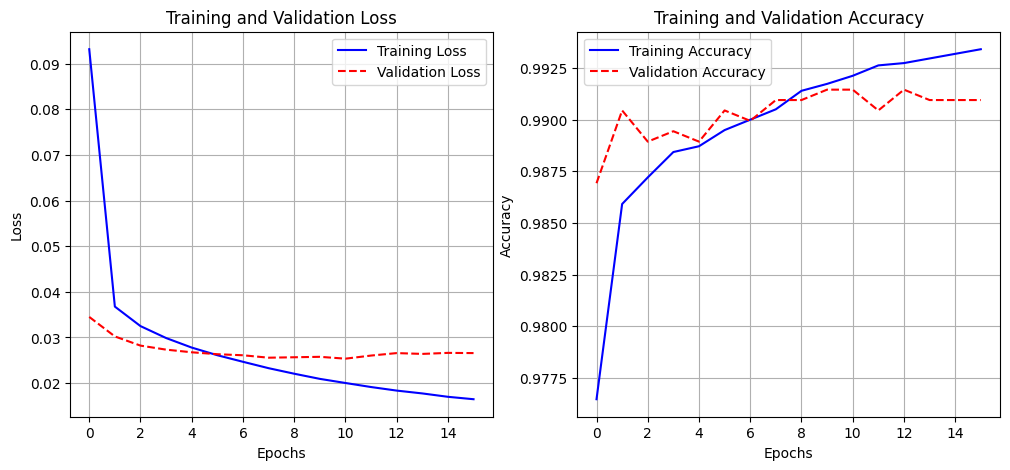

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network, accuracy score:  0.99
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       727
           1       0.99      0.99      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.97      0.97      0.97      4971
weighted avg       0.99      0.99      0.99      4971



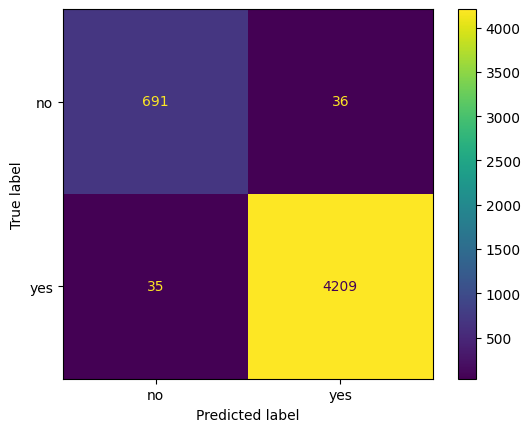

In [ ]:
y_pred = (model_base_3.predict(X_test_scaled) > 0.5).astype(int)

cr_nn_base_3 = classification_report(y_test, y_pred)
print("Neural Network, accuracy score: ", np.round(accuracy_score(y_test, y_pred),2))
print(cr_nn_base_3)

cm_nn_base_3 = confusion_matrix(y_test, y_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_3, display_labels=["no","yes"])
cfmd.plot()
plt.show()

The nn base model shows super

To try to otpimize the performance of the model, a grid search is implemented.
The parameters considered in the optimization are:

- Learning rate
- Number of neuron of hidden layer 1, while the number of neuron for the second hidden layer are half of those of hid layer 1 --> this is a semplification but it can help to reduce the computation time
- Activation functions of the hidden layer
- Optimizer (Adam, RMSProp)

An early stopping has been implemented with a patience of 5, to avoid having too much overfitting.

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
n_neuron_1 = [32, 64, 128]
activations = ['relu', 'tanh','sigmoid']
optimizer_types = ['adam', 'rmsprop']
results = []

for optimizer in optimizer_types:
    for lr in learning_rates:
        for activation in activations:
            for n_neuron in n_neuron_1:
                n_neuron_2 = int(n_neuron / 2)
                model = create_model(learning_rate=lr, activation=activation, n_neuron_1=n_neuron, n_neuron_2=n_neuron_2, optimizer_type=optimizer)
                accuracy, precision, recall, history = train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, batch_size=64)

                cr = classification_report(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                cm = confusion_matrix(y_test, (model.predict(X_test_scaled) > 0.5).astype(int))
                auc = roc_auc_score(y_test, model.predict(X_test_scaled))

                results.append({
                    'learning_rate': lr,
                    'batch_size': 64,
                    'activation': activation,
                    'optimizer': optimizer,
                    'n_neuron_1': n_neuron,
                    'n_neuron_2': n_neuron_2,
                    'accuracy': accuracy,
                    'precision_class_0': precision[0],
                    'precision_class_1': precision[1],
                    'recall_class_0': recall[0],
                    'recall_class_1': recall[1],
                    'auc_score' : auc,
                    'classification_report': cr,
                    'confusion_matrix': cm
                })
                print(results[-1])

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 'batch_size': 64, 'activation': 'relu', 'optimizer': 'adam', 'n_neuron_1': 32, 'n_neuron_2': 16, 'accuracy': 0.9849124924562462, 'precision_class_0': 0.9429347826086957, 'precision_class_1': 0.9922077922077922, 'recall_class_0': 0.9546079779917469, 'recall_class_1': 0.9901036757775683, 'auc_score': 0.9980320141259381, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.95       727\n           1       0.99      0.99      0.99      4244\n\n    accuracy                           0.98      4971\n   macro avg       0.97      0.97      0.97      4971\nweighted avg       0.99      0.98      0.98      4971\n', 'confusion_matrix': array([[ 694,   33],
       [  42, 4202]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
156/156 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 83/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.1, 'batch_size': 64, 'activation': 'sigmoid', 'optimizer': 'adam', 'n_neuron_1': 128, 'n_neuron_2': 64, 'accuracy': 0.8537517602092134, 'precision_class_0': 0.0, 'precision_class_1': 0.8537517602092134, 'recall_class_0': 0.0, 'recall_class_1': 1.0, 'auc_score': 0.5001178133836004, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       727\n           1       0.85      1.00      0.92      4244\n\n    accuracy                           0.85      4971\n   macro avg       0.43      0.50      0.46      4971\nweighted avg       0.73      0.85      0.79      4971\n', 'confusion_matrix': array([[   0,  727],
       [   0, 4244]])}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'learning_rate': 0.001, 

In [ ]:
# During the grid search of the neural network, some NN models didn't predict any class 0 individual. For this reasons, these models are filtered out
results = [r for r in results if r['recall_class_0'] > 0]

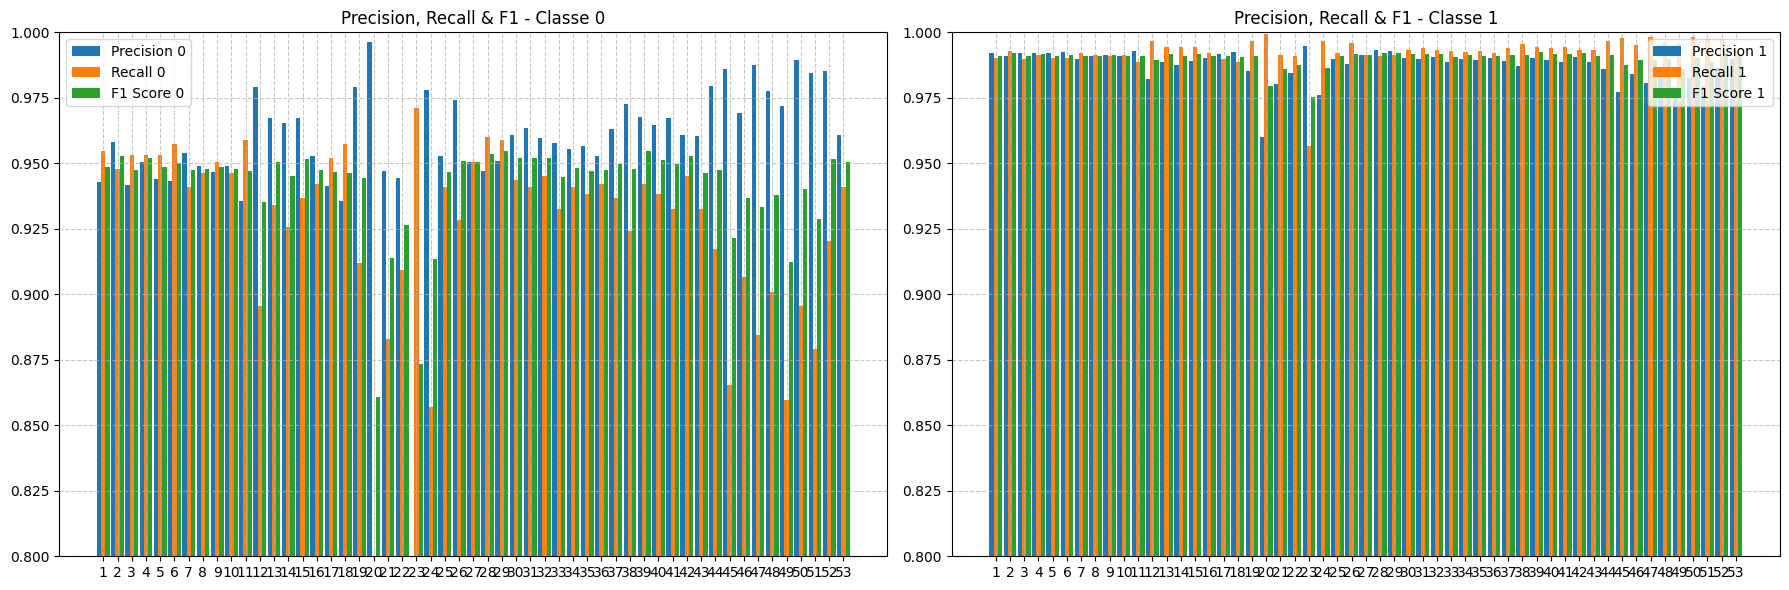

In [ ]:
precision_0 = [res["precision_class_0"] for res in results]
recall_0 = [res["recall_class_0"] for res in results]
precision_1 = [res["precision_class_1"] for res in results]
recall_1 = [res["recall_class_1"] for res in results]

f1_0 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_0, recall_0)]
f1_1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_1, recall_1)]

n = len(results)
x = np.arange(n)
bar_width = 0.3

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(x - bar_width, precision_0, bar_width, label="Precision 0")
axes[0].bar(x, recall_0, bar_width, label="Recall 0")
axes[0].bar(x + bar_width, f1_0, bar_width, label="F1 Score 0")
axes[0].set_title("Precision, Recall & F1 - Classe 0")
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, n+1))
axes[0].set_ylim(0.8, 1)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend()

axes[1].bar(x - bar_width, precision_1, bar_width, label="Precision 1")
axes[1].bar(x, recall_1, bar_width, label="Recall 1")
axes[1].bar(x + bar_width, f1_1, bar_width, label="F1 Score 1")
axes[1].set_title("Precision, Recall & F1 - Classe 1")
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, n+1))
axes[1].set_ylim(0.8, 1)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()


From the various network configurations, it can be observed that performance is quite sensitive to changes in hyperparameters. Since it is not entirely clear which model is the best, both the harmonic F1 score across classes and the weighted F1 score were calculated.

The best model was not selected solely based on the recall of class 0, but rather using the F1 score, which provides a more comprehensive evaluation of the model's overall performance. Relying only on recall for class 0 could have led to a model that is overly biased toward capturing that class while significantly reducing precision for both class 0 and class 1, ultimately making the predictions less reliable.

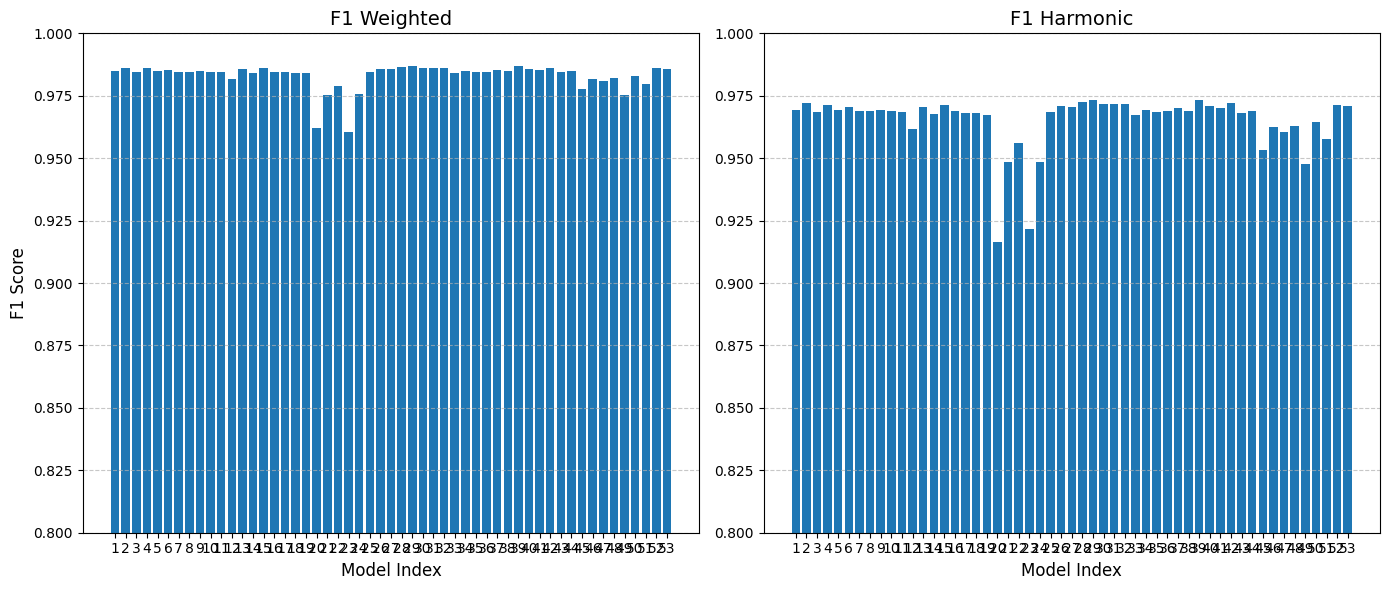

In [ ]:
f1_armonic = [(2 * f_0 * f_1) / (f_0 + f_1) for f_0, f_1 in zip(f1_0, f1_1)]
f1_weighted = [(y_test.value_counts()[0] * f_0 + y_test.value_counts()[1] * f_1) / (y_test.value_counts()[0] + y_test.value_counts()[1]) for f_0, f_1 in zip(f1_0, f1_1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(f1_weighted))

axes[0].bar(x, f1_weighted)
axes[0].set_title("F1 Weighted", fontsize=14)
axes[0].set_xlabel("Model Index", fontsize=12)
axes[0].set_ylabel("F1 Score", fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, len(f1_weighted) + 1))
axes[0].set_ylim(0.8, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(x, f1_armonic)
axes[1].set_title("F1 Harmonic", fontsize=14)
axes[1].set_xlabel("Model Index", fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, len(f1_armonic) + 1))
axes[1].set_ylim(0.8,1)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


From the plots, it can be seen that the F1 weighted score is not too sensitive to the model, while the harmonic F1 score is quite consistent, except from some models who have lower values respect to the average of the others.

Since the dataset is imbalanced, the weighted F1 score is heavily influenced by the majority class, making it less reliable in evaluating overall model performance. The harmonic F1 score, on the other hand, ensures that both classes contribute equally to the evaluation, preventing the model from being biased toward the dominant class.

Therefore, the best model is selected based on the harmonic F1 score.

In [ ]:
best_f1_armonic = 0

for i in range(len(f1_armonic)):
    if f1_armonic[i] > best_f1_armonic:
        best_f1_armonic = f1_armonic[i]
        best_f1_armonic_index = i


print('Best model configuration has been chosen to maximize the F1 armonic, which is for the best model', np.round(best_f1_armonic, 2), )
print("The configuration is:")
for key, value in results[best_f1_armonic_index].items():
    print(f"{key}: {value}")
nn_lr_opt = results[best_f1_armonic_index]['learning_rate']
nn_batch_size = results[best_f1_armonic_index]['batch_size']
nn_activation = results[best_f1_armonic_index]['activation']
nn_optimizer = results[best_f1_armonic_index]['optimizer']
n_neuron_1 = results[best_f1_armonic_index]['n_neuron_1']
n_neuron_2 = results[best_f1_armonic_index]['n_neuron_2']
auc_score_nn_best_3 = results[best_f1_armonic_index]['auc_score']
cm_nn_best_3 = results[best_f1_armonic_index]['confusion_matrix']
cr_nn_best_3 = results[best_f1_armonic_index]['classification_report']

Best model configuration has been chosen to maximize the F1 armonic, which is for the best model 0.97
The configuration is:
learning_rate: 0.01
batch_size: 64
activation: tanh
optimizer: rmsprop
n_neuron_1: 32
n_neuron_2: 16
accuracy: 0.9869241601287467
precision_class_0: 0.9675141242937854
precision_class_1: 0.9901477832512315
recall_class_0: 0.9422283356258597
recall_class_1: 0.9945805843543827
auc_score: 0.9972454031713354
classification_report:               precision    recall  f1-score   support

           0       0.97      0.94      0.95       727
           1       0.99      0.99      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.98      0.97      0.97      4971
weighted avg       0.99      0.99      0.99      4971

confusion_matrix: [[ 685   42]
 [  23 4221]]


Classification report for the NN base model:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       727
           1       0.99      0.99      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.97      0.97      0.97      4971
weighted avg       0.99      0.99      0.99      4971

Classification report for the NN optimal model:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       727
           1       0.99      0.99      0.99      4244

    accuracy                           0.99      4971
   macro avg       0.98      0.97      0.97      4971
weighted avg       0.99      0.99      0.99      4971



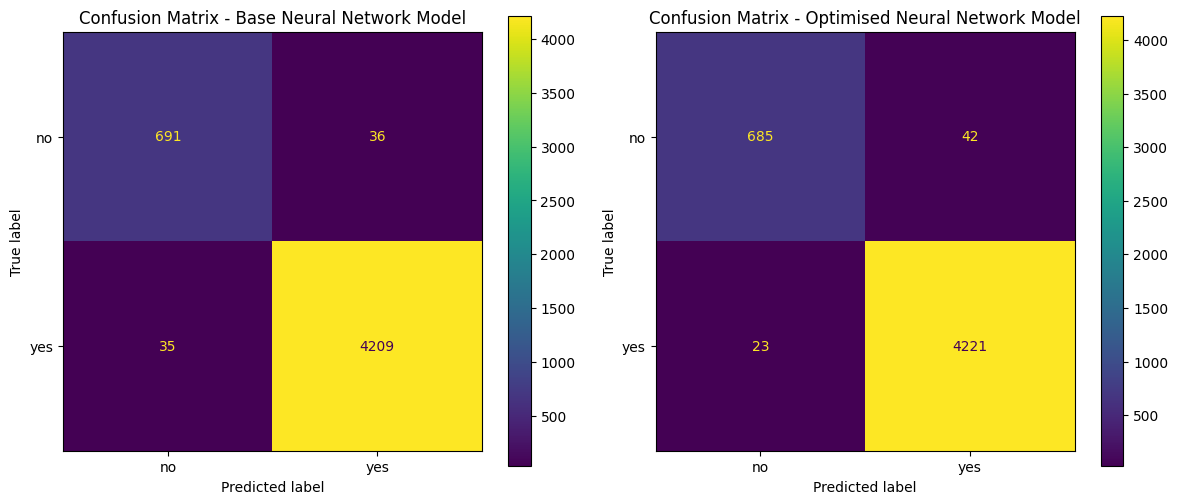

In [ ]:
print('Classification report for the NN base model:')
print(cr_nn_base_3)

print('Classification report for the NN optimal model:')
print(cr_nn_best_3)


cfmd_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn_base_3, display_labels=["no","yes"])
cfmd_nn_opt = ConfusionMatrixDisplay(confusion_matrix=cm_nn_best_3, display_labels=["no","yes"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Confusion Matrix - Base Neural Network Model")
cfmd.plot(ax=axes[0])

axes[1].set_title("Confusion Matrix - Optimised Neural Network Model")
cfmd_nn_opt.plot(ax=axes[1])

plt.tight_layout()
plt.show()



The otpimized model shows the same F1 score on class 0, with higher precision and lower recall respect to the base model. Anyway, their predictions are pretty well aligned



156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


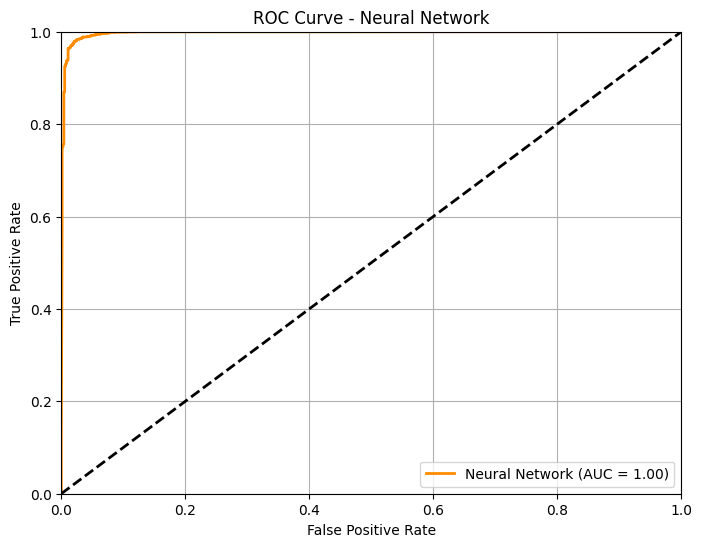

In [ ]:
model_nn_best_stage_3 = create_model(learning_rate=nn_lr_opt, activation=nn_activation, n_neuron_1=n_neuron_1, n_neuron_2=n_neuron_2, optimizer_type=nn_optimizer)
history = model_nn_best_stage_3.fit(X_train_scaled, y_train, epochs=50, batch_size=nn_batch_size, validation_split=0.1, verbose=0)

y_prob_nn = model_nn_best_stage_3.predict(X_test_scaled)
y_pred_nn = (y_prob_nn > 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Neural Network (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Here it can be seen the ROC curve for the neural network model run on the dataset of the stage 3. It can be noticekd that the AUC is closer to 1, which indicates that the model is able to distinguish between the 2 classes.

# Stage 3.5 - Stage 1 vs Stage 2 vs Stage 3 Dataset - Model Performance

Accuracy Report for the best XGB Model - Stage 1 Dataset
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       749
           1       0.93      0.95      0.94      4263

    accuracy                           0.89      5012
   macro avg       0.80      0.76      0.78      5012
weighted avg       0.89      0.89      0.89      5012

--------------------------------------------------------
Accuracy Report for the best NN Model - Stage 1 Dataset
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       727
           1       0.94      0.94      0.94      4244

    accuracy                           0.90      4971
   macro avg       0.79      0.80      0.80      4971
weighted avg       0.90      0.90      0.90      4971

--------------------------------------------------------
Accuracy Report for the best XGB Model - Stage 2 Dataset
              precision    recall  f1-score   support

       

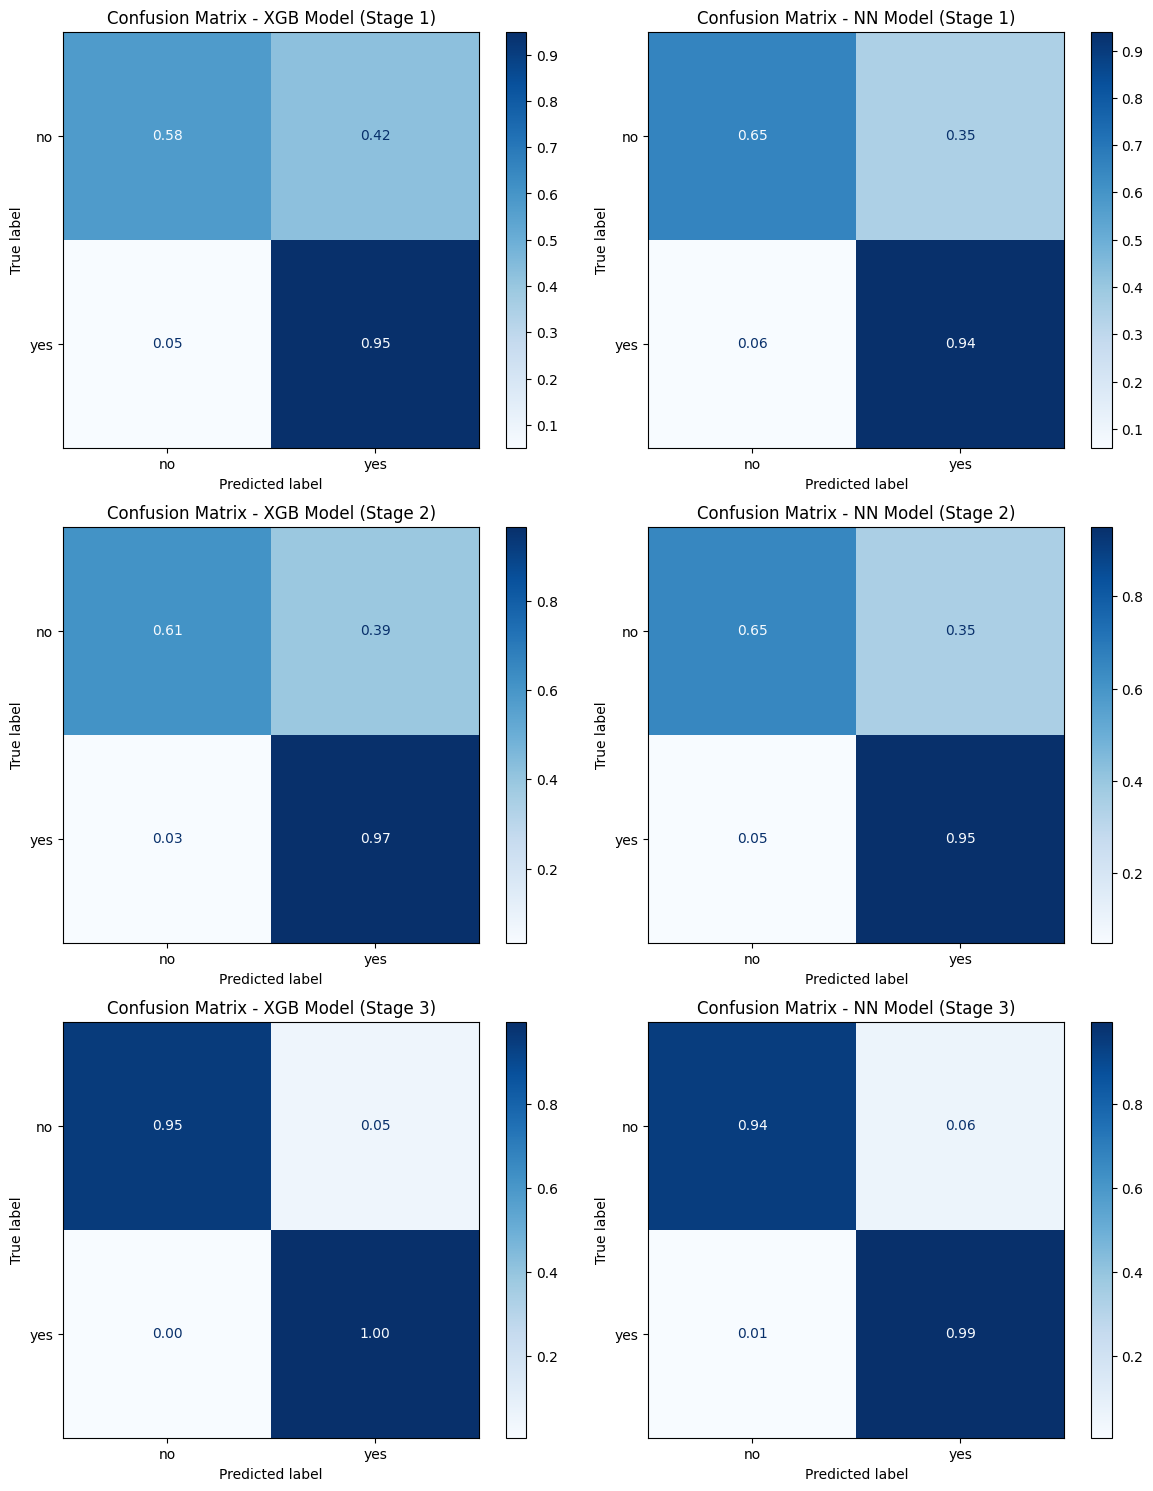

In [ ]:
print('Accuracy Report for the best XGB Model - Stage 1 Dataset')
print(cr_xbg_best_1)
print('--------------------------------------------------------')
print('Accuracy Report for the best NN Model - Stage 1 Dataset')
print(cr_nn_best_1)
print('--------------------------------------------------------')
print('Accuracy Report for the best XGB Model - Stage 2 Dataset')
print(cr_xbg_best_2)
print('--------------------------------------------------------')
print('Accuracy Report for the best NN Model - Stage 2 Dataset')
print(cr_nn_best_2)
print('--------------------------------------------------------')
print('Accuracy Report for the best XGB Model - Stage 3 Dataset')
print(cr_xbg_best_3)
print('--------------------------------------------------------')
print('Accuracy Report for the best NN Model - Stage 3 Dataset')
print(cr_nn_best_3)
print('--------------------------------------------------------')
print('AUC for the best XGB Model - Stage 1 dataset')
print(np.round(auc_score_xgb_best_1,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 1 dataset')
print(np.round(auc_score_nn_best_1,2))
print('--------------------------------------------------------')
print('AUC for the best XGB Model - Stage 2 dataset')
print(np.round(auc_score_xgb_best_2,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 2 dataset')
print(np.round(auc_score_nn_best_2,2))
print('-------------------------------------------------------')
print('AUC for the best XGB Model - Stage 3 dataset')
print(np.round(auc_score_xgb_best_3,2))
print('-------------------------------------------------------')
print('AUC for the best NN Model - Stage 3 dataset')
print(np.round(auc_score_nn_best_3,2))
print('-------------------------------------------------------')

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

def plot_normalized_cm(cm, ax, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=1, keepdims=True), display_labels=["no", "yes"])
    ax.set_title(title)
    disp.plot(ax=ax, cmap='Blues', values_format='.2f')

plot_normalized_cm(cm_xgb_best_1, axes[0, 0], "Confusion Matrix - XGB Model (Stage 1)")
plot_normalized_cm(cm_nn_best_1, axes[0, 1], "Confusion Matrix - NN Model (Stage 1)")
plot_normalized_cm(cm_xgb_best_2, axes[1, 0], "Confusion Matrix - XGB Model (Stage 2)")
plot_normalized_cm(cm_nn_best_2, axes[1, 1], "Confusion Matrix - NN Model (Stage 2)")
plot_normalized_cm(cm_xgb_best_3, axes[2, 0], "Confusion Matrix - XGB Model (Stage 3)")
plot_normalized_cm(cm_nn_best_3, axes[2, 1], "Confusion Matrix - NN Model (Stage 3)")

plt.tight_layout()
plt.show()


Comparing the models trained on datasets from stage 1, 2, and 3, we observe a significant performance improvement in those trained on stage 3. This is largely due to the addition of new features related to student progress, such as the number of modules passed, attempted, and failed. These features provide valuable insights into a student's likelihood of continuing the course, making them strong predictors for the model.

This result was expected, as these variables directly reflect a student's academic trajectory. However, it's important to note that the stage 3 dataset includes information that is only available at the end of the academic year. While it enhances model performance, it limits the ability to identify at-risk students early in the year, reducing its practical applicability for proactive intervention.

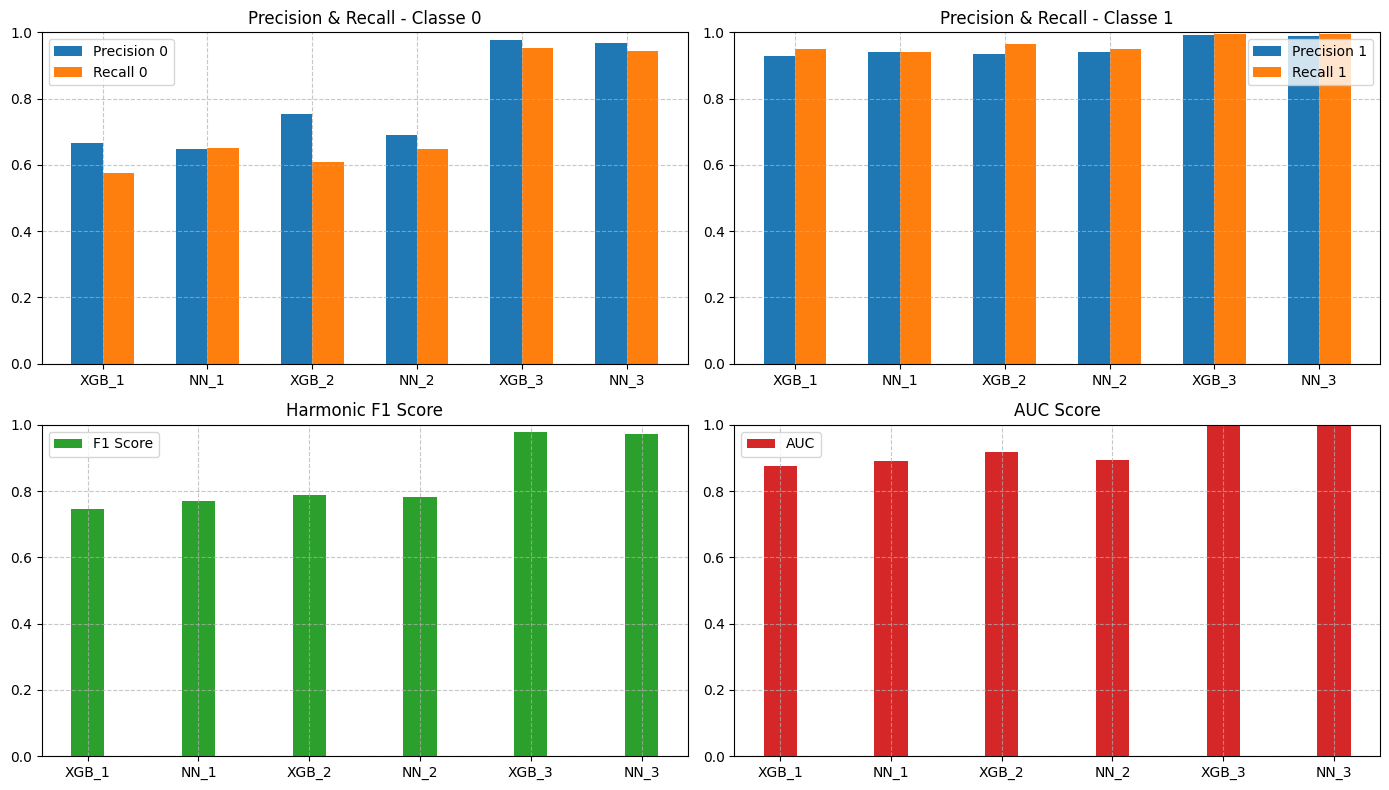

In [ ]:
def calculate_metrics(cm):
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[0, 0]

    precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    f1_harmonic = 2 * (f1_0 * f1_1) / (f1_0 + f1_1) if (f1_0 + f1_1) > 0 else 0

    return precision_0, recall_0, precision_1, recall_1, f1_harmonic

models = ["XGB_1", "NN_1", "XGB_2", "NN_2", "XGB_3", "NN_3"]
cm_list = [cm_xgb_best_1, cm_nn_best_1, cm_xgb_best_2, cm_nn_best_2, cm_xgb_best_3, cm_nn_best_3]
auc_scores = [auc_score_xgb_best_1, auc_score_nn_best_1, auc_score_xgb_best_2, auc_score_nn_best_2, auc_score_xgb_best_3, auc_score_nn_best_3]

metrics = [calculate_metrics(cm) for cm in cm_list]
precision_0, recall_0, precision_1, recall_1, f1_scores = zip(*metrics)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
x = np.arange(len(models))
bar_width = 0.3

axes[0, 0].bar(x - bar_width / 2, precision_0, bar_width, label="Precision 0")
axes[0, 0].bar(x + bar_width / 2, recall_0, bar_width, label="Recall 0")
axes[0, 0].set_title("Precision & Recall - Classe 0")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].grid(True, linestyle="--", alpha=0.7)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)

axes[0, 1].bar(x - bar_width / 2, precision_1, bar_width, label="Precision 1")
axes[0, 1].bar(x + bar_width / 2, recall_1, bar_width, label="Recall 1")
axes[0, 1].set_title("Precision & Recall - Classe 1")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].grid(True, linestyle="--", alpha=0.7)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

axes[1, 0].bar(x, f1_scores, bar_width, color="C2", label="F1 Score")
axes[1, 0].set_title("Harmonic F1 Score")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].grid(True, linestyle="--", alpha=0.7)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

axes[1, 1].bar(x, auc_scores, bar_width, color="C3", label="AUC")
axes[1, 1].set_title("AUC Score")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].grid(True, linestyle="--", alpha=0.7)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


This trend highlights the difficulty of identifying dropouts early in the course At stage 1, the model struggles to accurately identify students at risk of dropping out, as early-stage indicators provide limited predictive power. However, XGBoost’s feature importance analysis can still highlight key characteristics of students historically prone to dropping out, offering potential insights for early intervention strategies. By stage 2, mid-course indicators improve the model’s ability to detect at-risk students, capturing around 65% of cases. Despite this progress, the recall remains limited, suggesting that many students who eventually drop out do not exhibit strong warning signs early enough for effective intervention. It is only in stage 3 that clear academic patterns emerge, allowing the model to reliably classify at-risk students.